# RLLAB setup scripts for google colab
Install packages with compatible versions

In [0]:
!apt-get -qq install -y xvfb python-opengl > /dev/null 2>&1
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!apt-get -qq -y install xvfb freeglut3-dev ffmpeg > /dev/null

In [0]:
!pip install -q path.py
!pip install -q pyprind
!pip install -q cached_property
!pip install -q gym==0.7.4
!pip install -q theano==0.8.2
!pip install -q git+https://github.com/neocxi/Lasagne.git@484866cf8b38d878e92d521be445968531646bb8#egg=Lasagne
  
!pip install -q PyOpenGL piglet pyglet pyvirtualdisplay

stable-baselines 2.2.1 has requirement gym[atari,classic_control]>=0.10.9, but you'll have gym 0.7.4 which is incompatible.
dopamine-rl 1.0.5 has requirement gym>=0.10.5, but you'll have gym 0.7.4 which is incompatible.
pymc3 3.6 has requirement joblib<0.13.0, but you'll have joblib 0.13.0 which is incompatible.
pymc3 3.6 has requirement theano>=1.0.0, but you'll have theano 0.8.2 which is incompatible.


In [0]:
!pip install box2d-py mako==1.0.7 Pygame JSAnimation imageio

    100% |████████████████████████████████| 450kB 13.2MB/s 
    100% |████████████████████████████████| 573kB 28.3MB/s 
    100% |████████████████████████████████| 12.1MB 3.0MB/s 
  Running setup.py bdist_wheel for mako ... - \ done
  Stored in directory: /root/.cache/pip/wheels/15/35/25/dbcb848832ccb1a4b4ad23f529badfd3bce9bf88017f7ca510
  Running setup.py bdist_wheel for JSAnimation ... - done
  Stored in directory: /root/.cache/pip/wheels/3c/c2/b2/b444dffc3eed9c78139288d301c4009a42c0dd061d3b62cead
Successfully built mako JSAnimation


In [0]:
!git clone https://github.com/kekim/rllab.git rllab-git

Cloning into 'rllab-git'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 1440 (delta 9), reused 32 (delta 7), pack-reused 1395
Receiving objects: 100% (1440/1440), 1.55 MiB | 4.95 MiB/s, done.
Resolving deltas: 100% (769/769), done.


In [0]:
!cp -a ./rllab-git/* .

# DDPG on MountainCarContinuous-v0 (OpenAI Gym version)
**Important!**
Before running the following cell, make sure rllab is set up properly in your current runtime by executing codes in RLLAB setup scripts.

**1. Implement DDPG Algorithm**

- Import necessary packages
(Execute **once again** if you encounter an error)

In [0]:
from rllab.envs.gym_env import GymEnv
#from rllab.algos.ddpg import DDPG
from rllab.envs.normalized_env import normalize
from rllab.misc.instrument import run_experiment_lite
from rllab.exploration_strategies.ou_strategy import OUStrategy
from rllab.policies.deterministic_mlp_policy import DeterministicMLPPolicy
from rllab.q_functions.continuous_mlp_q_function import ContinuousMLPQFunction

# Packages for DDPG algos 
from rllab.algos.base import RLAlgorithm
from rllab.misc.overrides import overrides
from rllab.misc import special
from rllab.misc import ext
from rllab.sampler import parallel_sampler
from rllab.plotter import plotter
from functools import partial
import rllab.misc.logger as logger
import theano.tensor as TT
import pickle as pickle
import numpy as np
import pyprind
import lasagne

/usr/local/lib/python3.6/dist-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


- Tools for implementing DDPG algorithm

In [0]:
def parse_update_method(update_method, **kwargs):
    if update_method == 'adam':
        return partial(lasagne.updates.adam, **ext.compact(kwargs))
    elif update_method == 'sgd':
        return partial(lasagne.updates.sgd, **ext.compact(kwargs))
    else:
        raise NotImplementedError

# Replay Buffer
class SimpleReplayPool(object):
    def __init__(
            self, max_pool_size, observation_dim, action_dim):
        self._observation_dim = observation_dim
        self._action_dim = action_dim
        self._max_pool_size = max_pool_size
        self._observations = np.zeros(
            (max_pool_size, observation_dim),
        )
        self._actions = np.zeros(
            (max_pool_size, action_dim),
        )
        self._rewards = np.zeros(max_pool_size)
        self._terminals = np.zeros(max_pool_size, dtype='uint8')
        self._bottom = 0
        self._top = 0
        self._size = 0
    # Add transition to the buffer
    def add_sample(self, observation, action, reward, terminal):
        self._observations[self._top] = observation
        self._actions[self._top] = action
        self._rewards[self._top] = reward
        self._terminals[self._top] = terminal
        self._top = (self._top + 1) % self._max_pool_size
        if self._size >= self._max_pool_size:
            self._bottom = (self._bottom + 1) % self._max_pool_size
        else:
            self._size += 1
    # Sample random minibathc with mini-batch size of "batch_size"
    def random_batch(self, batch_size):
        assert self._size > batch_size
        indices = np.zeros(batch_size, dtype='uint64')
        transition_indices = np.zeros(batch_size, dtype='uint64')
        count = 0
        while count < batch_size:
            index = np.random.randint(self._bottom, self._bottom + self._size) % self._max_pool_size
            # make sure that the transition is valid: if we are at the end of the pool, we need to discard
            # this sample
            if index == self._size - 1 and self._size <= self._max_pool_size:
                continue
            # if self._terminals[index]:
            #     continue
            transition_index = (index + 1) % self._max_pool_size
            indices[count] = index
            transition_indices[count] = transition_index
            count += 1
        return dict(
            observations=self._observations[indices],
            actions=self._actions[indices],
            rewards=self._rewards[indices],
            terminals=self._terminals[indices],
            next_observations=self._observations[transition_indices]
        )
    # Return size of the replay buffer
    @property
    def size(self):
        return self._size

- Implement DDPG algorithm

In [0]:
class DDPG(RLAlgorithm):
    """
    Deep Deterministic Policy Gradient.
    """

    def __init__(
            self,
            env,
            policy,
            qf,
            es,
            batch_size=32,
            n_epochs=200,
            epoch_length=1000,
            min_pool_size=10000,
            replay_pool_size=1000000,
            discount=0.99,
            max_path_length=250,
            qf_weight_decay=0.,
            qf_update_method='adam',
            qf_learning_rate=1e-3,
            policy_weight_decay=0,
            policy_update_method='adam',
            policy_learning_rate=1e-4,
            eval_samples=10000,
            soft_target=True,
            soft_target_tau=0.001,
            n_updates_per_sample=1,
            scale_reward=1.0,
            include_horizon_terminal_transitions=False,
            plot=False,
            pause_for_plot=False):
        """
        :param env: Environment
        :param policy: Policy
        :param qf: Q function
        :param es: Exploration strategy
        :param batch_size: Number of samples for each minibatch.
        :param n_epochs: Number of epochs. Policy will be evaluated after each epoch.
        :param epoch_length: How many timesteps for each epoch.
        :param min_pool_size: Minimum size of the pool to start training.
        :param replay_pool_size: Size of the experience replay pool.
        :param discount: Discount factor for the cumulative return.
        :param max_path_length: Discount factor for the cumulative return.
        :param qf_weight_decay: Weight decay factor for parameters of the Q function.
        :param qf_update_method: Online optimization method for training Q function.
        :param qf_learning_rate: Learning rate for training Q function.
        :param policy_weight_decay: Weight decay factor for parameters of the policy.
        :param policy_update_method: Online optimization method for training the policy.
        :param policy_learning_rate: Learning rate for training the policy.
        :param eval_samples: Number of samples (timesteps) for evaluating the policy.
        :param soft_target_tau: Interpolation parameter for doing the soft target update.
        :param n_updates_per_sample: Number of Q function and policy updates per new sample obtained
        :param scale_reward: The scaling factor applied to the rewards when training
        :param include_horizon_terminal_transitions: whether to include transitions with terminal=True because the
        horizon was reached. This might make the Q value back up less stable for certain tasks.
        :param plot: Whether to visualize the policy performance after each eval_interval.
        :param pause_for_plot: Whether to pause before continuing when plotting.
        :return:
        """
        self.env = env
        self.policy = policy
        self.qf = qf
        self.es = es
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.epoch_length = epoch_length
        self.min_pool_size = min_pool_size
        self.replay_pool_size = replay_pool_size
        self.discount = discount
        self.max_path_length = max_path_length
        self.qf_weight_decay = qf_weight_decay
        self.qf_update_method = \
            parse_update_method(
                qf_update_method,
                learning_rate=qf_learning_rate,
            )
        self.qf_learning_rate = qf_learning_rate
        self.policy_weight_decay = policy_weight_decay
        self.policy_update_method = \
            parse_update_method(
                policy_update_method,
                learning_rate=policy_learning_rate,
            )
        self.policy_learning_rate = policy_learning_rate
        self.eval_samples = eval_samples
        self.soft_target_tau = soft_target_tau
        self.n_updates_per_sample = n_updates_per_sample
        self.include_horizon_terminal_transitions = include_horizon_terminal_transitions
        self.plot = plot
        self.pause_for_plot = pause_for_plot

        self.qf_loss_averages = []
        self.policy_surr_averages = []
        self.q_averages = []
        self.y_averages = []
        self.paths = []
        self.es_path_returns = []
        self.paths_samples_cnt = 0

        self.scale_reward = scale_reward

        self.opt_info = None

    # use worker process to interact with the environment with self.policy
    def start_worker(self):
        parallel_sampler.populate_task(self.env, self.policy)
        if self.plot:
            plotter.init_plot(self.env, self.policy)
 
    @overrides
    def train(self):
        # Make replay buffer
        pool = SimpleReplayPool(
            max_pool_size=self.replay_pool_size,
            observation_dim=self.env.observation_space.flat_dim,
            action_dim=self.env.action_space.flat_dim,
        )
        
        # Start the worker to interact with the environment
        self.start_worker()

        self.init_opt()
        itr = 0
        path_length = 0 # episode length
        path_return = 0 # epsidoe return
        terminal = False # flag for the end of episode
        observation = self.env.reset() # first observation to start with

        sample_policy = pickle.loads(pickle.dumps(self.policy)) # policy not yet learned

        for epoch in range(self.n_epochs):
            logger.push_prefix('epoch #%d | ' % epoch)
            logger.log("Training started")
            terminal = True
            for epoch_itr in pyprind.prog_bar(range(self.epoch_length)):
                # If terminal or the end of episode or start of the epoch, start new episode
                # Execute policy
                if terminal:  # or path_length > self.max_path_length:
                    # Note that if the last time step ends an episode, the very
                    # last state and observation will be ignored and not added
                    # to the replay pool
                    observation = self.env.reset() # reset environment
                    self.es.reset() # reset exploration strategy (OU)
                    sample_policy.reset() # reset hidden of RNN policy
                    self.es_path_returns.append(path_return)
                    path_length = 0
                    path_return = 0
                # action with OU noise added
                action = self.es.get_action(itr, observation, policy=sample_policy)  # qf=qf)

                # interact with the environment
                next_observation, reward, terminal, _ = self.env.step(action)
                path_length += 1
                path_return += reward

                # Save transition to the replay buffer
                if not terminal and path_length >= self.max_path_length:
                    terminal = True
                    # only include the terminal transition in this case if the flag was set
                    if self.include_horizon_terminal_transitions:
                        pool.add_sample(observation, action, reward * self.scale_reward, terminal)
                else:
                    pool.add_sample(observation, action, reward * self.scale_reward, terminal)

                observation = next_observation
                # when the replay buffer size is over the specified minimum size, than sample transitions form  it and do training 
                if pool.size >= self.min_pool_size:
                    for update_itr in range(self.n_updates_per_sample):
                        # Train policy
                        batch = pool.random_batch(self.batch_size)
                        self.do_training(itr, batch)
                    sample_policy.set_param_values(self.policy.get_param_values())

                itr += 1
            # write logger file
            logger.log("Training finished")
            if pool.size >= self.min_pool_size:
                self.evaluate(epoch, pool)
                params = self.get_epoch_snapshot(epoch)
                logger.save_itr_params(epoch, params)
            logger.dump_tabular(with_prefix=False)
            logger.pop_prefix()
            if self.plot:
                self.update_plot()
                if self.pause_for_plot:
                    input("Plotting evaluation run: Press Enter to "
                              "continue...")
        self.env.terminate()
        self.policy.terminate()

    def init_opt(self):
        # init_opt makes computational graphs that will be used for training

        # First, create "target" policy and Q functions
        target_policy = pickle.loads(pickle.dumps(self.policy))
        target_qf = pickle.loads(pickle.dumps(self.qf))

        # variable to pass observations 
        obs = self.env.observation_space.new_tensor_variable(
            'obs',
            extra_dims=1,
        )

        # variable to pass actions
        action = self.env.action_space.new_tensor_variable(
            'action',
            extra_dims=1,
        )
        
        # varaible to pass targets
        yvar = TT.vector('ys')

        # for the weight decay of Q param
        qf_weight_decay_term = 0.5 * self.qf_weight_decay * \
                               sum([TT.sum(TT.square(param)) for param in
                                    self.qf.get_params(regularizable=True)])
        # Get Q
        qval = self.qf.get_qval_sym(obs, action)
        
        # Get Bellman error of Q
        qf_loss = TT.mean(TT.square(yvar - qval))
        # Add weight decay term if required
        qf_reg_loss = qf_loss + qf_weight_decay_term
        # Loss for the policy param weight decay
        policy_weight_decay_term = 0.5 * self.policy_weight_decay * \
                                   sum([TT.sum(TT.square(param))
                                        for param in self.policy.get_params(regularizable=True)])
        #  Use action from the deterministic self.policy to get Q value policy_qval
        policy_qval = self.qf.get_qval_sym(
            obs, self.policy.get_action_sym(obs),
            deterministic=True
        )
        
        # minimizing policy_surr is equivalent to maximizing expected Q with policy param
        policy_surr = -TT.mean(policy_qval)
        # Do weight decay for the policy if required
        policy_reg_surr = policy_surr + policy_weight_decay_term

        # updated Q by mean square Bellman error with wieght decay loss which is qf_reg_loss
        qf_updates = self.qf_update_method(
            qf_reg_loss, self.qf.get_params(trainable=True))
        policy_updates = self.policy_update_method(
            policy_reg_surr, self.policy.get_params(trainable=True))

        # Make computation graphs
        f_train_qf = ext.compile_function(
            inputs=[yvar, obs, action],
            outputs=[qf_loss, qval],
            updates=qf_updates
        )

        f_train_policy = ext.compile_function(
            inputs=[obs],
            outputs=policy_surr,
            updates=policy_updates
        )

        self.opt_info = dict(
            f_train_qf=f_train_qf,
            f_train_policy=f_train_policy,
            target_qf=target_qf,
            target_policy=target_policy,
        )

    def do_training(self, itr, batch):

        obs, actions, rewards, next_obs, terminals = ext.extract(
            batch,
            "observations", "actions", "rewards", "next_observations",
            "terminals"
        )

       
        target_qf = self.opt_info["target_qf"]
        target_policy = self.opt_info["target_policy"]
        # Target policy and Q used for calculating TD  error
        next_actions, _ = target_policy.get_actions(next_obs)
        # Get Q value with the action from deterministic policy
        next_qvals = target_qf.get_qval(next_obs, next_actions)
        # Get TD error
        ys = rewards + (1. - terminals) * self.discount * next_qvals

        f_train_qf = self.opt_info["f_train_qf"]
        f_train_policy = self.opt_info["f_train_policy"]
        
        # Get TD error of Q and also Q and update Q param
        qf_loss, qval = f_train_qf(ys, obs, actions)
        # Get objective for the policy which is -E[Q] and udpate policy param
        policy_surr = f_train_policy(obs)

        # Polyak averaging self.soft_target_tau close to 1
        target_policy.set_param_values(
            target_policy.get_param_values() * (1.0 - self.soft_target_tau) +
            self.policy.get_param_values() * self.soft_target_tau)
        target_qf.set_param_values(
            target_qf.get_param_values() * (1.0 - self.soft_target_tau) +
            self.qf.get_param_values() * self.soft_target_tau)

        self.qf_loss_averages.append(qf_loss)
        self.policy_surr_averages.append(policy_surr)
        self.q_averages.append(qval)
        self.y_averages.append(ys)

    # Evaluate algorithm, write log files
    def evaluate(self, epoch, pool):
        logger.log("Collecting samples for evaluation")
        paths = parallel_sampler.sample_paths(
            policy_params=self.policy.get_param_values(),
            max_samples=self.eval_samples,
            max_path_length=self.max_path_length,
        )

        average_discounted_return = np.mean(
            [special.discount_return(path["rewards"], self.discount) for path in paths]
        )

        returns = [sum(path["rewards"]) for path in paths]

        all_qs = np.concatenate(self.q_averages)
        all_ys = np.concatenate(self.y_averages)

        average_q_loss = np.mean(self.qf_loss_averages)
        average_policy_surr = np.mean(self.policy_surr_averages)
        average_action = np.mean(np.square(np.concatenate(
            [path["actions"] for path in paths]
        )))

        policy_reg_param_norm = np.linalg.norm(
            self.policy.get_param_values(regularizable=True)
        )
        qfun_reg_param_norm = np.linalg.norm(
            self.qf.get_param_values(regularizable=True)
        )

        logger.record_tabular('Epoch', epoch)
        logger.record_tabular('AverageReturn',
                              np.mean(returns))
        logger.record_tabular('StdReturn',
                              np.std(returns))
        logger.record_tabular('MaxReturn',
                              np.max(returns))
        logger.record_tabular('MinReturn',
                              np.min(returns))
        if len(self.es_path_returns) > 0:
            logger.record_tabular('AverageEsReturn',
                                  np.mean(self.es_path_returns))
            logger.record_tabular('StdEsReturn',
                                  np.std(self.es_path_returns))
            logger.record_tabular('MaxEsReturn',
                                  np.max(self.es_path_returns))
            logger.record_tabular('MinEsReturn',
                                  np.min(self.es_path_returns))
        logger.record_tabular('AverageDiscountedReturn',
                              average_discounted_return)
        logger.record_tabular('AverageQLoss', average_q_loss)
        logger.record_tabular('AveragePolicySurr', average_policy_surr)
        logger.record_tabular('AverageQ', np.mean(all_qs))
        logger.record_tabular('AverageAbsQ', np.mean(np.abs(all_qs)))
        logger.record_tabular('AverageY', np.mean(all_ys))
        logger.record_tabular('AverageAbsY', np.mean(np.abs(all_ys)))
        logger.record_tabular('AverageAbsQYDiff',
                              np.mean(np.abs(all_qs - all_ys)))
        logger.record_tabular('AverageAction', average_action)

        logger.record_tabular('PolicyRegParamNorm',
                              policy_reg_param_norm)
        logger.record_tabular('QFunRegParamNorm',
                              qfun_reg_param_norm)

        self.env.log_diagnostics(paths)
        self.policy.log_diagnostics(paths)

        self.qf_loss_averages = []
        self.policy_surr_averages = []

        self.q_averages = []
        self.y_averages = []
        self.es_path_returns = []

    def update_plot(self):
        if self.plot:
            plotter.update_plot(self.policy, self.max_path_length)

    def get_epoch_snapshot(self, epoch):
        return dict(
            env=self.env,
            epoch=epoch,
            qf=self.qf,
            policy=self.policy,
            target_qf=self.opt_info["target_qf"],
            target_policy=self.opt_info["target_policy"],
            es=self.es,
        )

**2. Execute Your Algorithm**

- Activate a virtual display

In [0]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()
import os
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)

- Create & Run a RL task for Acrobot

In [0]:
def run_task(*_):

    env = normalize(GymEnv(env_name = "MountainCarContinuous-v0",force_reset=True))
    # max timesteps for a episode
    max_path_length = 300

    # Use  determinstic policy made with MLP 64-64
    policy = DeterministicMLPPolicy(
        env_spec=env.spec,
        # The neural network policy should have two hidden layers
        hidden_sizes=(64, 64)
    )
# we use OU noise to add to action for exploration
    es = OUStrategy(env_spec=env.spec)
# Q function is MLP with 64-64 NN
    qf = ContinuousMLPQFunction(env_spec=env.spec,
                                hidden_sizes=(64, 64)
                                )
          """
        :param env: Environment
        :param policy: Policy
        :param qf: Q function
        :param es: Exploration strategy
        :param batch_size: Number of samples for each minibatch.
        :param n_epochs: Number of epochs. Policy will be evaluated after each epoch.
        :param epoch_length: How many timesteps for each epoch.
        :param min_pool_size: Minimum size of the pool to start training.
        :param replay_pool_size: Size of the experience replay pool.
        :param discount: Discount factor for the cumulative return.
        :param max_path_length: Discount factor for the cumulative return.
        :param qf_weight_decay: Weight decay factor for parameters of the Q function.
        :param qf_update_method: Online optimization method for training Q function.
        :param qf_learning_rate: Learning rate for training Q function.
        :param policy_weight_decay: Weight decay factor for parameters of the policy.
        :param policy_update_method: Online optimization method for training the policy.
        :param policy_learning_rate: Learning rate for training the policy.
        :param eval_samples: Number of samples (timesteps) for evaluating the policy.
        :param soft_target_tau: Interpolation parameter for doing the soft target update.
        :param n_updates_per_sample: Number of Q function and policy updates per new sample obtained
        :param scale_reward: The scaling factor applied to the rewards when training
        :param include_horizon_terminal_transitions: whether to include transitions with terminal=True because the
        horizon was reached. This might make the Q value back up less stable for certain tasks.
        :param plot: Whether to visualize the policy performance after each eval_interval.
        :param pause_for_plot: Whether to pause before continuing when plotting.
        :return:
        """
    algo = DDPG(
        env=env,
        policy=policy,
        es=es,
        qf=qf,
        batch_size=100,
        n_updates_per_sample = 1,
        max_path_length=max_path_length,
        epoch_length=900,
        min_pool_size=800,
        replay_pool_size = 5000,
        n_epochs=1000,
        discount=0.99,
        scale_reward=0.1,
        qf_learning_rate=1e-3,
        policy_learning_rate=1e-4,
    )
    algo.train()
    
#################################################################################
# Set up path with corresponding environment name and algorithm name to save logs
# Ex) mypath = '/content/acrobot_dqn'

mypath = './log/ddpg_mntcar/' 
#################################################################################  
    
run_experiment_lite(
  run_task,
  # Number of parallel workers for sampling
  log_dir=mypath,
  n_parallel=1,
  # Only keep the snapshot parameters for the last iteration
  snapshot_mode="last",
  # Specifies the seed for the experiment. If this is not provided, a random seed
  # will be used
  seed=1,
  # plot=True,
)

python /content/scripts/run_experiment_lite.py  --n_parallel '1'  --snapshot_mode 'last'  --seed '1'  --exp_name 'experiment_2019_01_16_15_26_15_0001'  --log_dir './log/ddpg_mntcar/'  --use_cloudpickle 'True'  --args_data 'gASV2DAAAAAAAACMF2Nsb3VkcGlja2xlLmNsb3VkcGlja2xllIwOX2ZpbGxfZnVuY3Rpb26Uk5QoaACMD19tYWtlX3NrZWxfZnVuY5STlGgAjA1fYnVpbHRpbl90eXBllJOUjAhDb2RlVHlwZZSFlFKUKEsASwBLB0sRS0dDbnQAdAFkAWQCZAONAoMBfQFkBH0CdAJ8AWoDZBNkBo0CfQN0BHwBagNkB40BfQR0BXwBagNkFGQGjQJ9BXQGfAF8A3wEfAVkCGQJfAJkCmQLZAxkDWQOZA9kEGQRZBKND30GfAZqB4MAAQBkAFMAlChOjBhNb3VudGFpbkNhckNvbnRpbnVvdXMtdjCUiIwIZW52X25hbWWUjAtmb3JjZV9yZXNldJSGlE0sAUtAjAhlbnZfc3BlY5SMDGhpZGRlbl9zaXplc5SGlGgPhZRLZEsBTYQDTSADTYgTTegDRz/vrhR64UeuRz+5mZmZmZmaRz9QYk3S8an8Rz8aNuLrHEMtKIwDZW52lIwGcG9saWN5lIwCZXOUjAJxZpSMCmJhdGNoX3NpemWUjBRuX3VwZGF0ZXNfcGVyX3NhbXBsZZSMD21heF9wYXRoX2xlbmd0aJSMDGVwb2NoX2xlbmd0aJSMDW1pbl9wb29sX3NpemWUjBByZXBsYXlfcG9vbF9zaXpllIwIbl9lcG9jaHOUjAhkaXNjb3VudJSMDHNjYWxlX3Jld2FyZJSMEHFmX2xlYXJuaW5nX3JhdGWUjBRwb2xpY3lfbGVhc

**3. Average Reward Plotting**

- You can evaluate how your agent is being trained with reward it gets in every iteration. 
- Whenever you execute the code 'run_experiment_lite', it will generate a experiment directory.
- (/content/log/vpg_reinforce/)
- Please update the value of '**mypath**' and specify your new experiment directory name. 

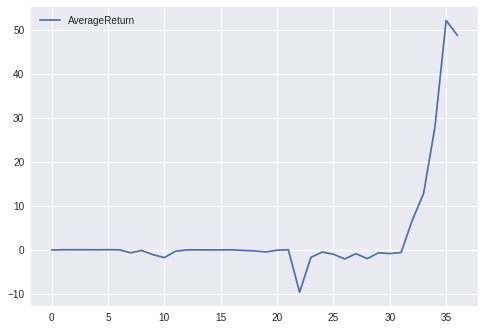

In [0]:
import os.path as osp
import numpy as np
import csv
import matplotlib.pyplot as plt
import json
import joblib
from glob import glob
import os

plots = []
legends = []
returns = []
with open(osp.join(mypath, 'progress.csv'), 'rt') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        if row['AverageReturn']:
            returns.append(float(row['AverageReturn']))
returns = np.array(returns)
plots.append(plt.plot(returns)[0])
legends.append('AverageReturn')
plt.legend(plots, legends)
plt.show()

**4. Play Videos of your Agent Behavior**

- You can watch how your agent's behavior improves.
- If you haven't update 'mypath' in the code above, you need to update it here.
- (/content/log/ddqn_mntcar/)


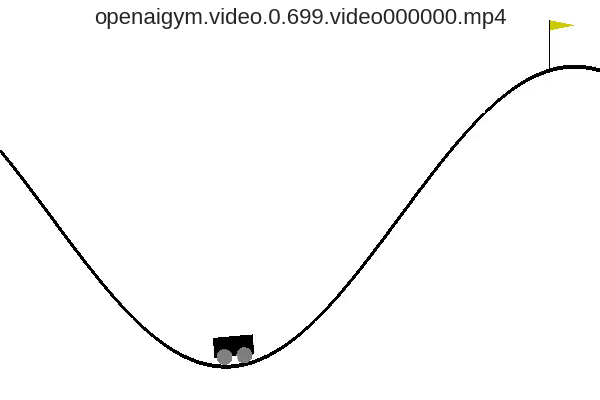
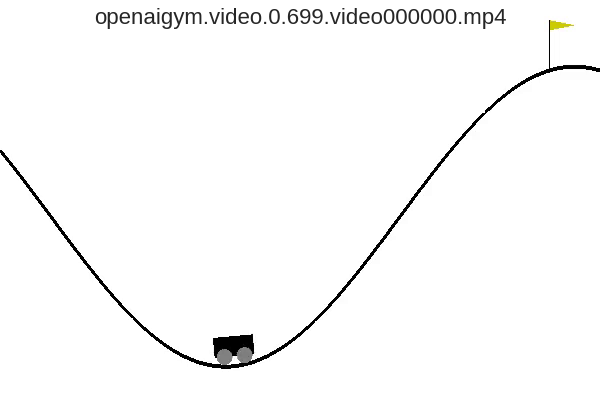
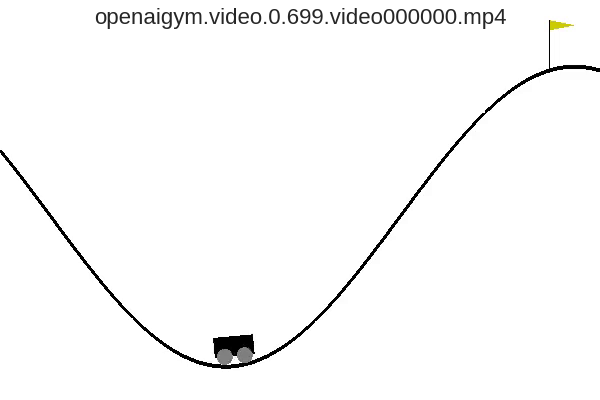
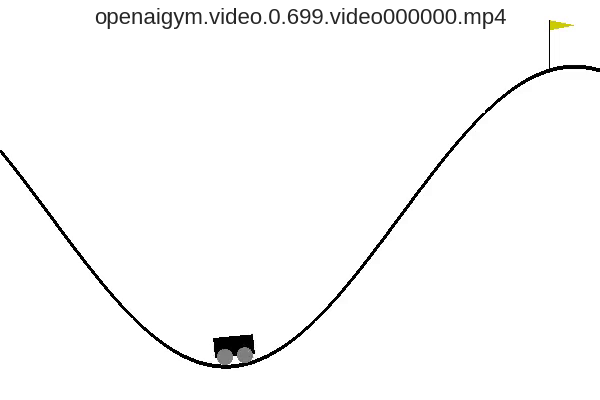
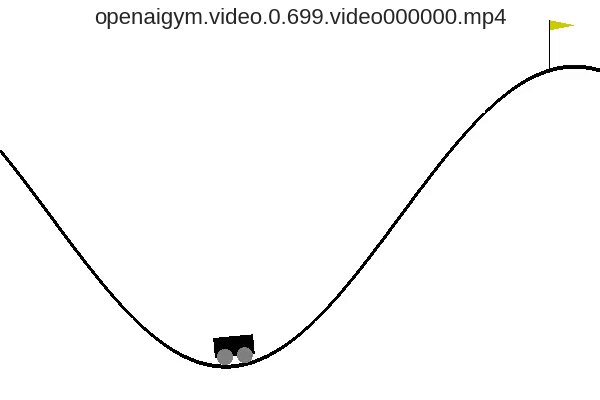
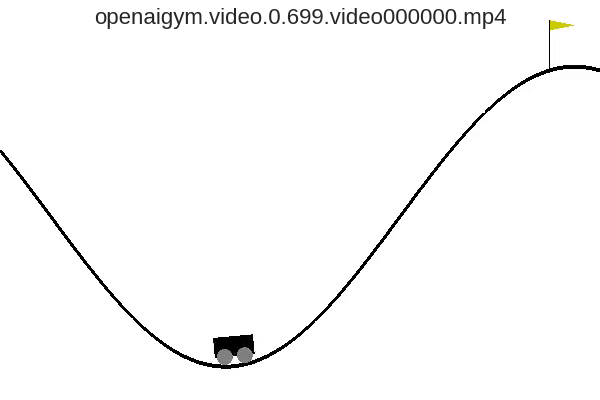
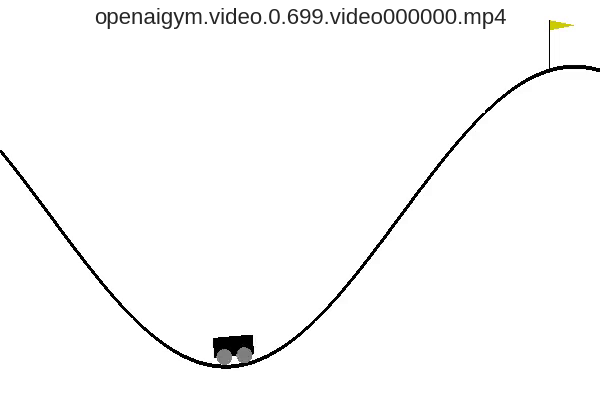
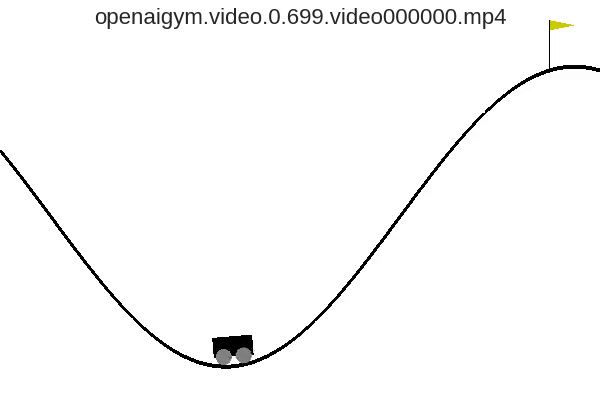
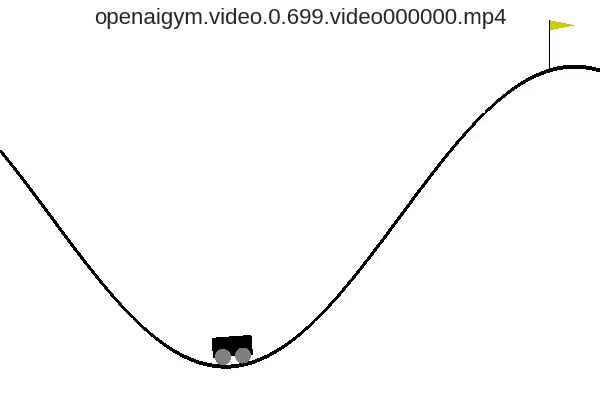
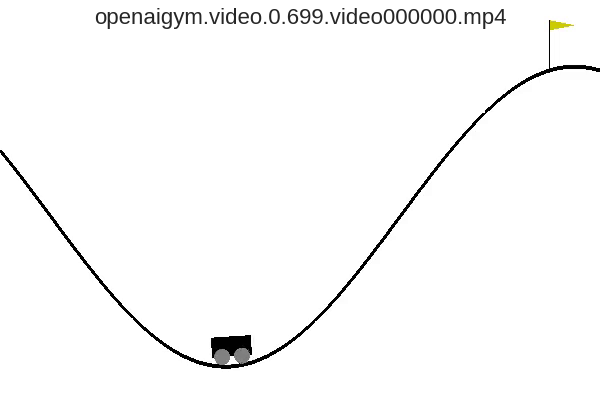
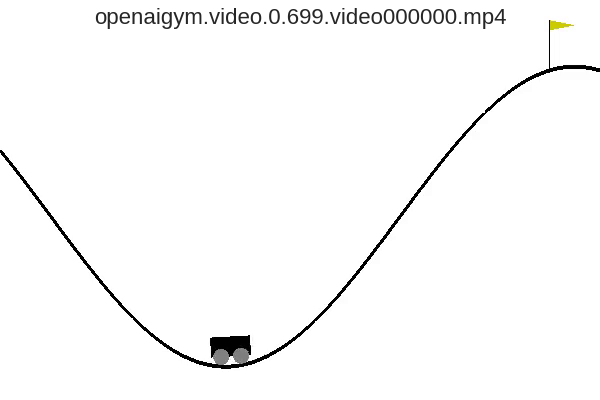
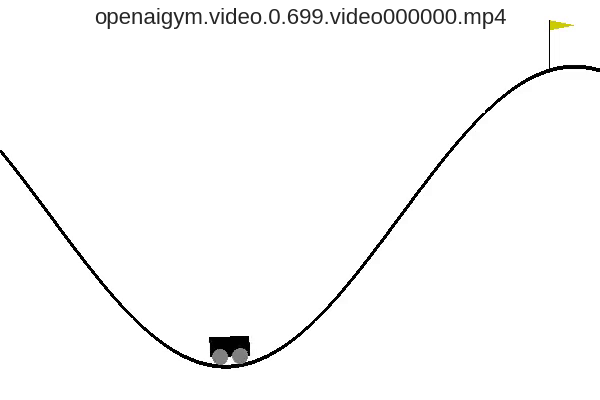
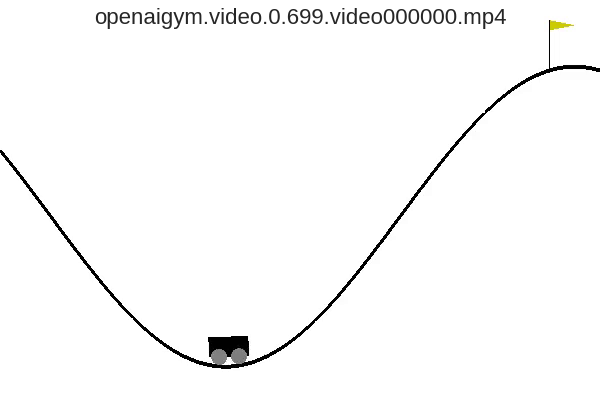
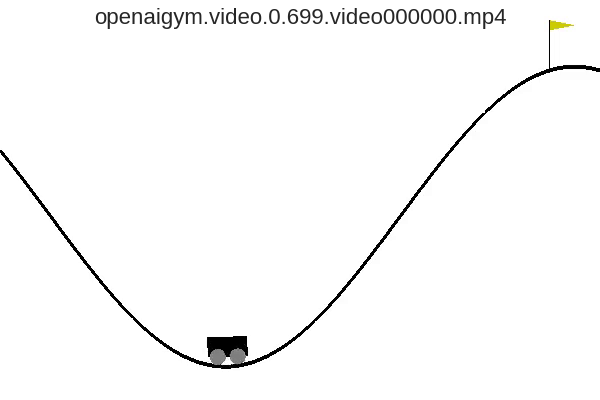
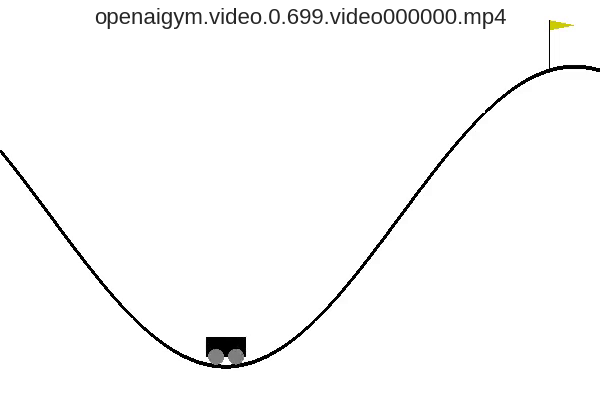
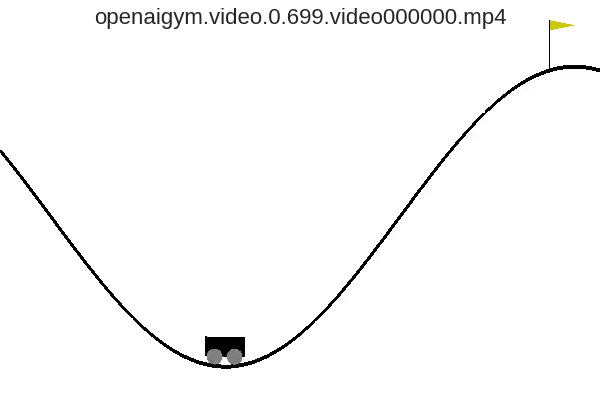
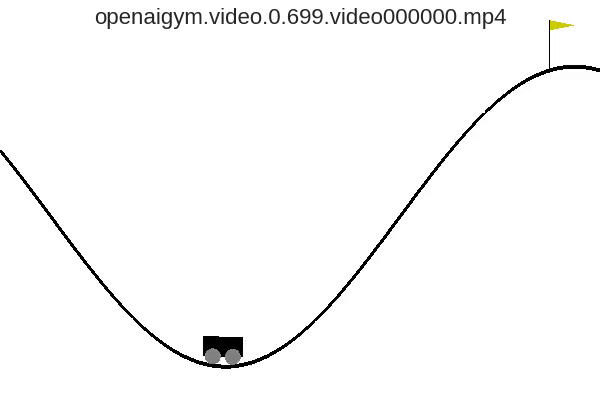
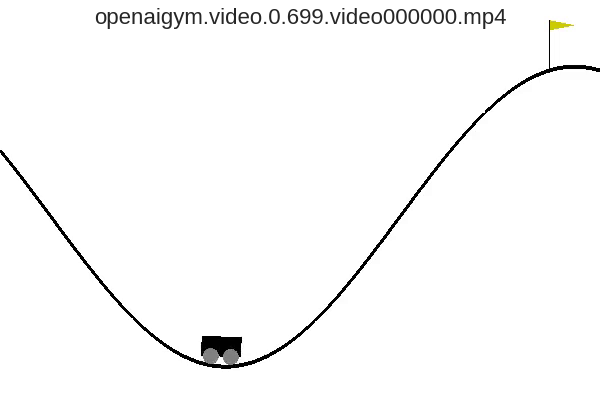
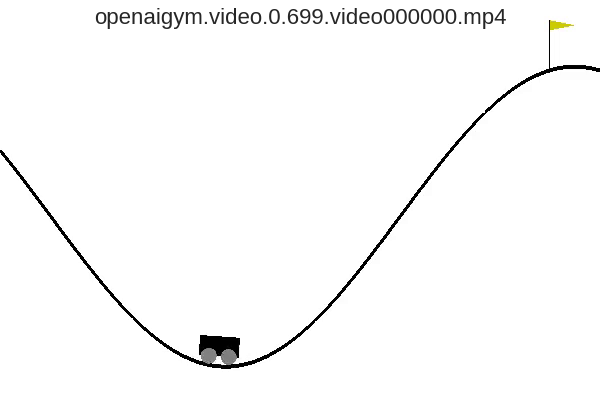
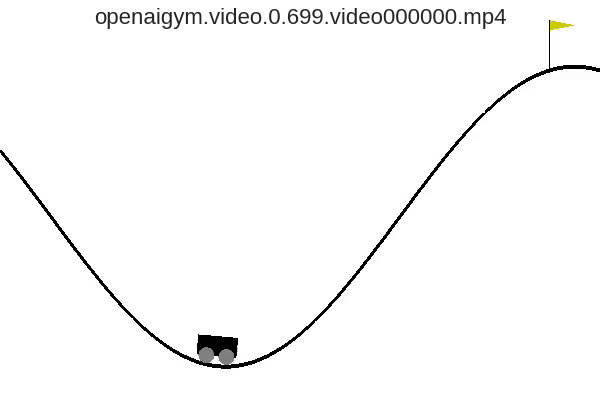
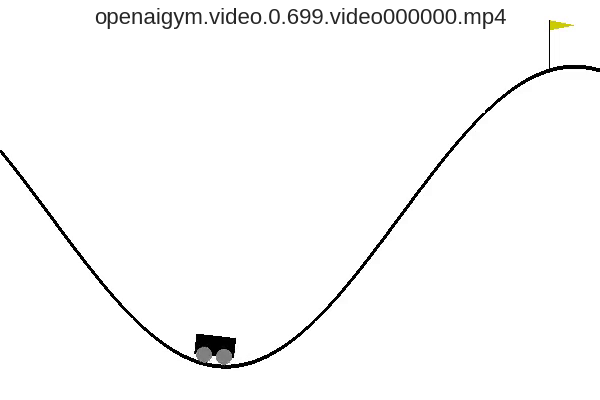
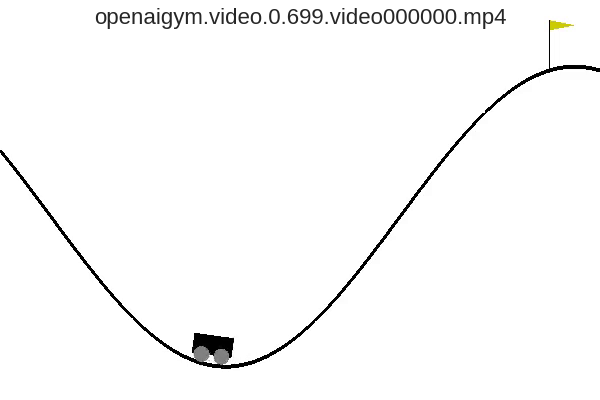
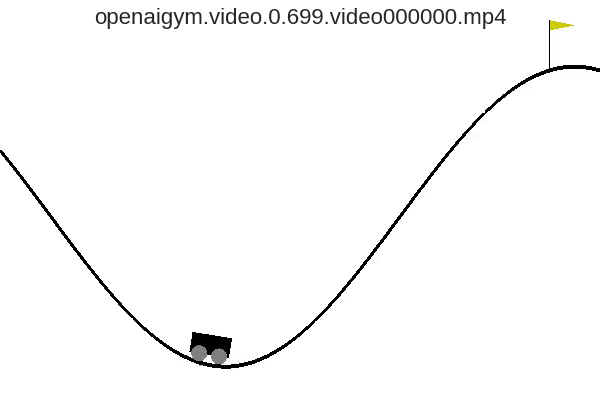
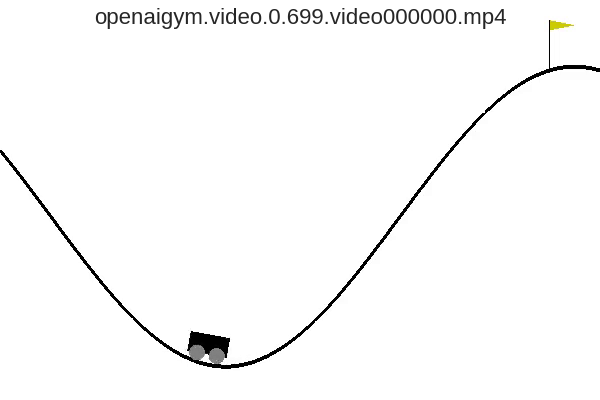
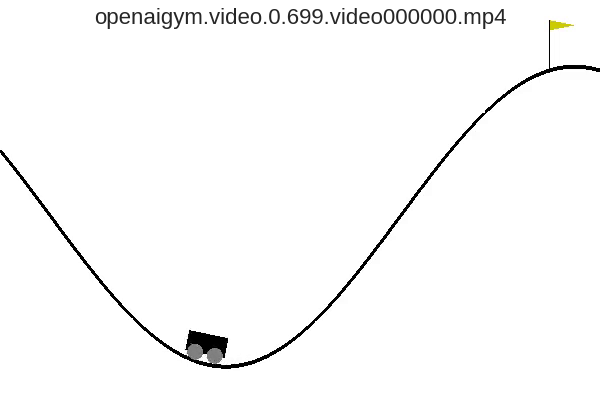
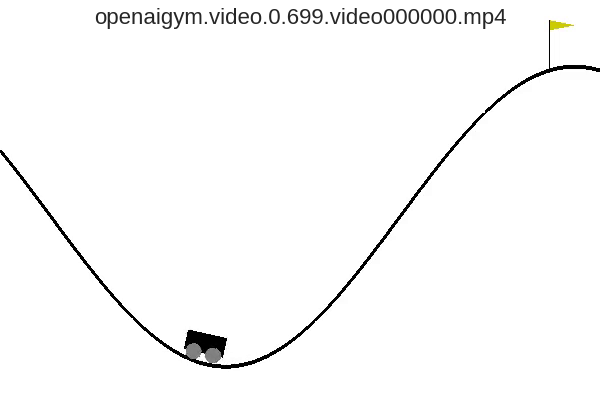
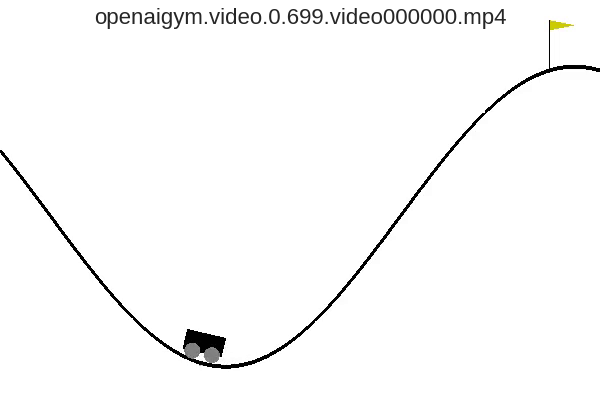
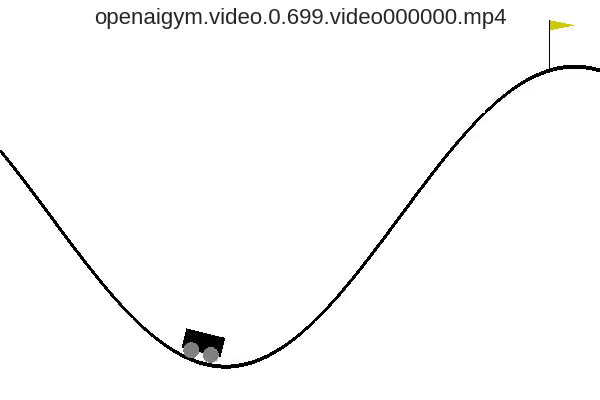
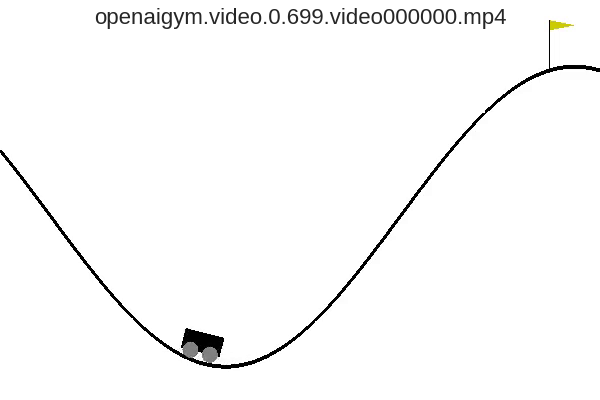
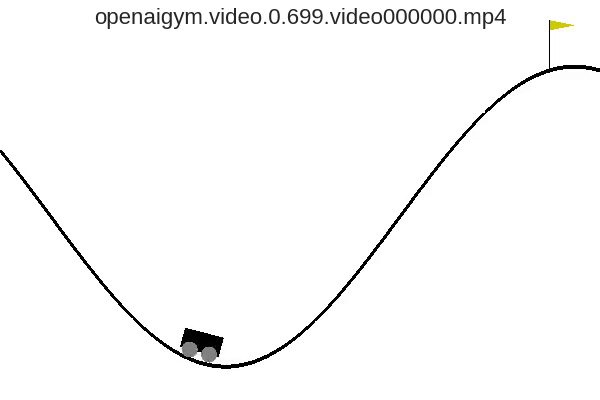
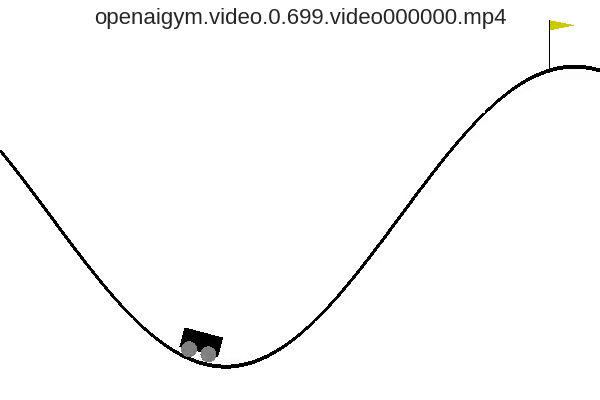
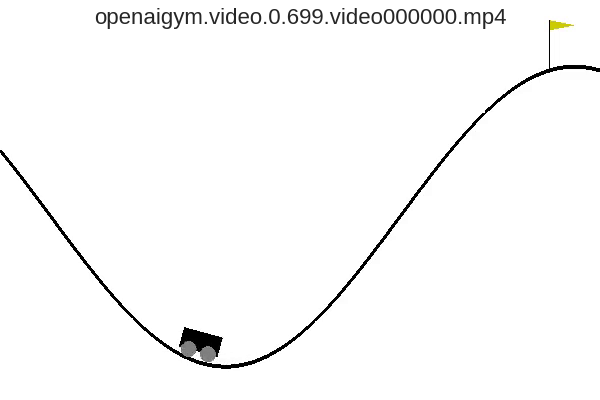
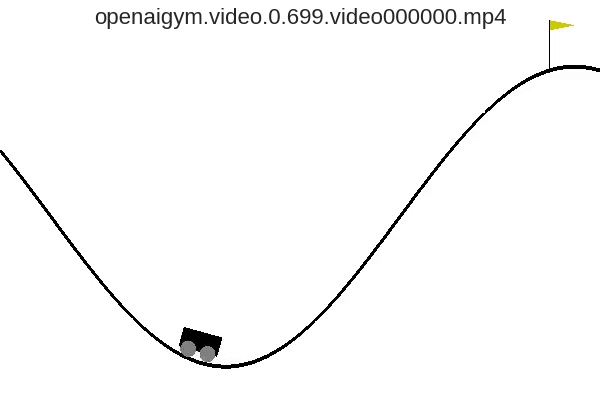
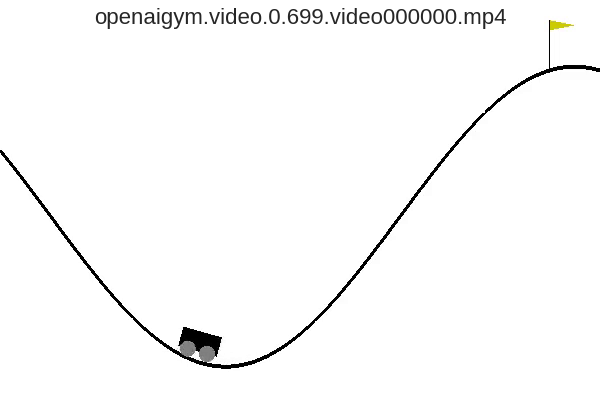
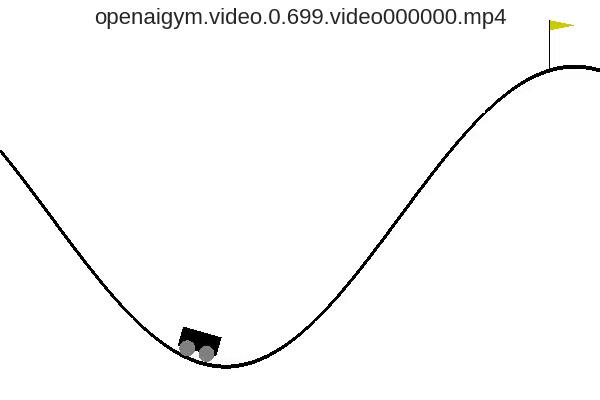
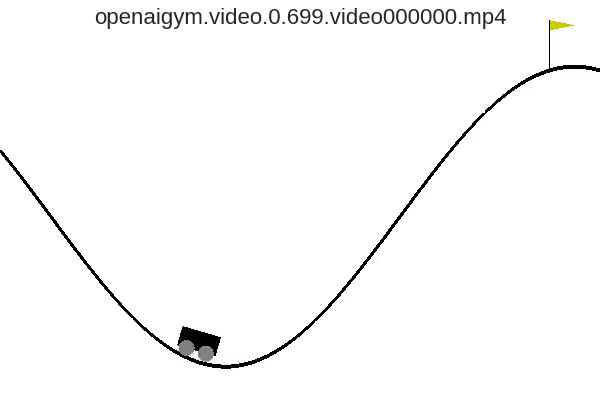
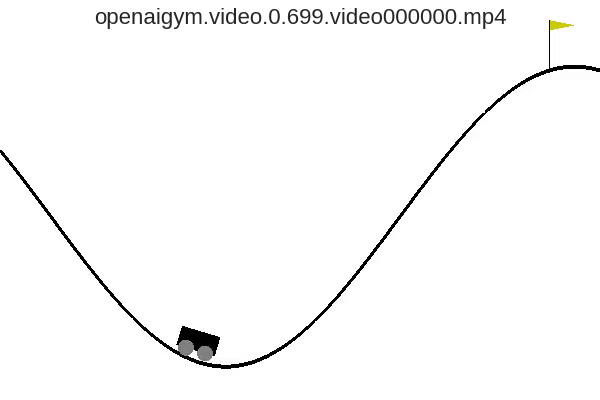
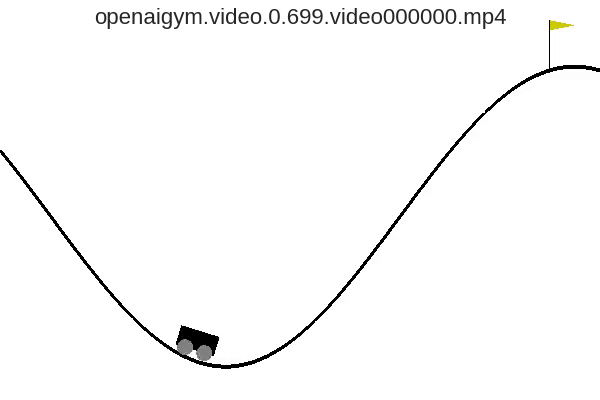
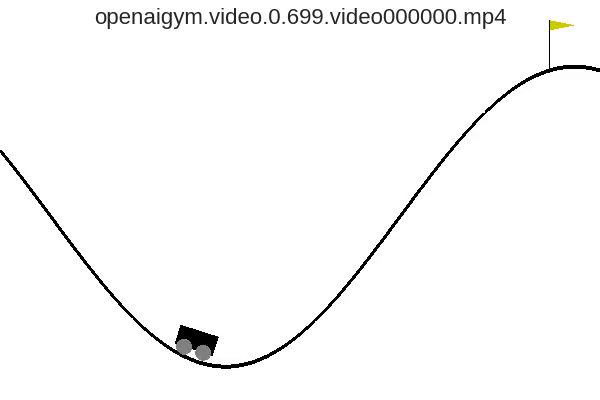
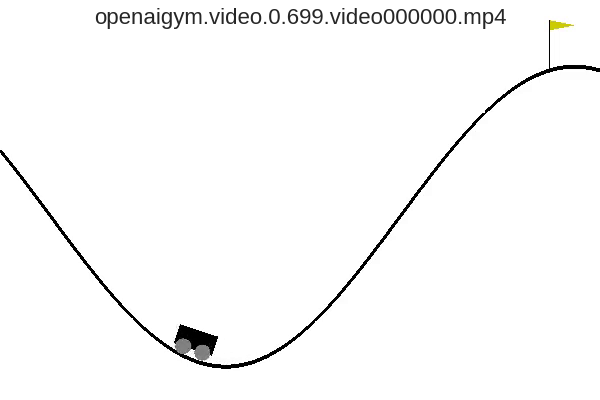
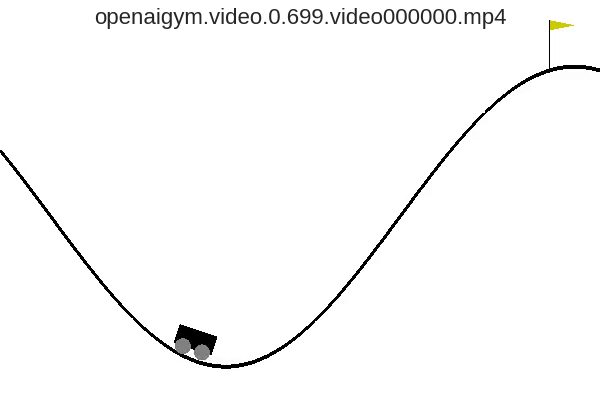
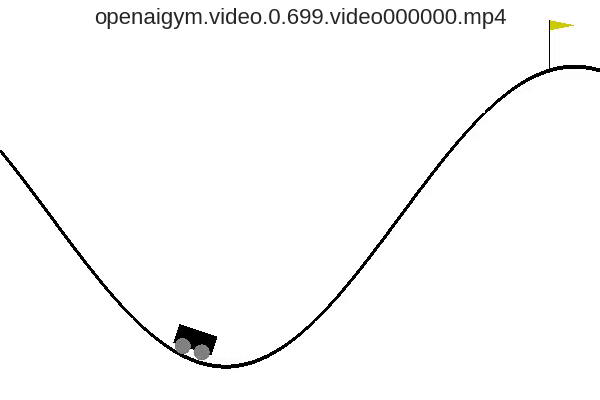
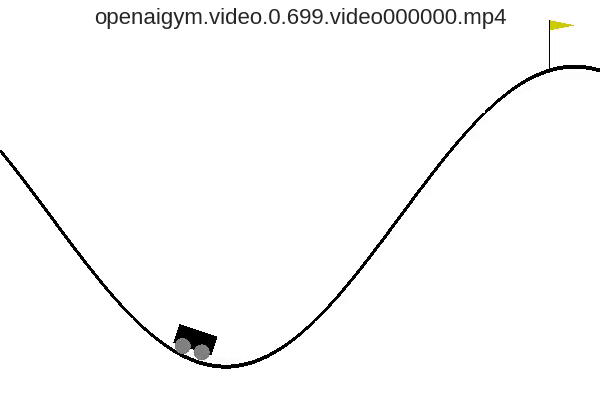
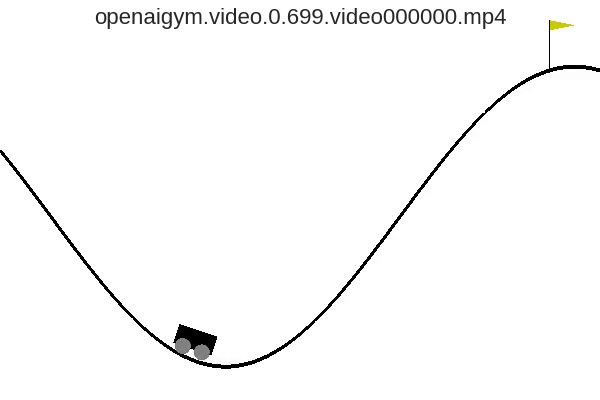
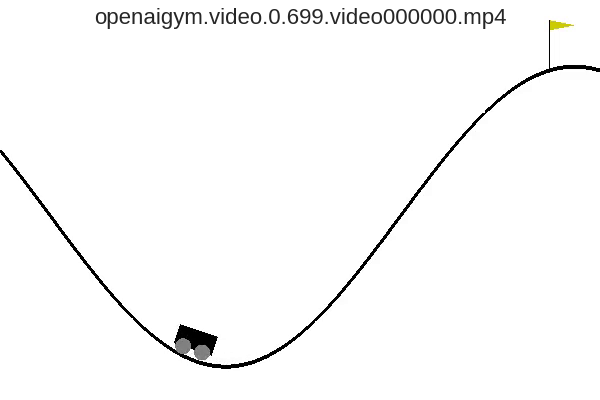
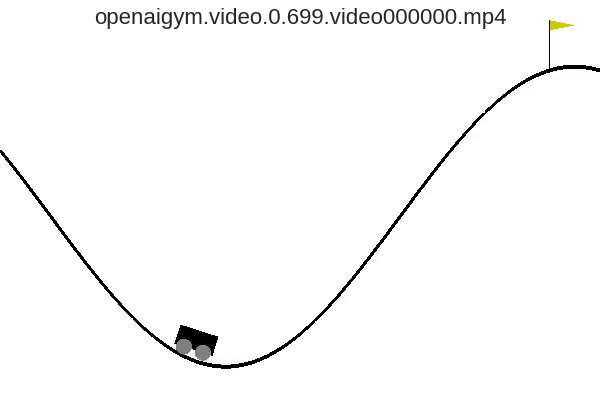
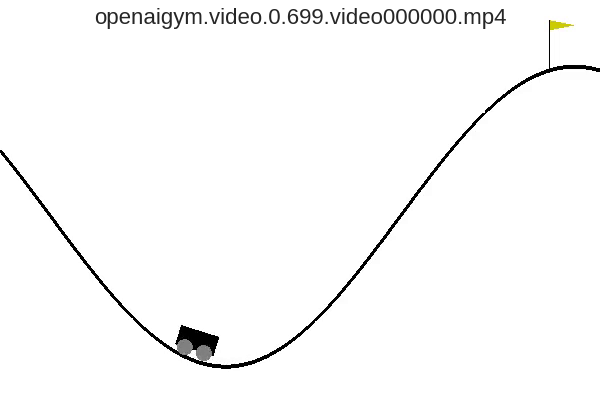
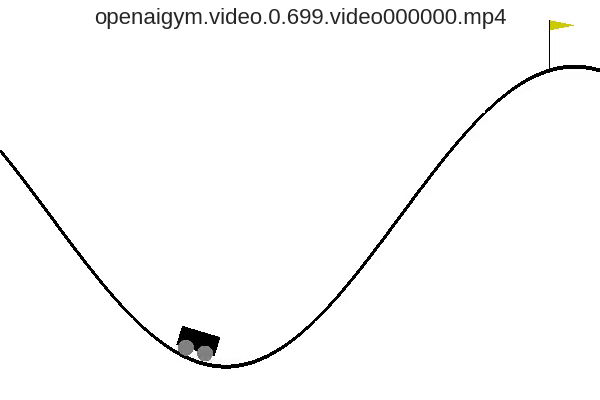
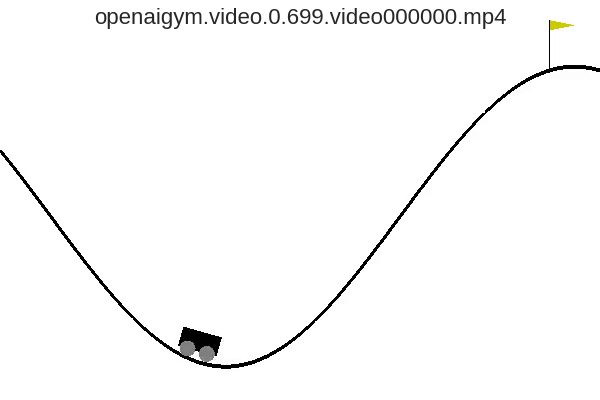
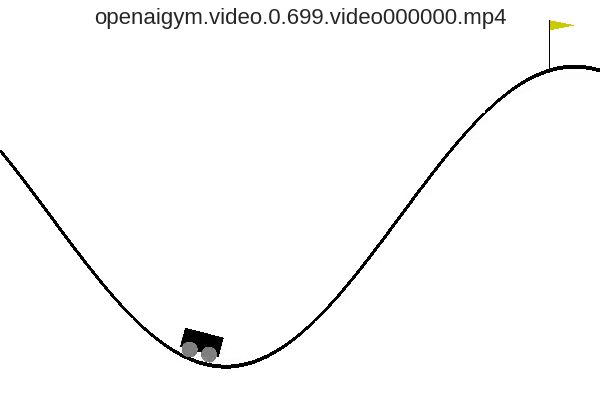
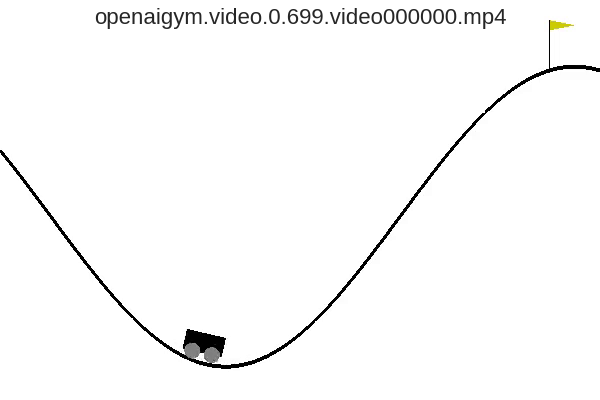
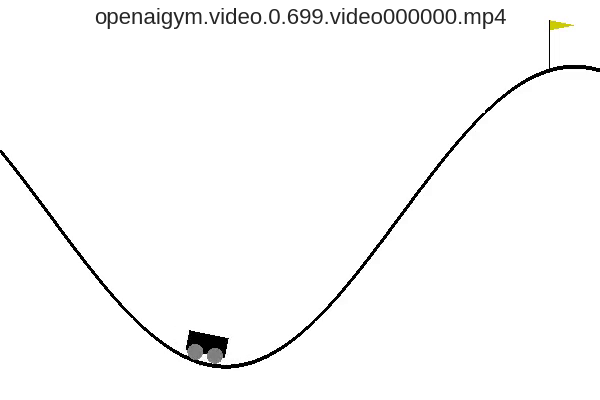
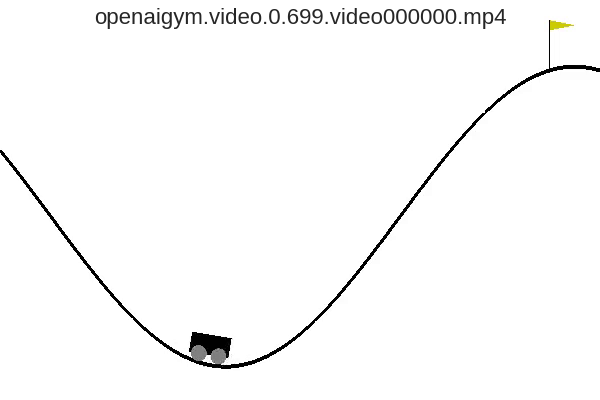
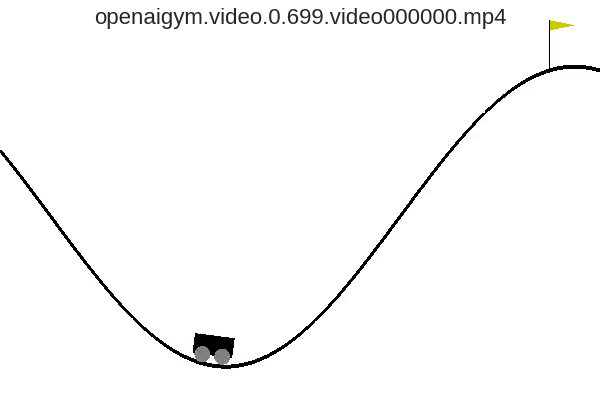
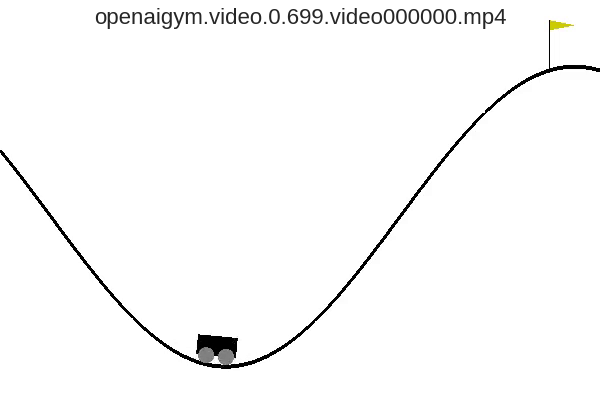
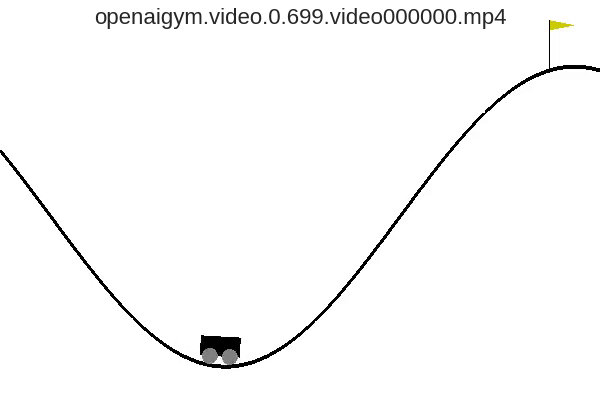
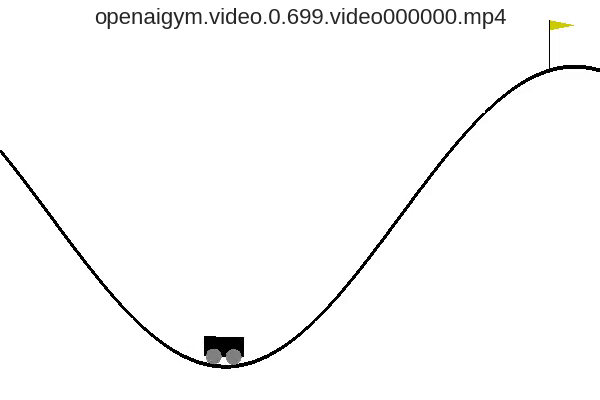
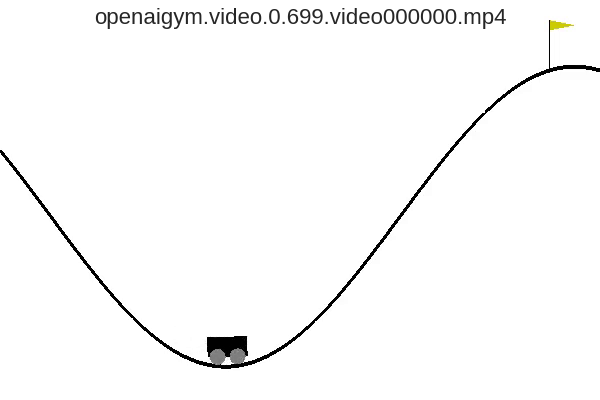
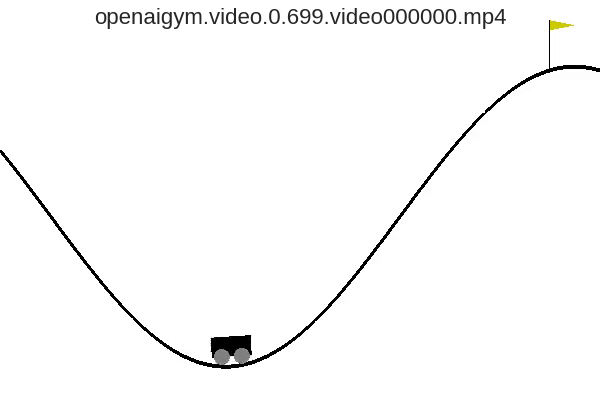
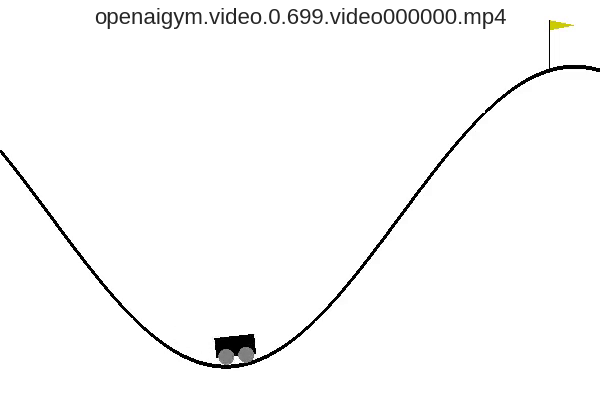
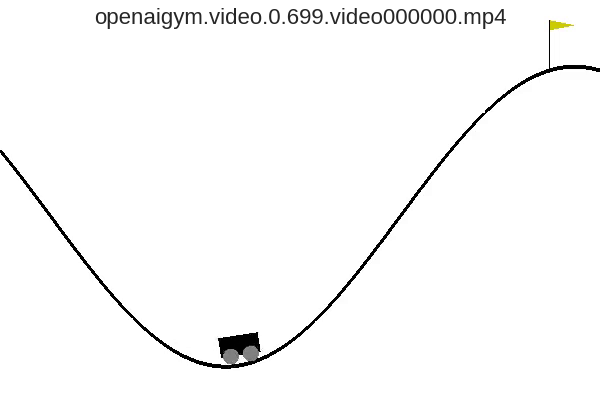
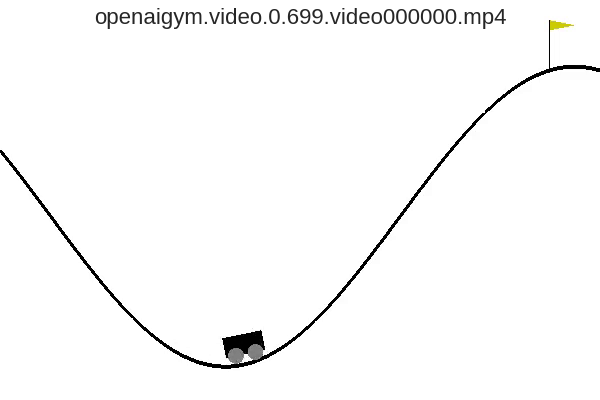
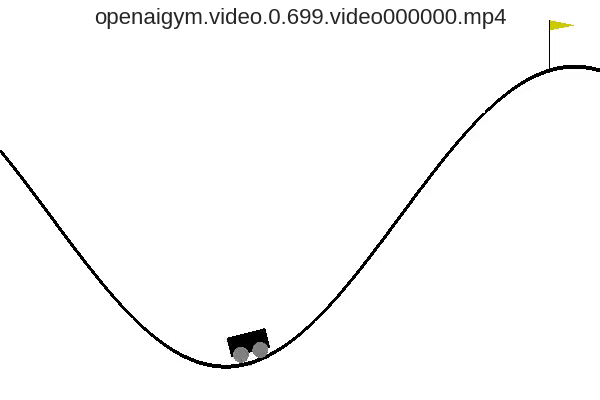
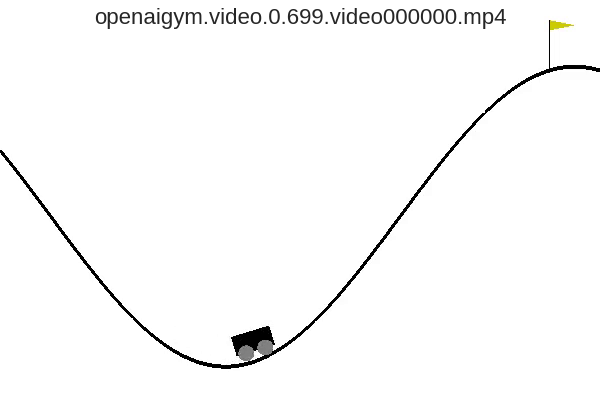
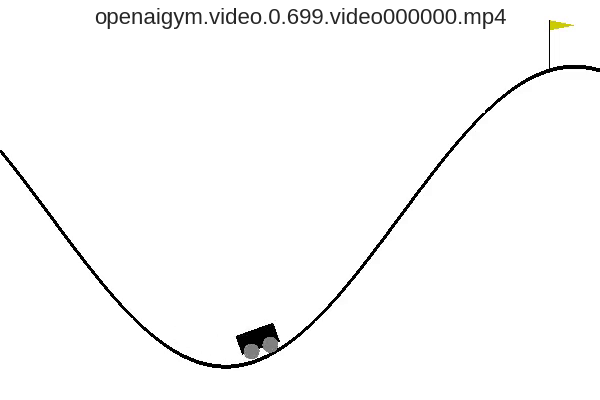
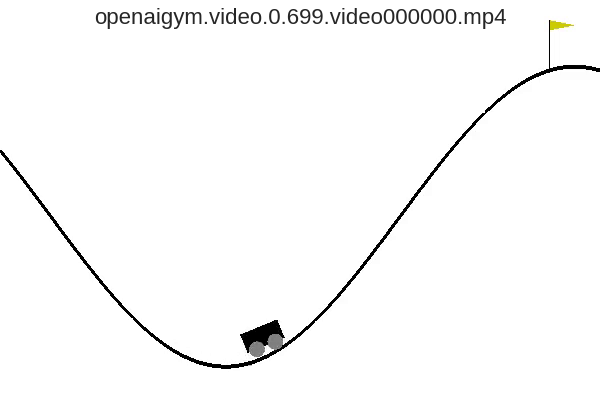
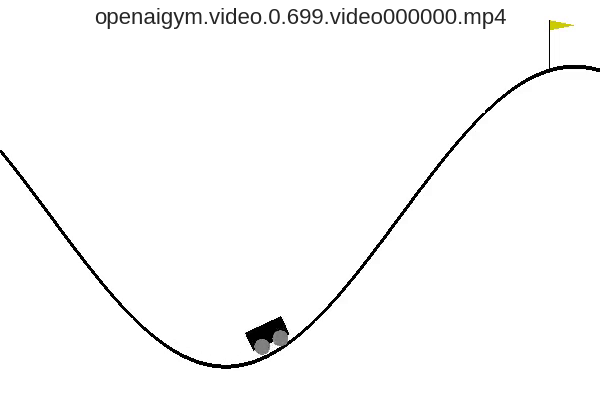
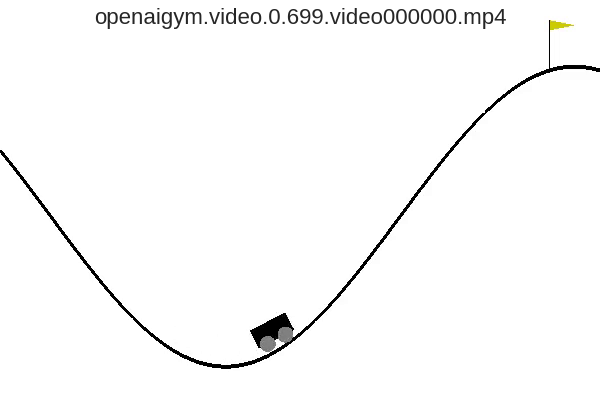
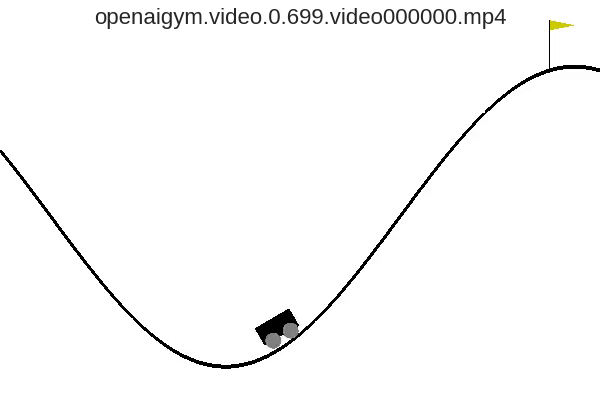
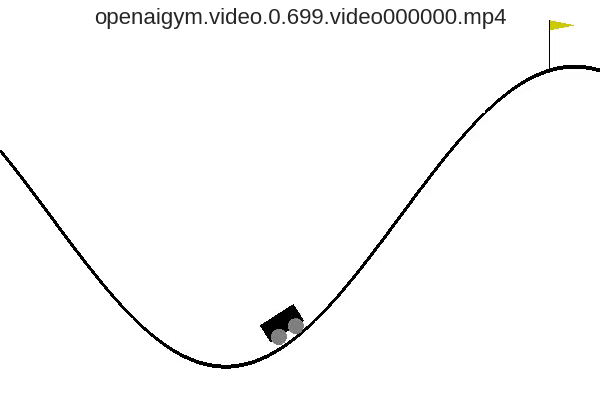
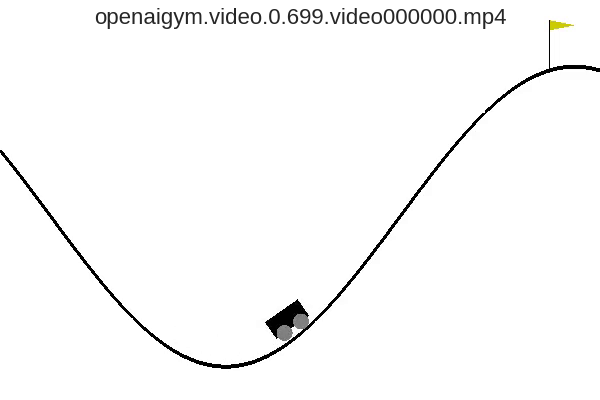
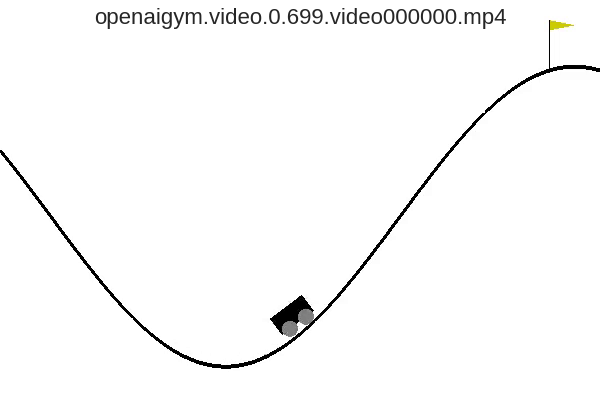
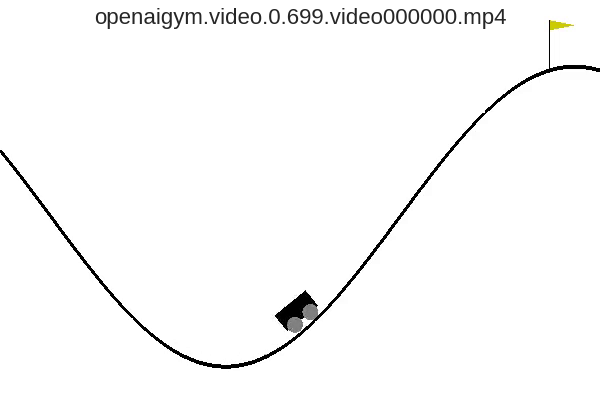
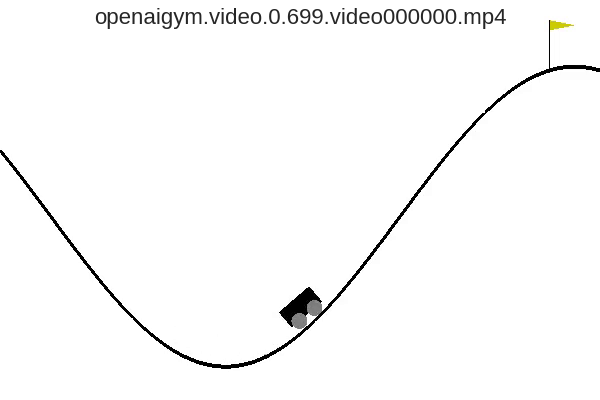
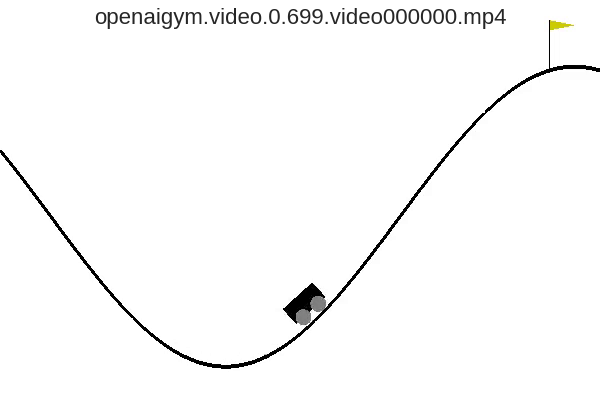
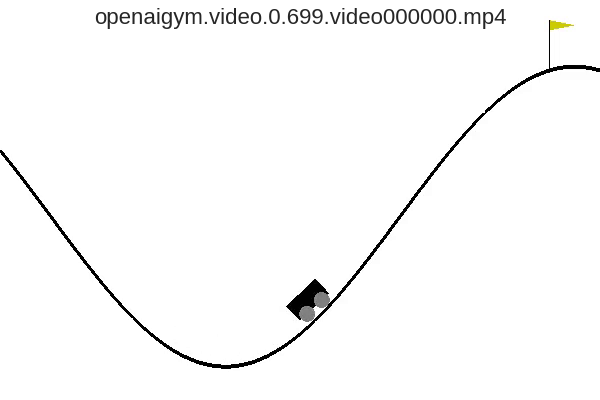
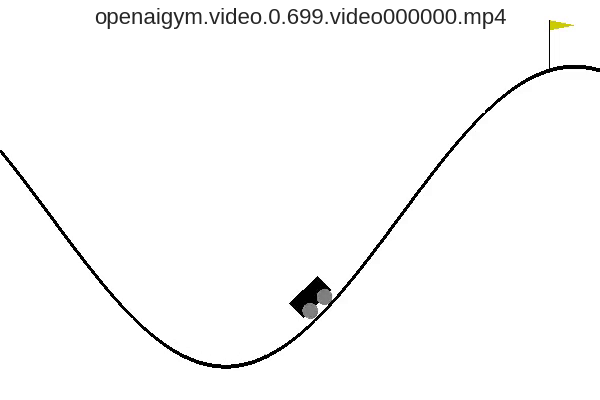
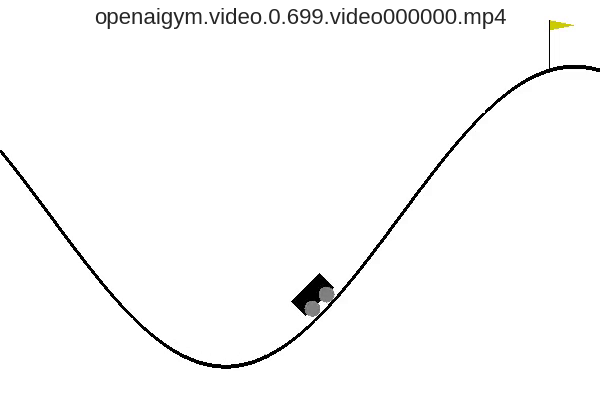
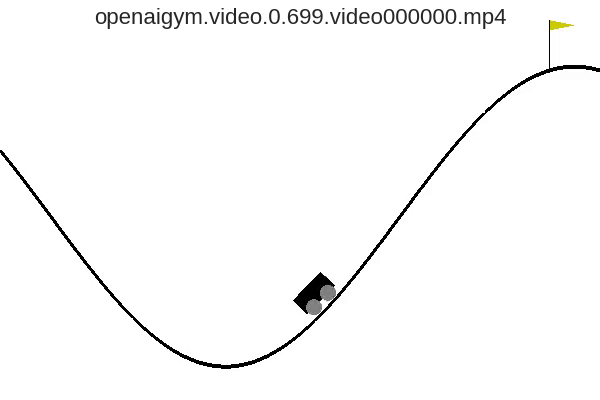
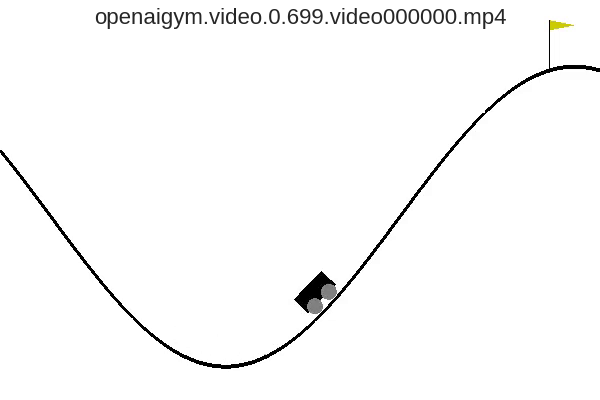
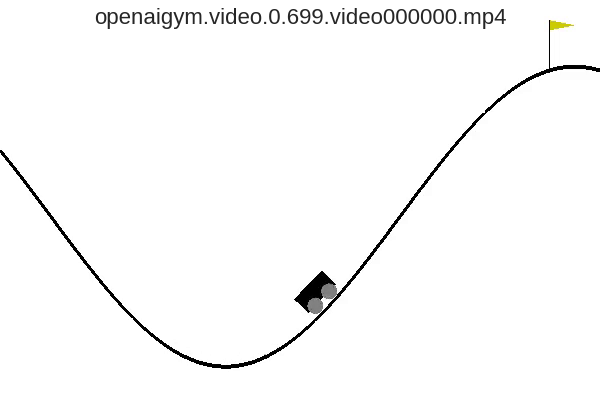
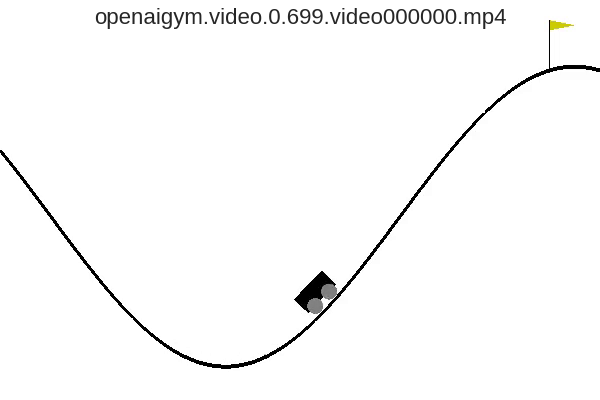
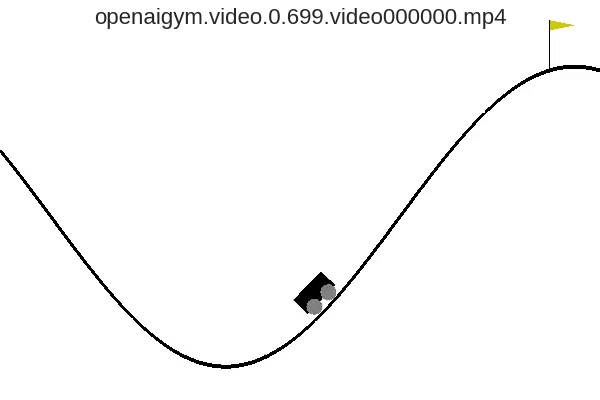
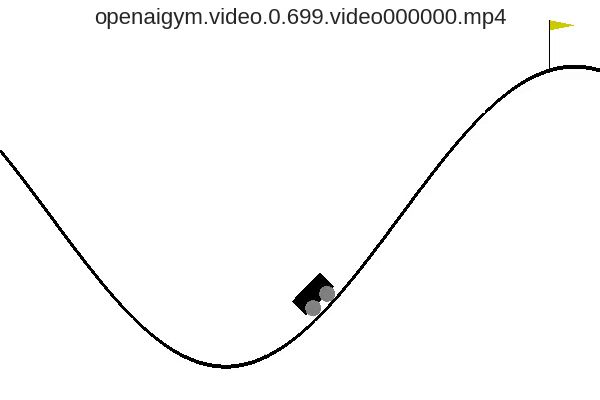
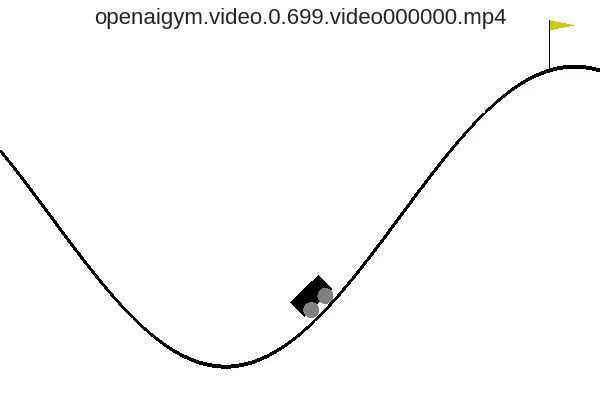
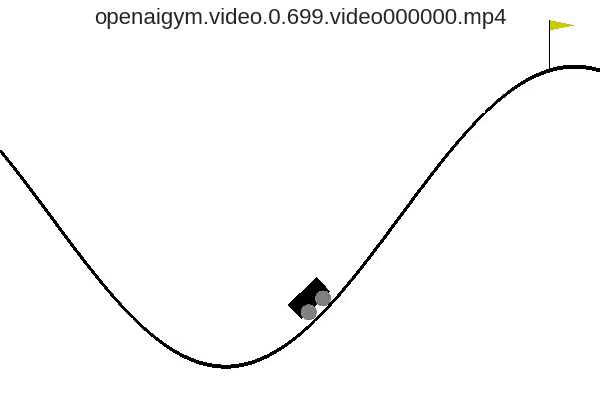
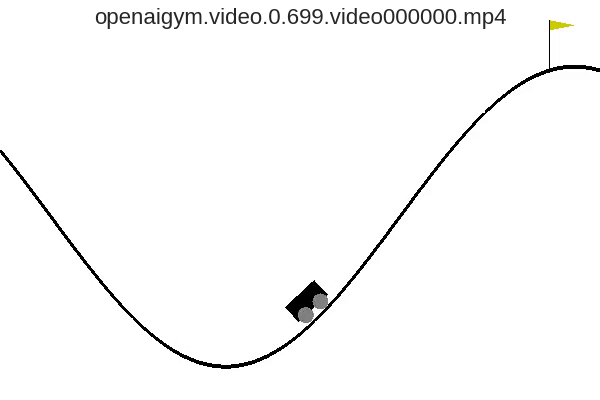
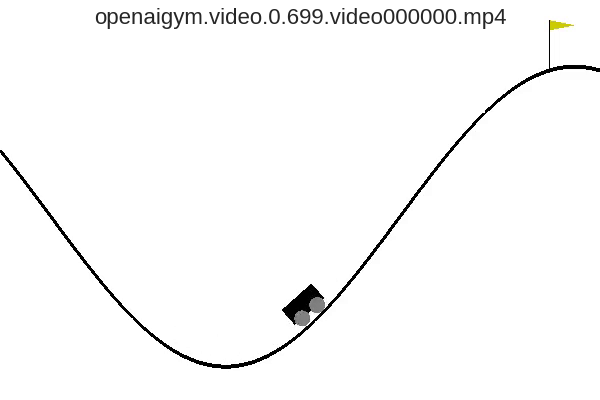
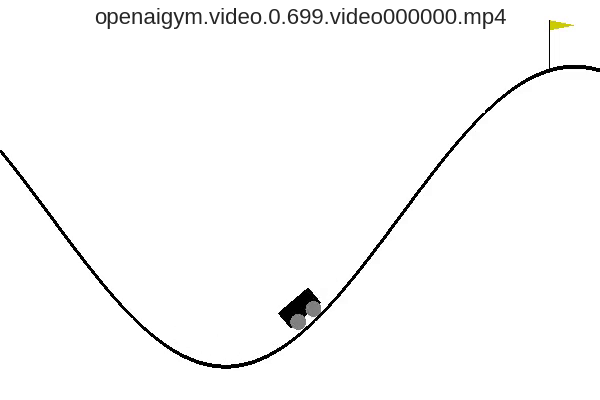
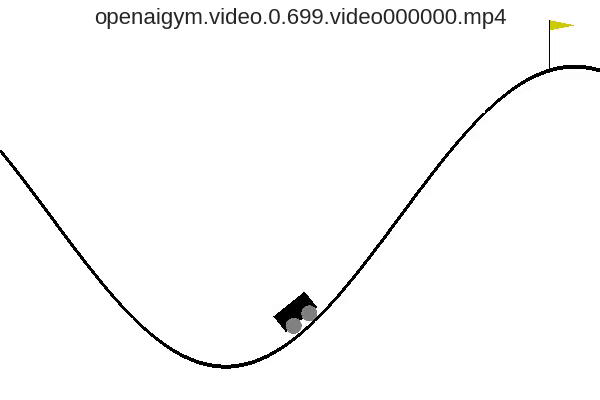
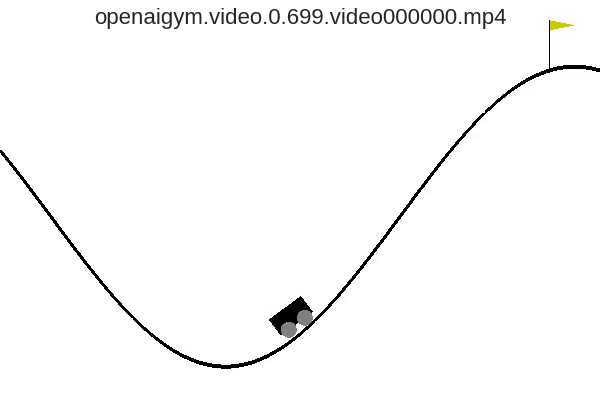
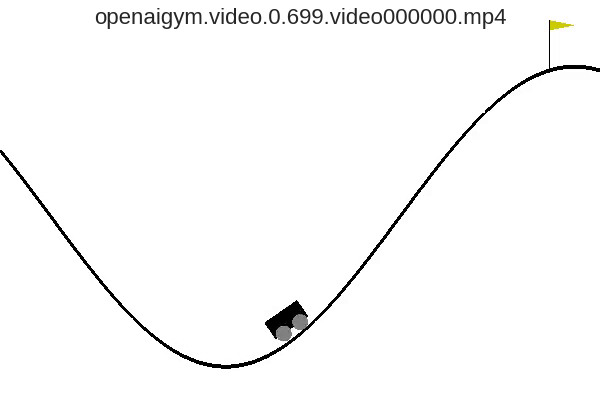
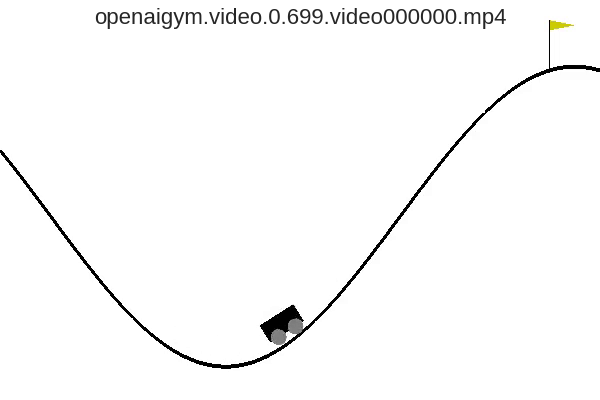
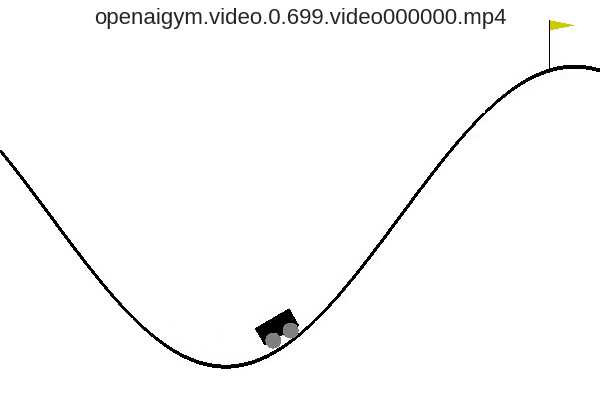
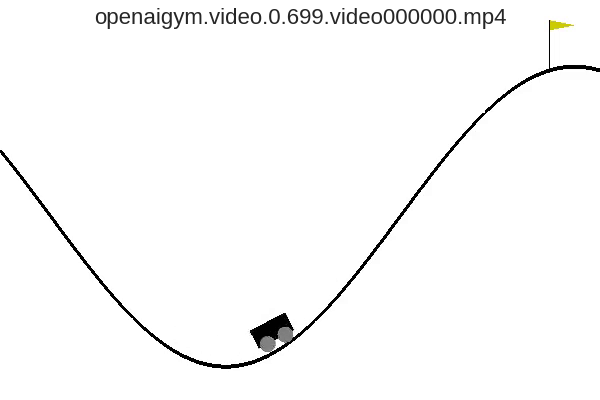
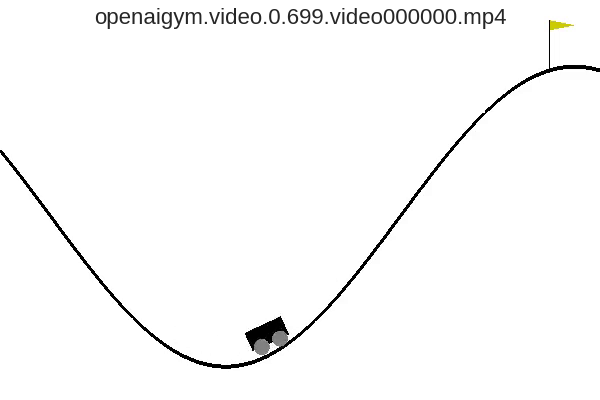
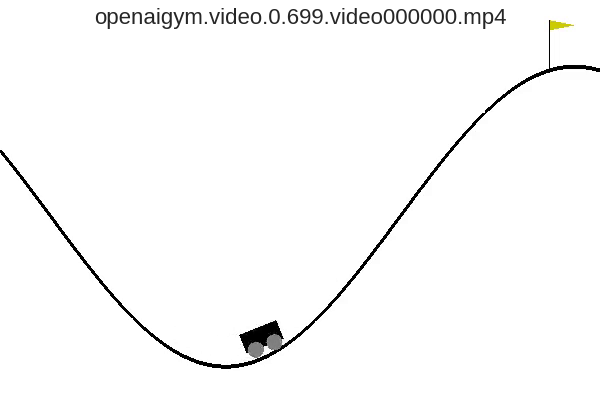
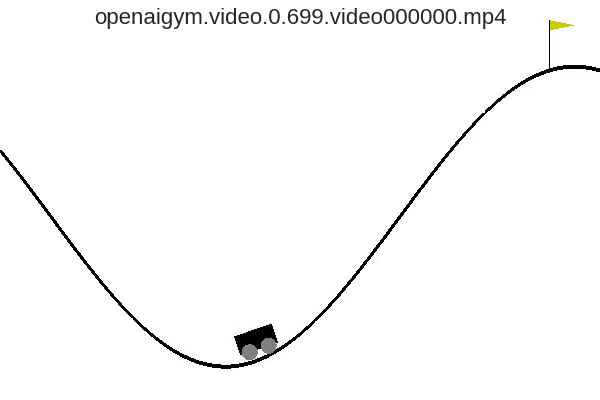
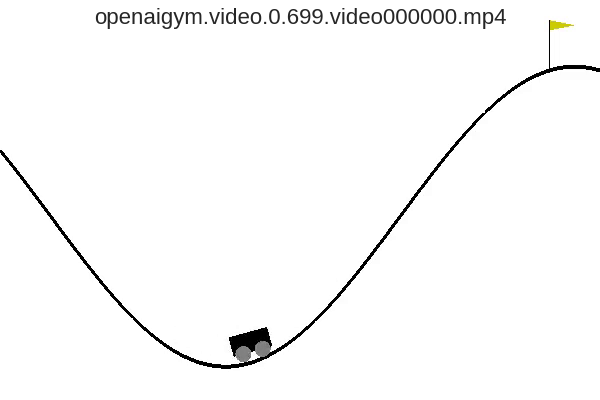
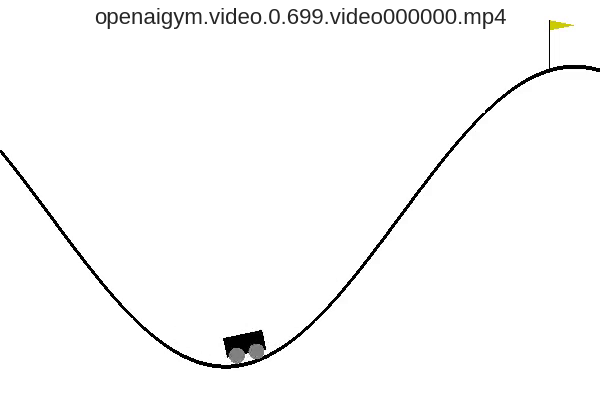
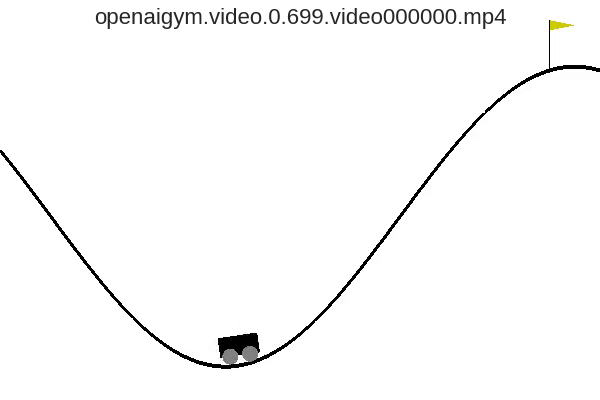
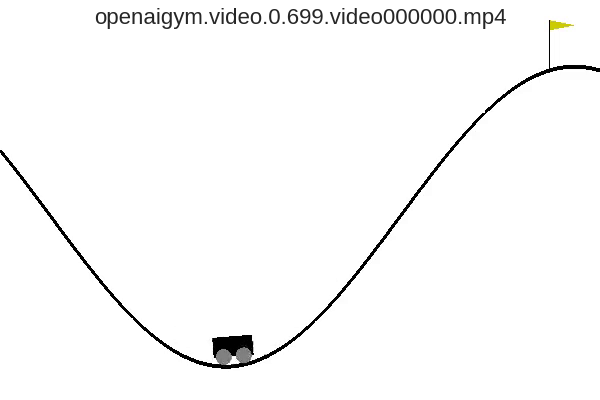
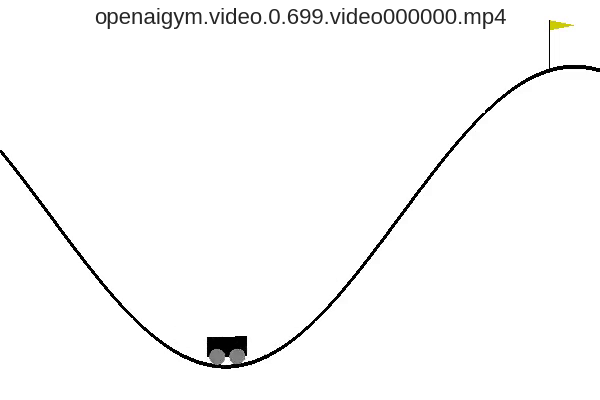
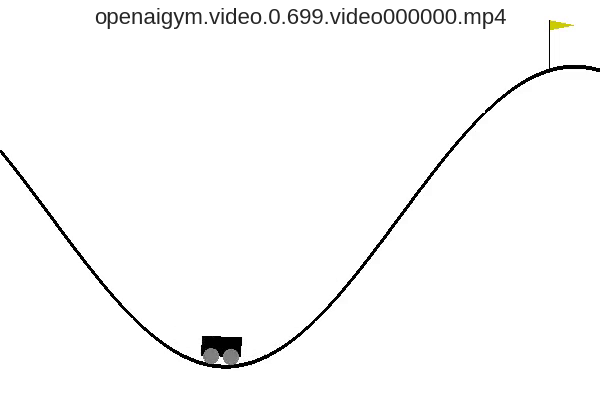
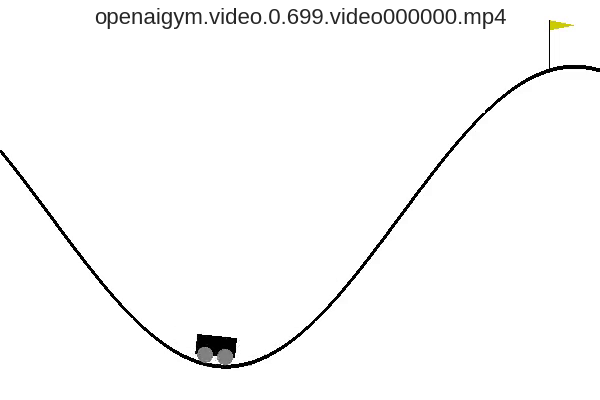
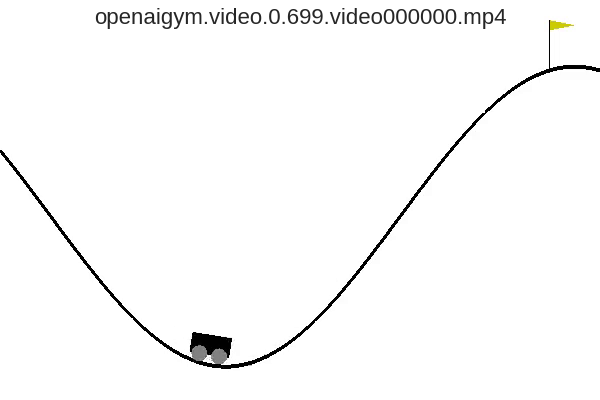
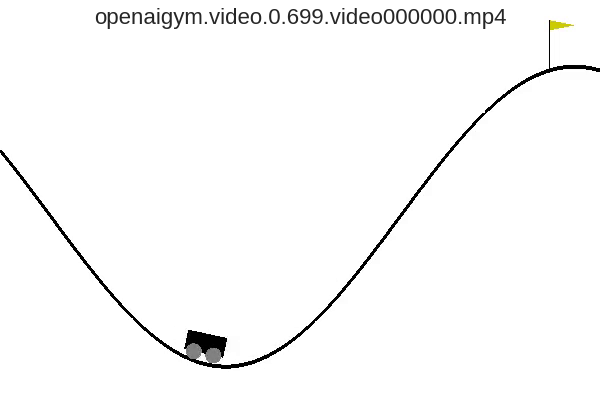
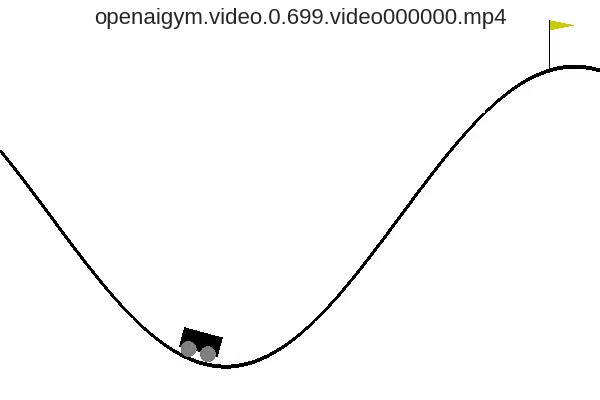
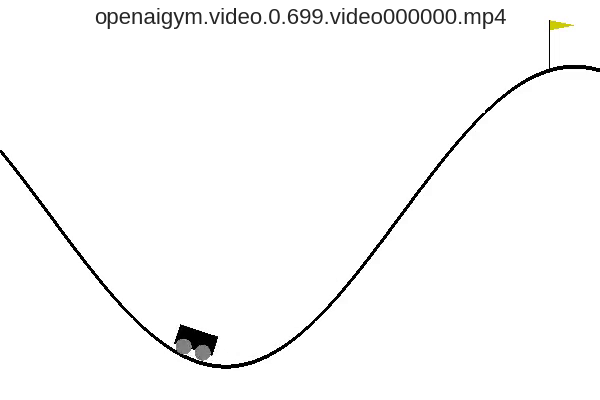
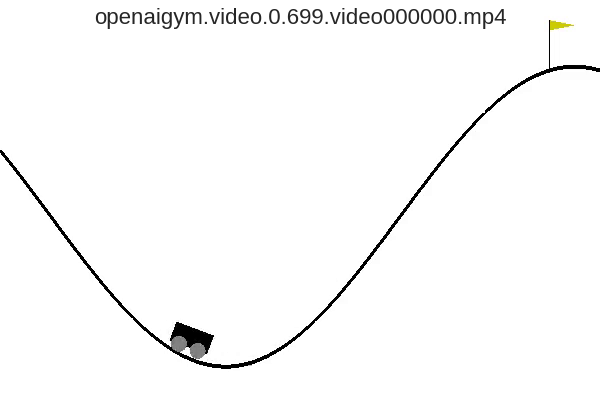
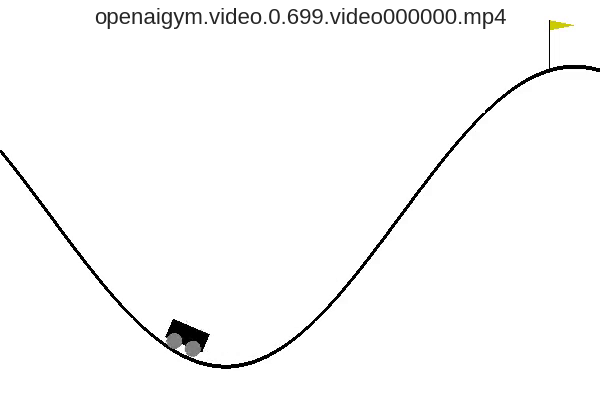
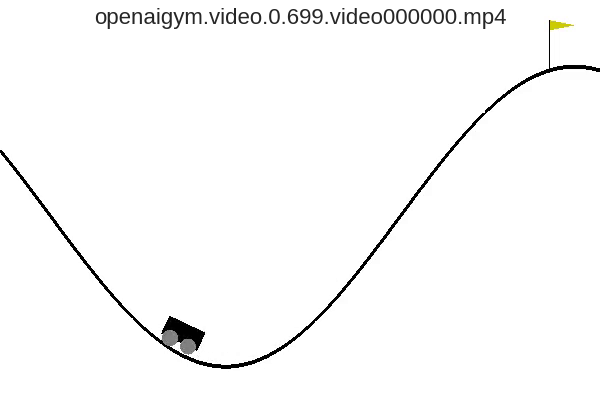
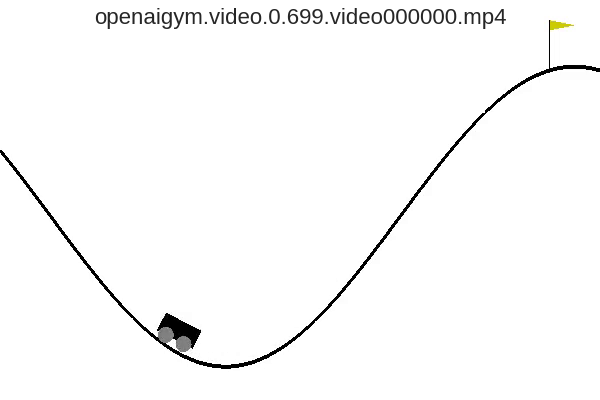
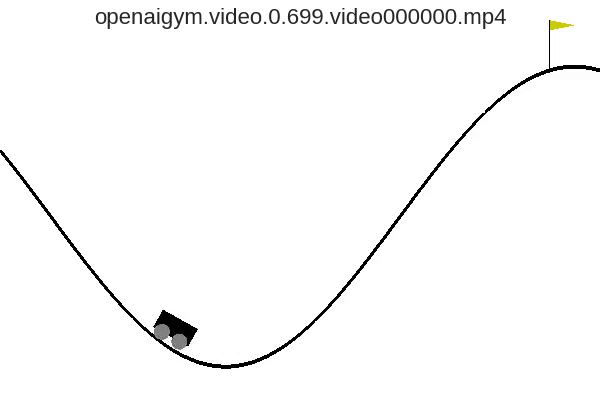
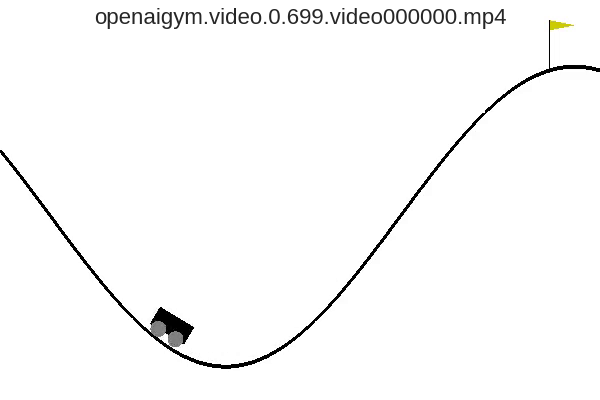
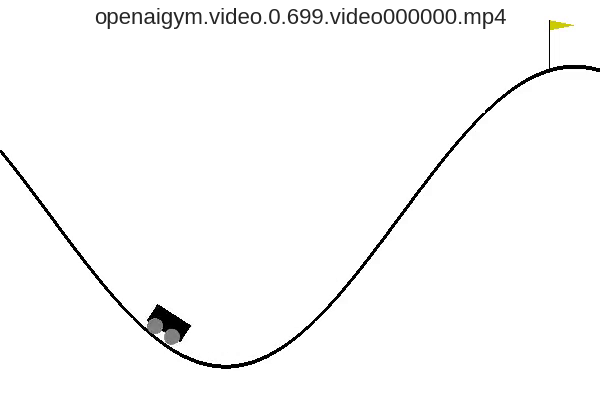
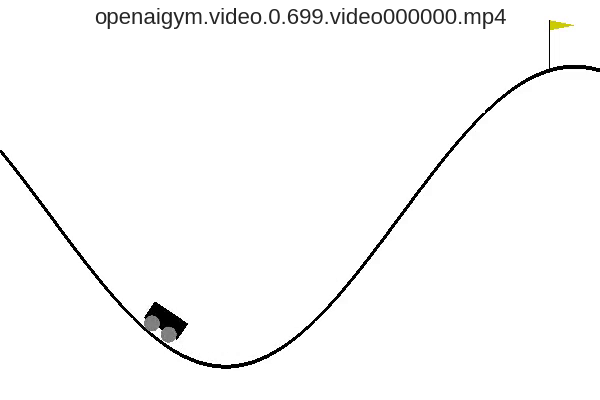
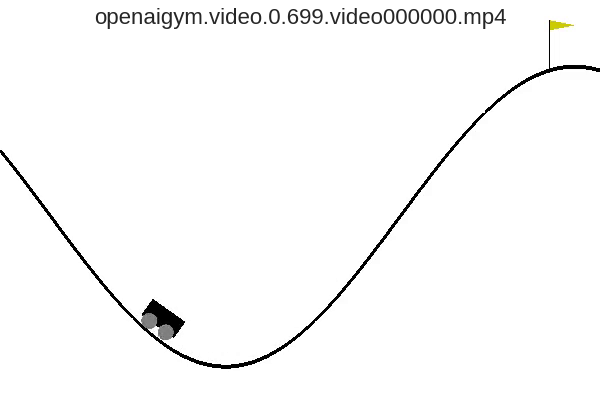
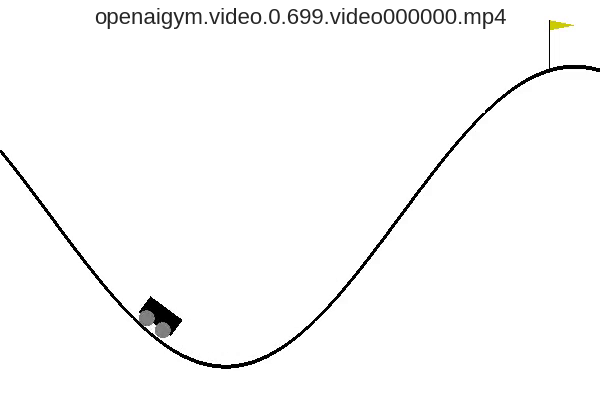
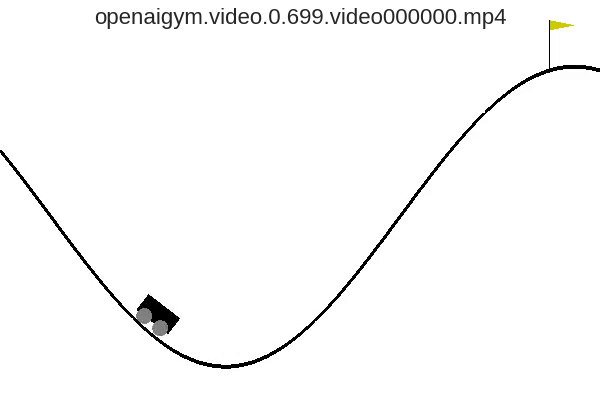
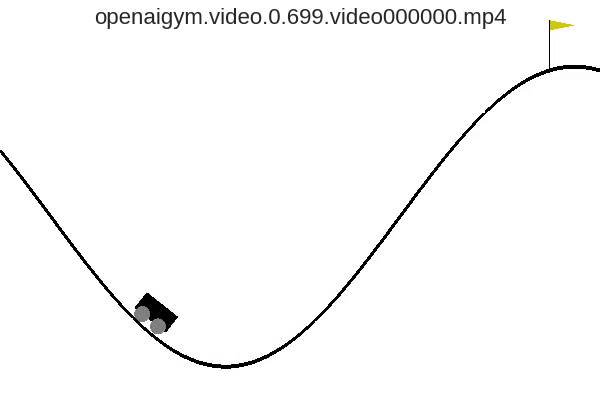
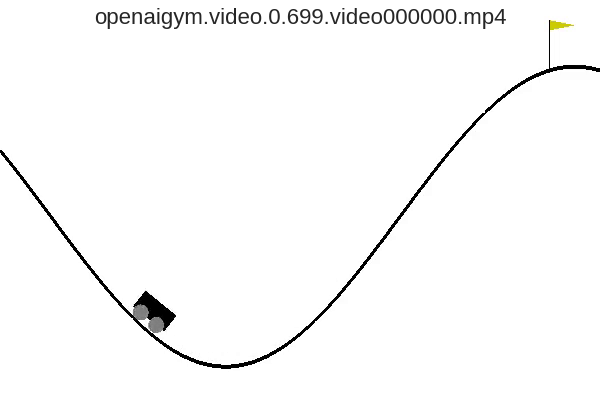
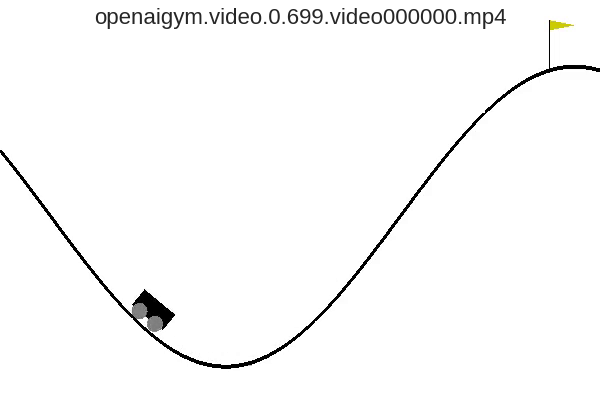
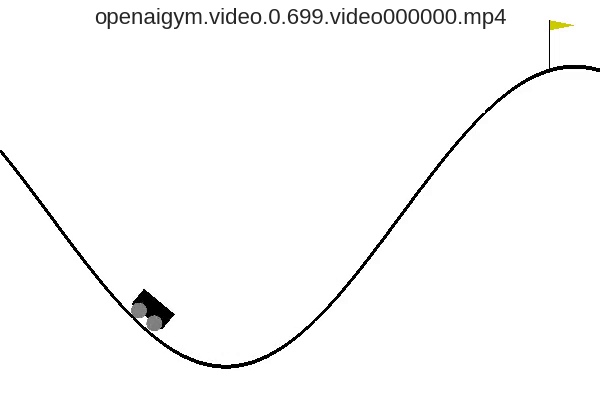
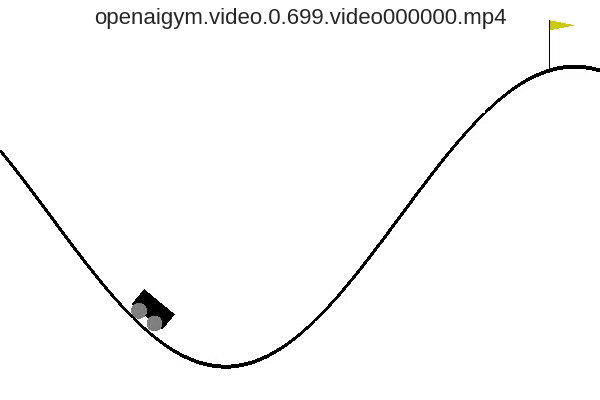
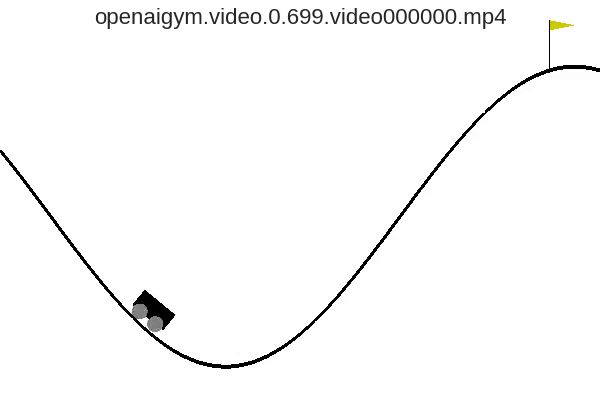
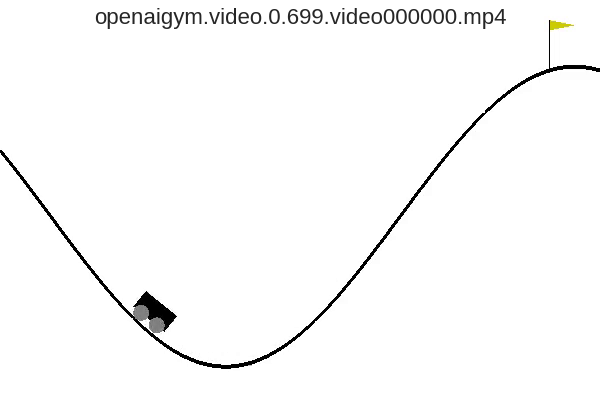
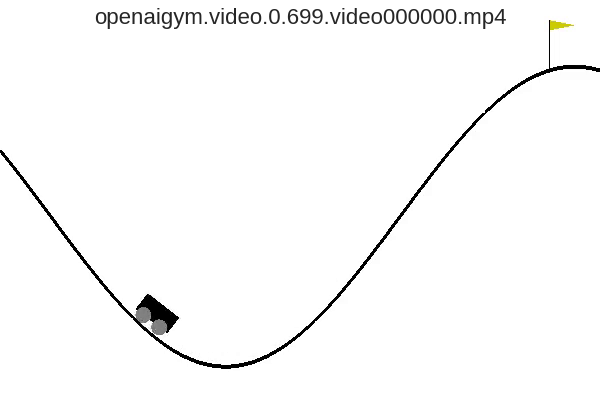
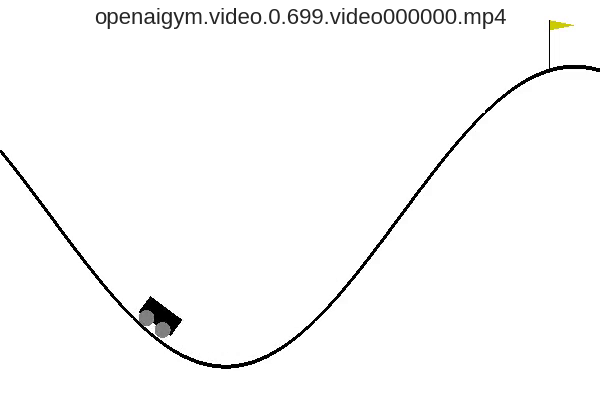
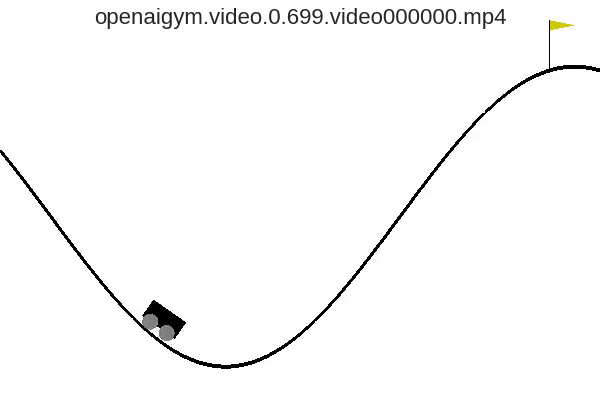
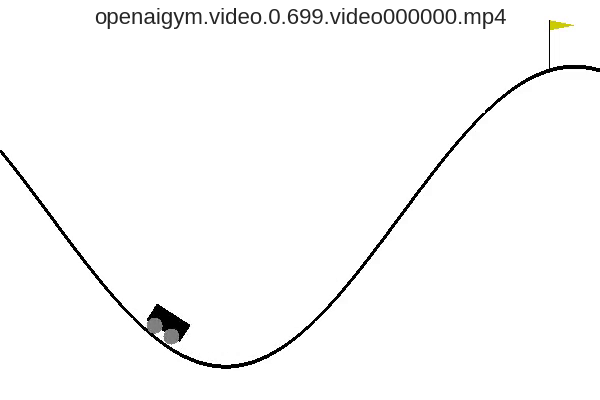
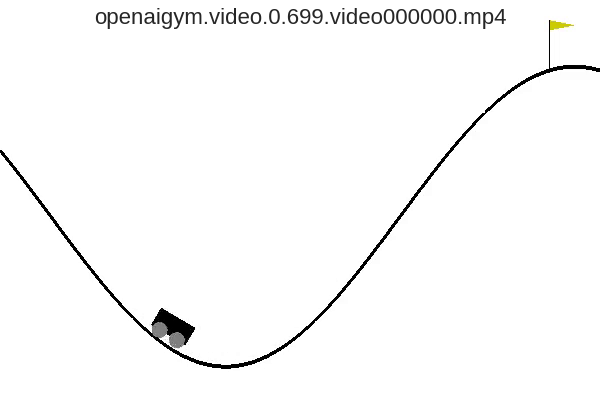
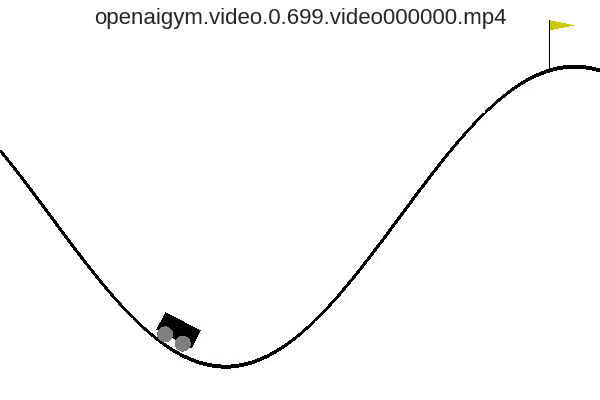
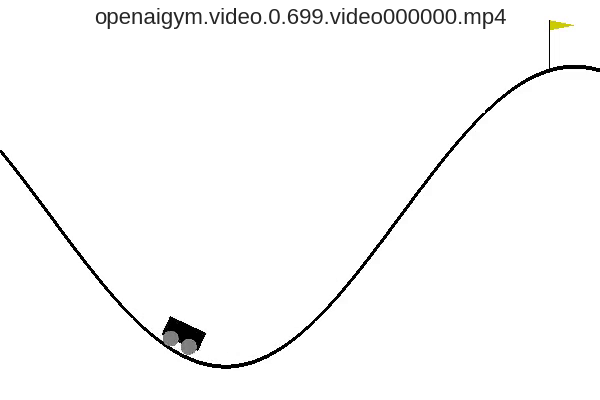
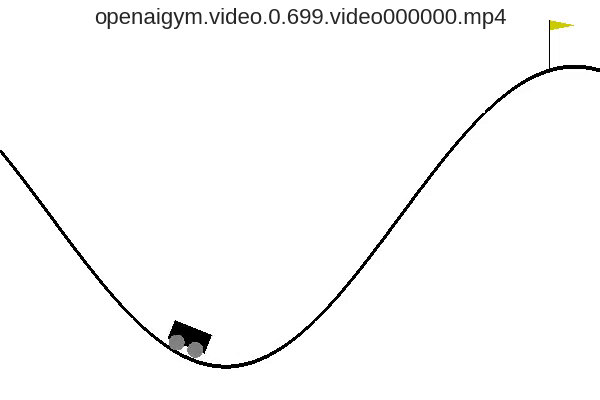
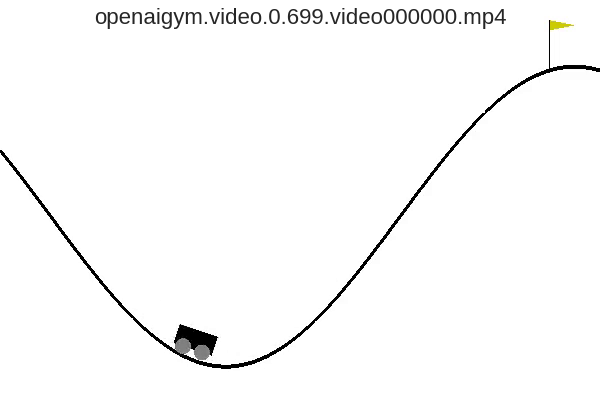
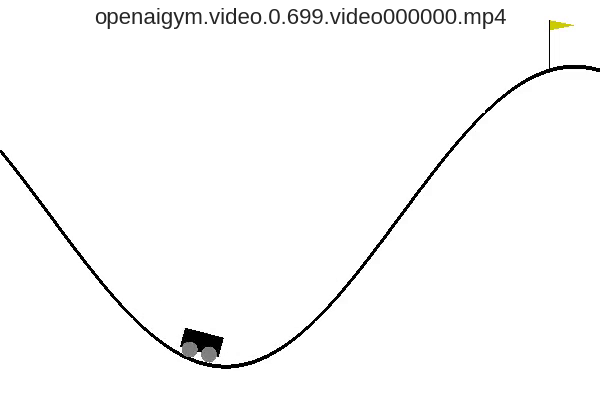
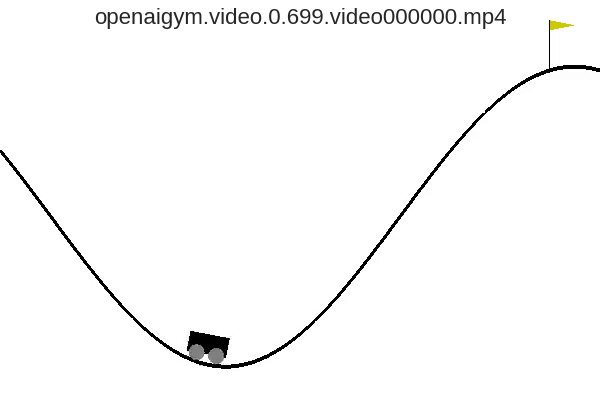
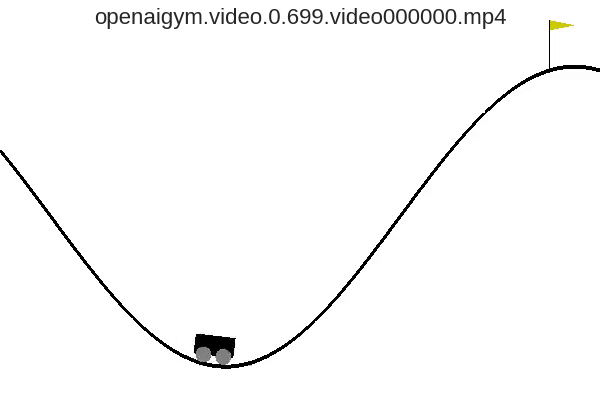
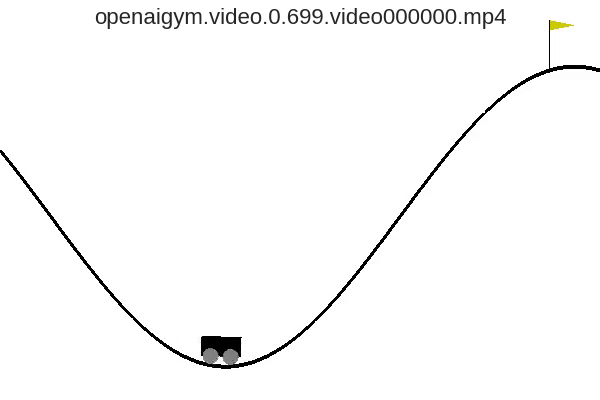
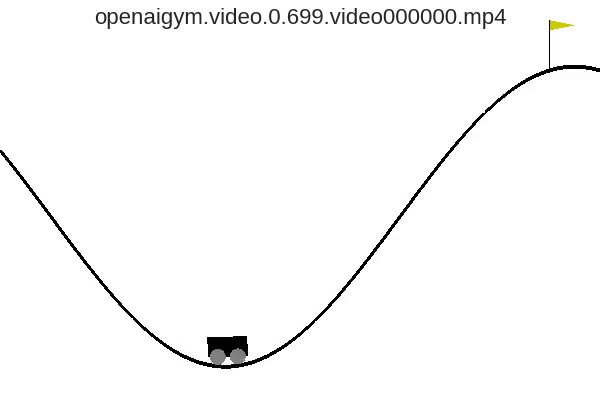
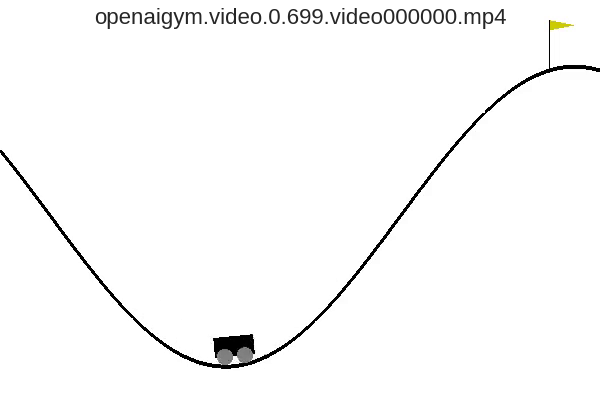
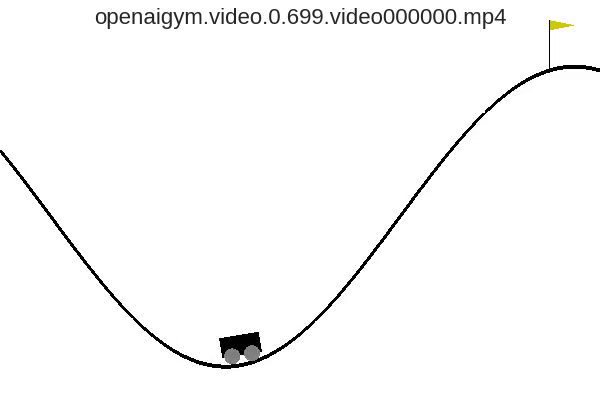
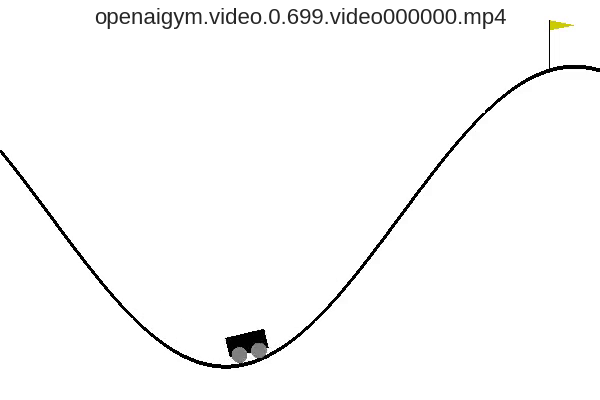
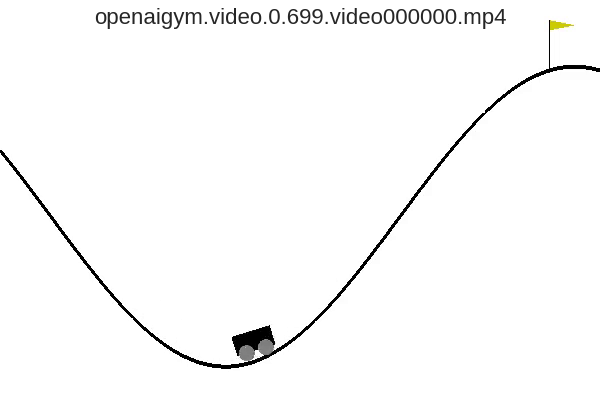
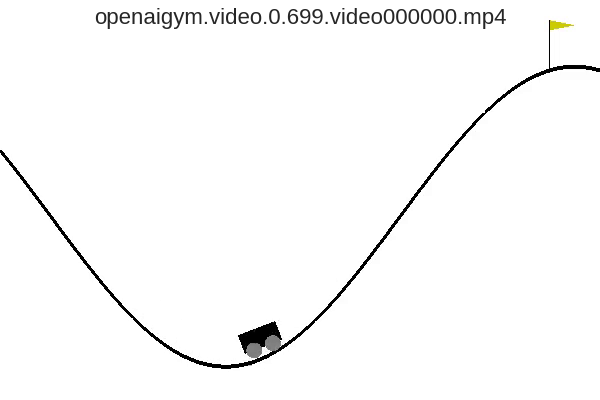
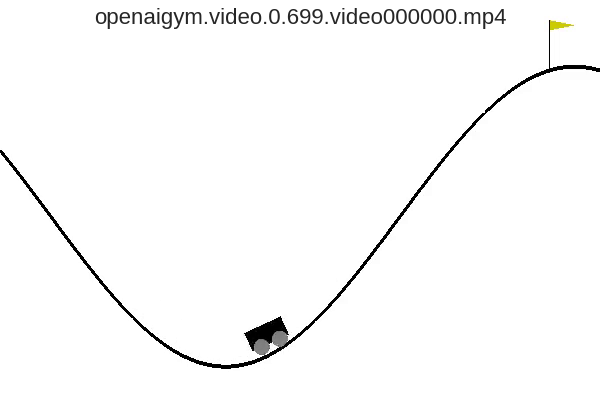
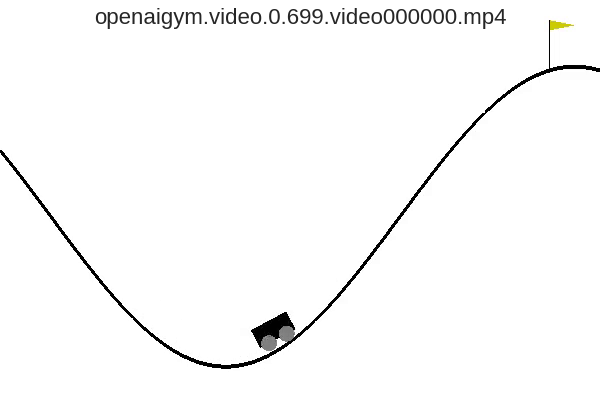
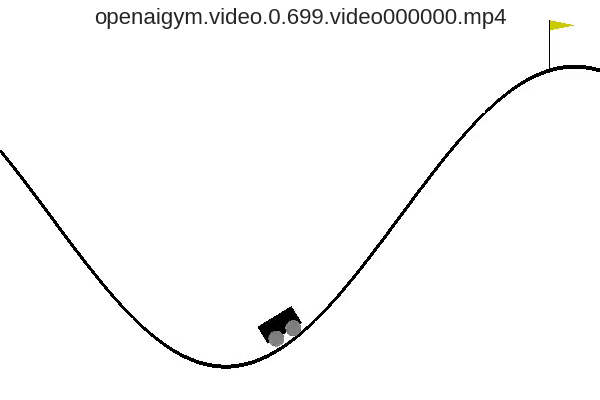
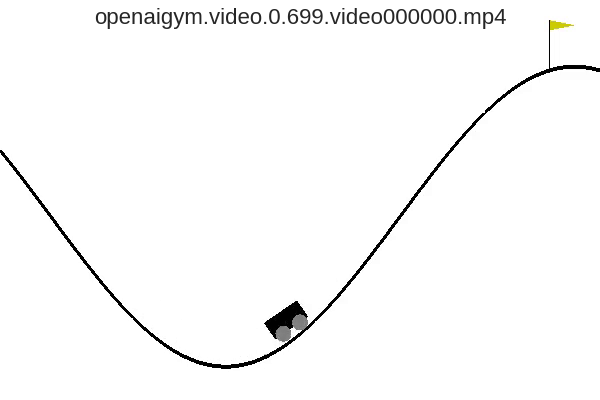
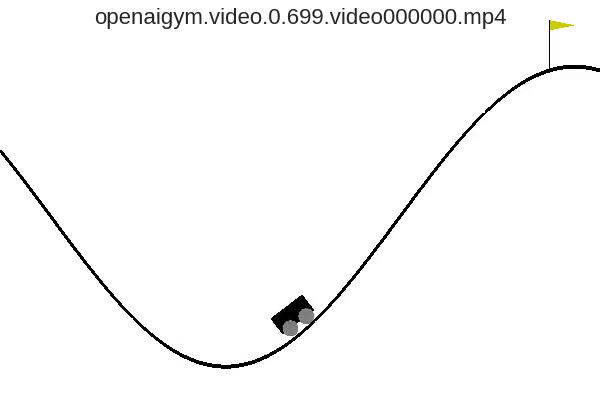
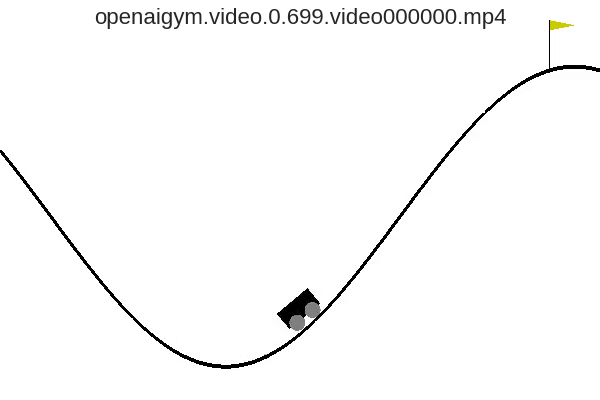
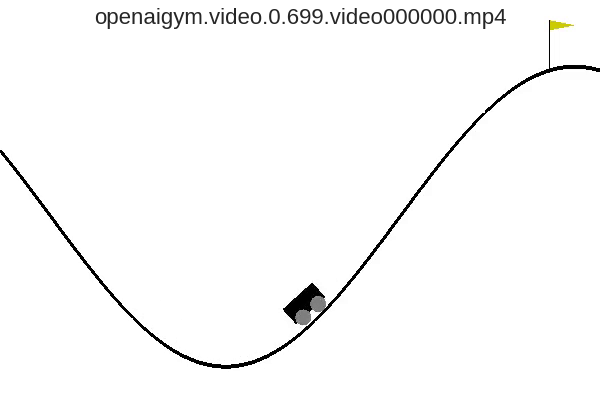
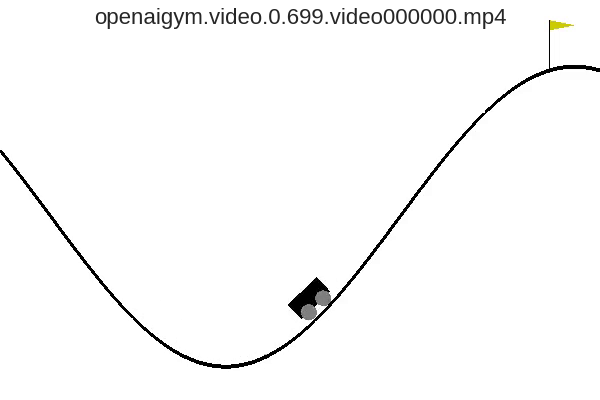
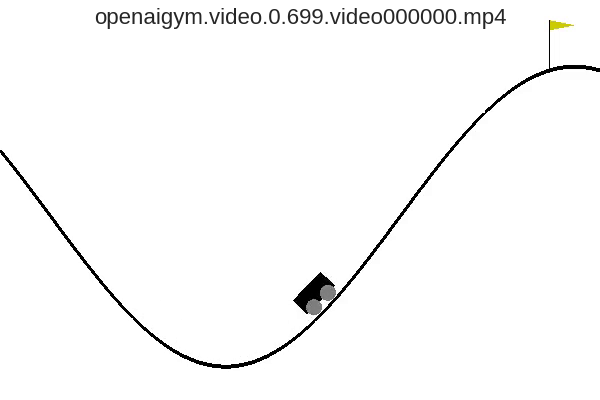
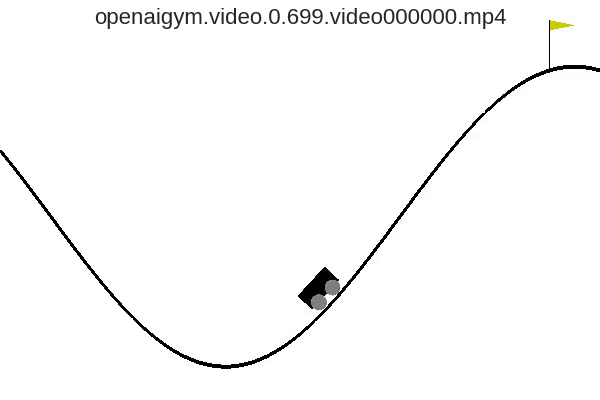
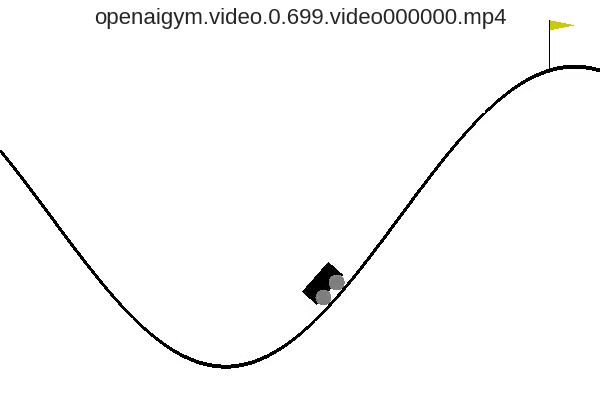
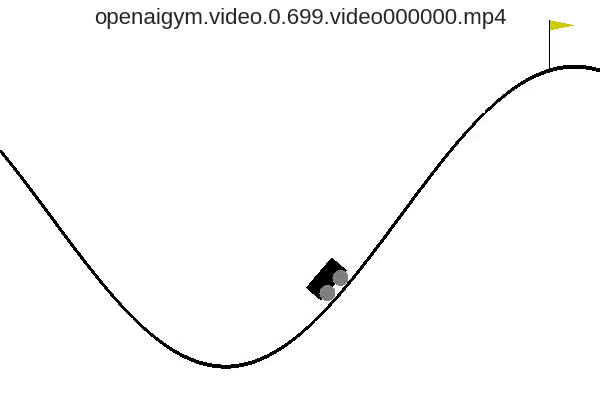
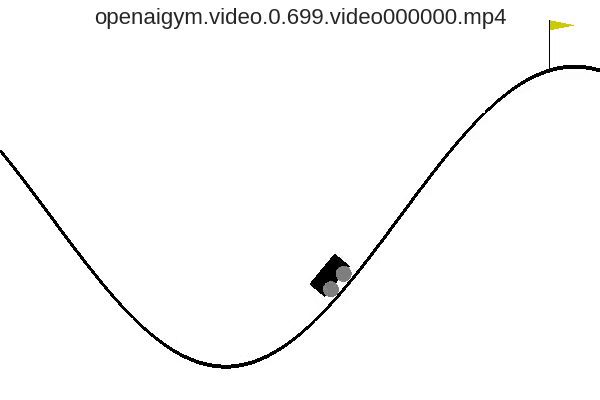
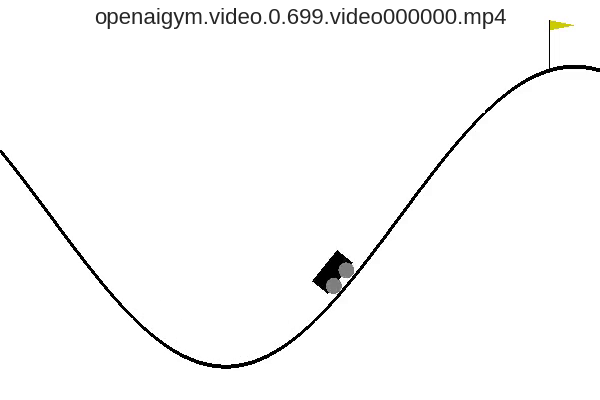
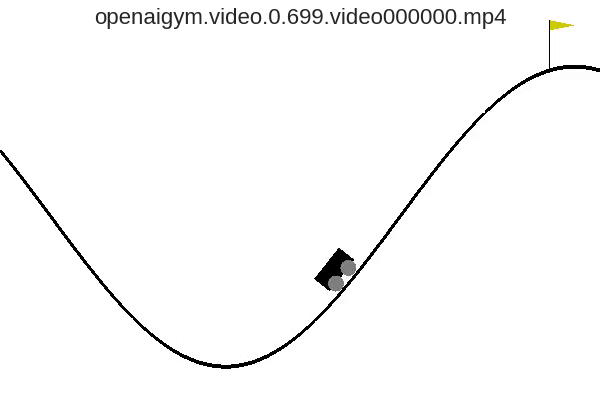
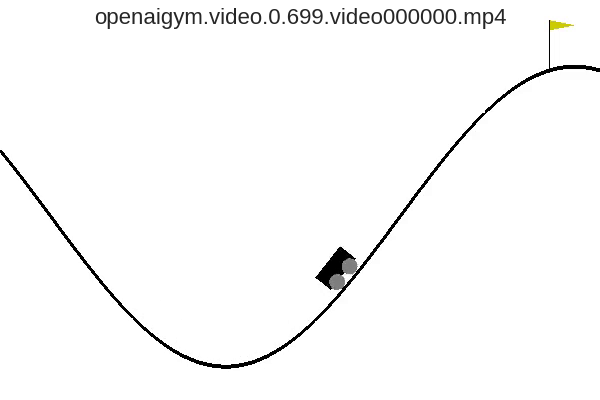
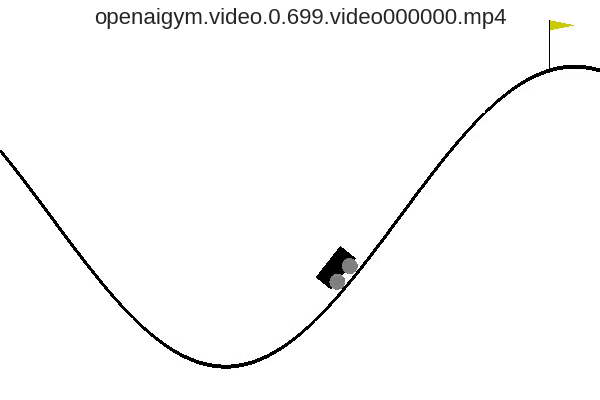
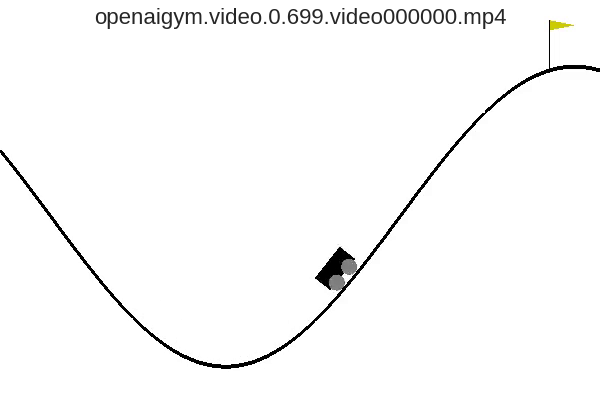
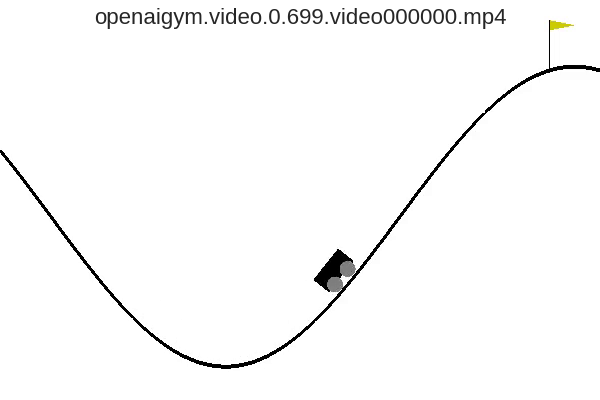
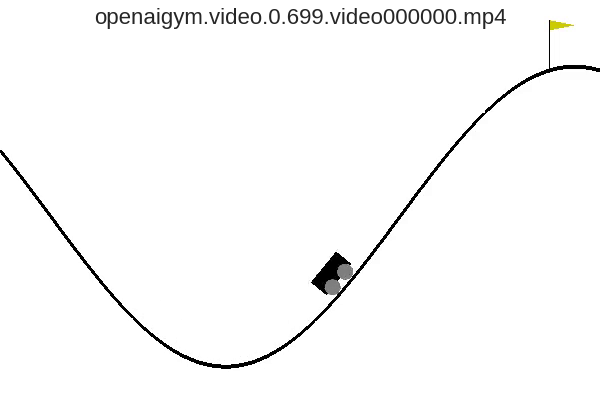
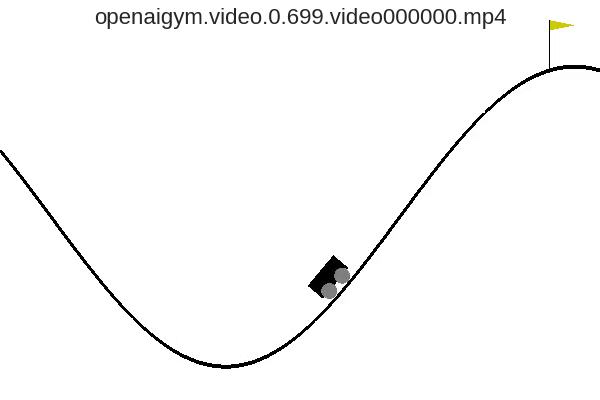
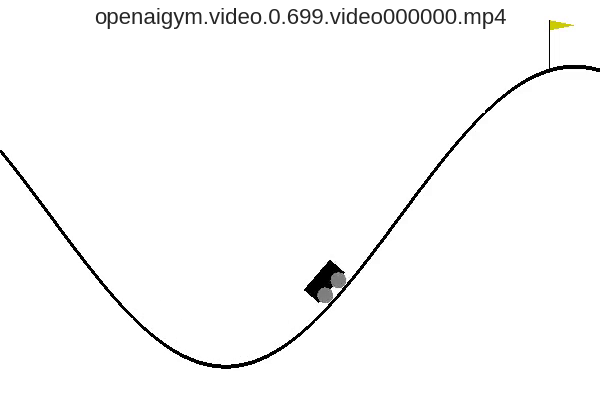
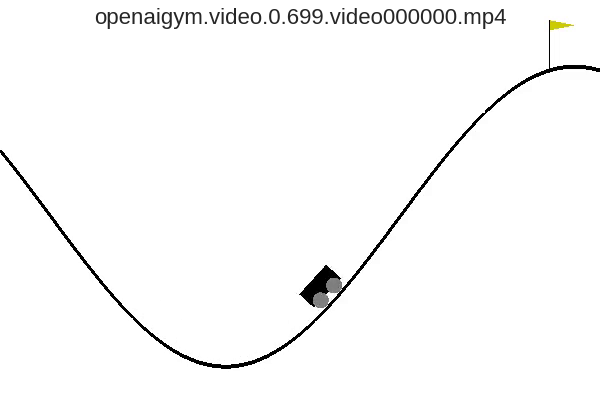
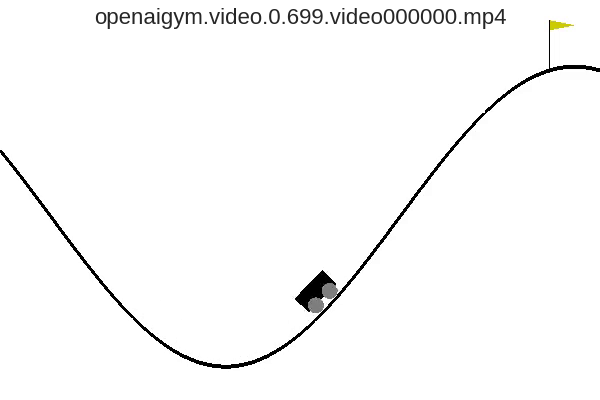
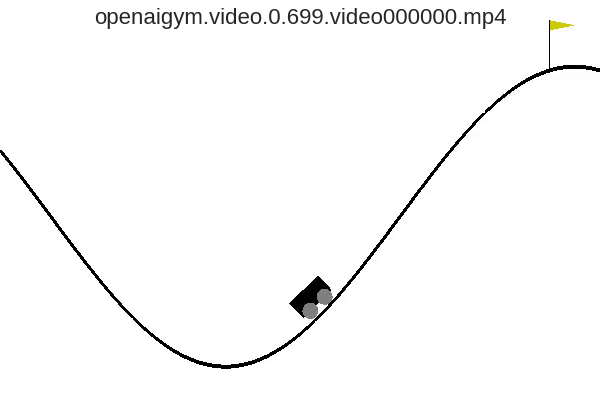
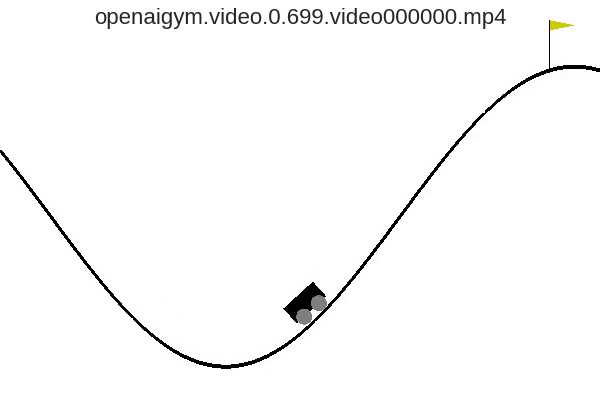
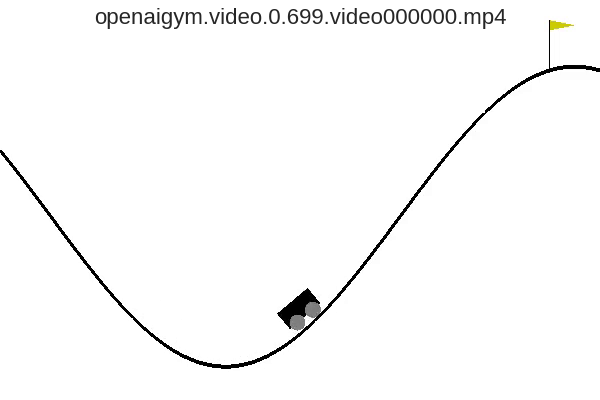
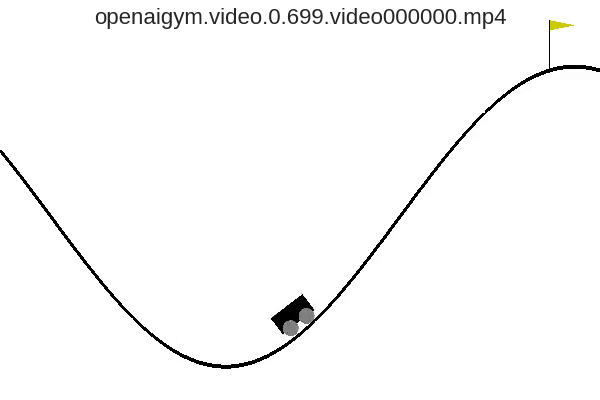
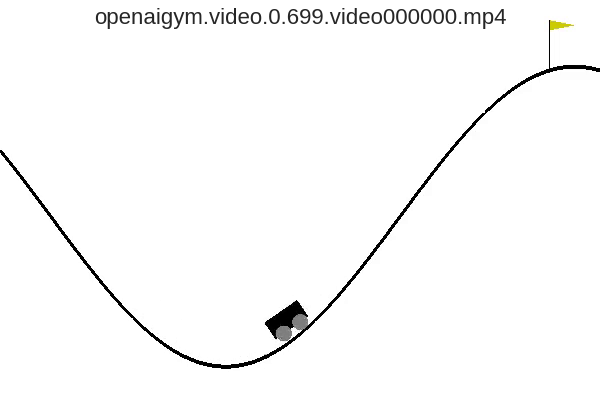
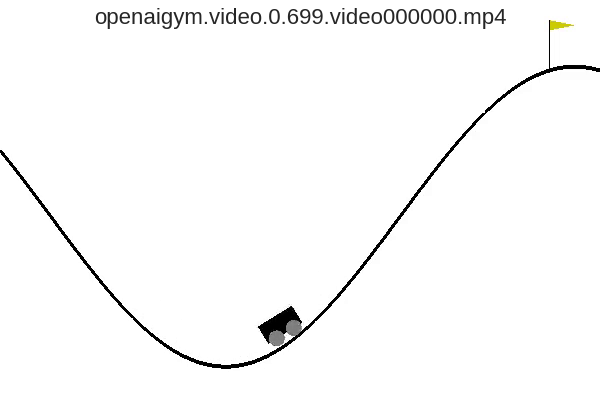
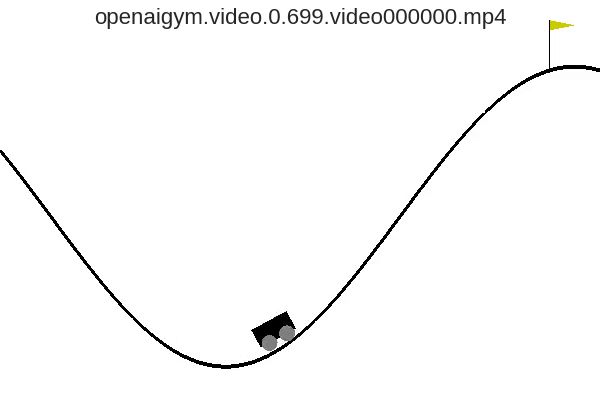
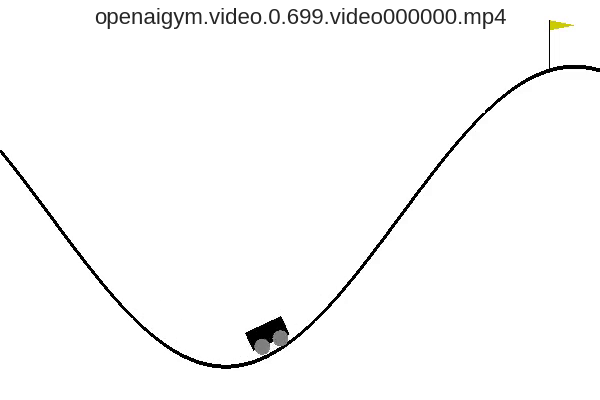
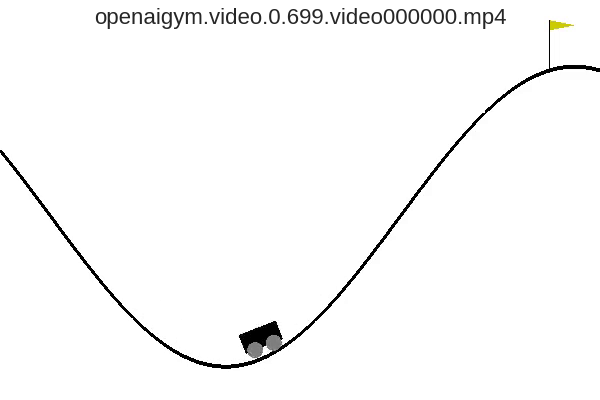
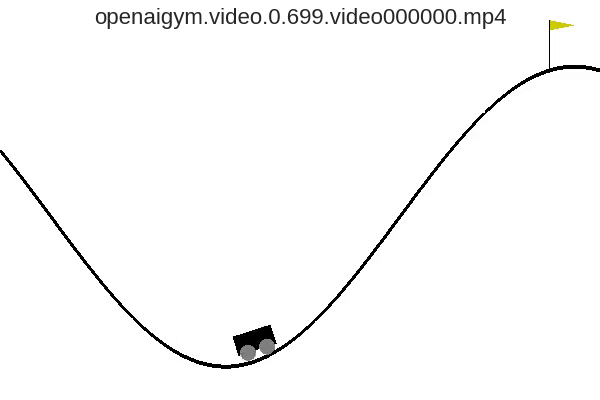
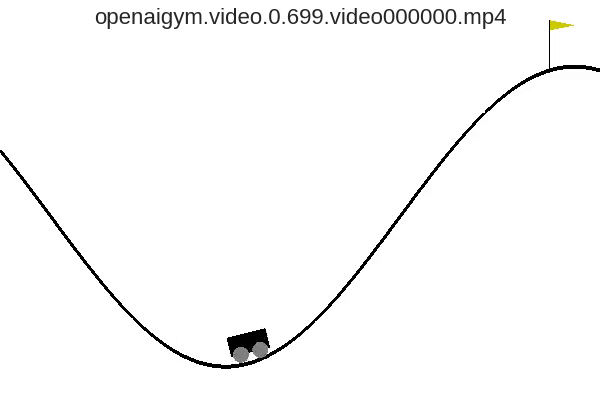
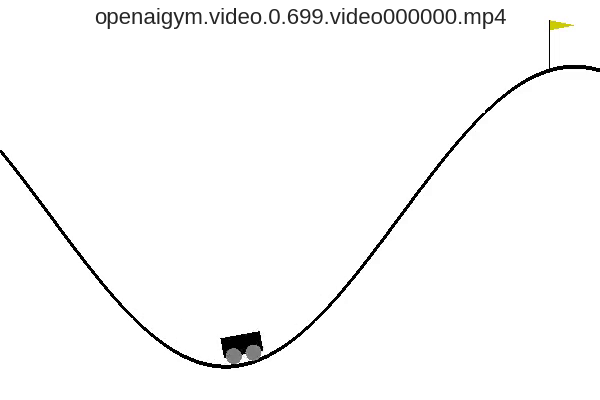
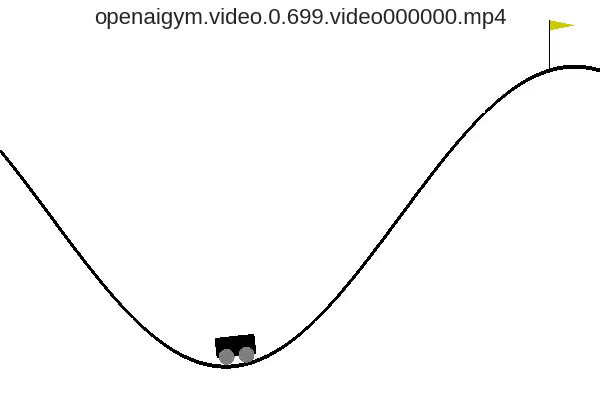
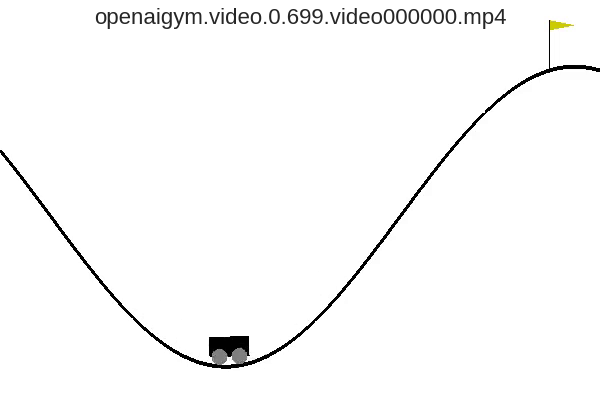
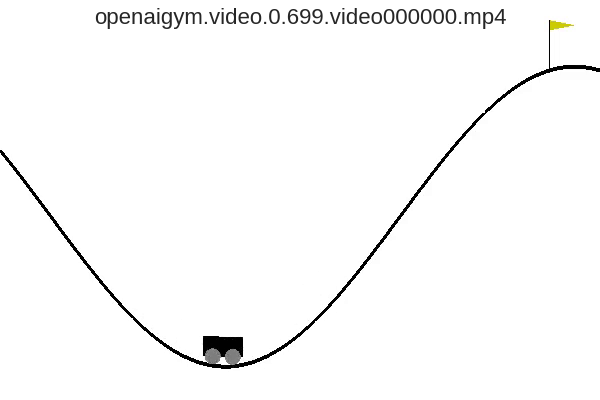
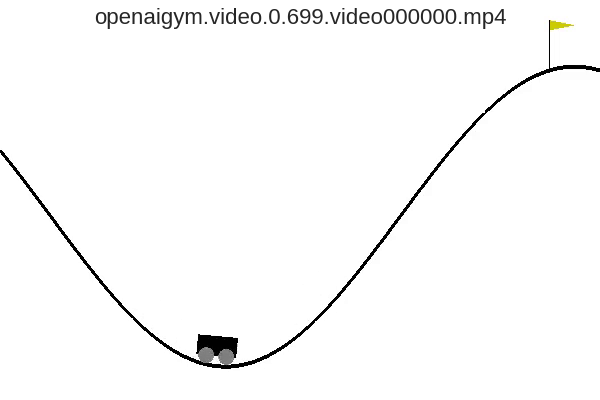
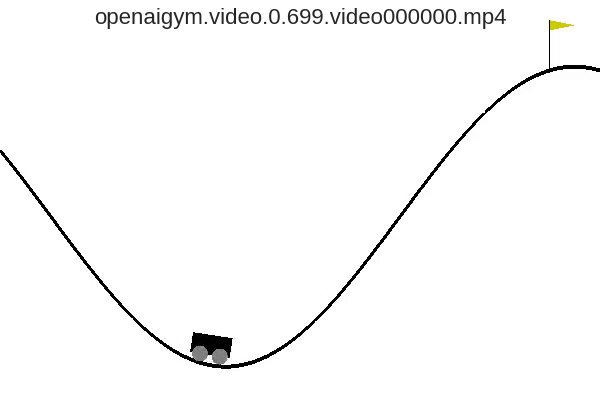
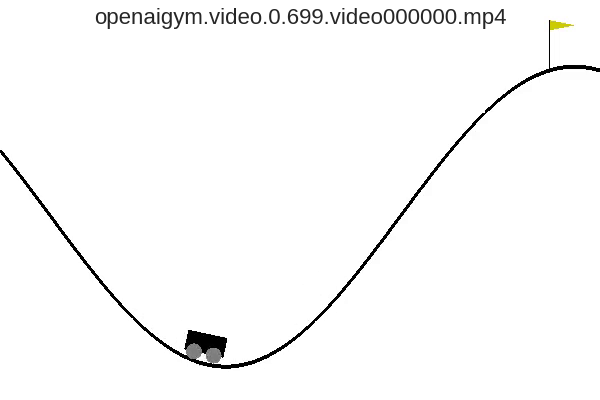
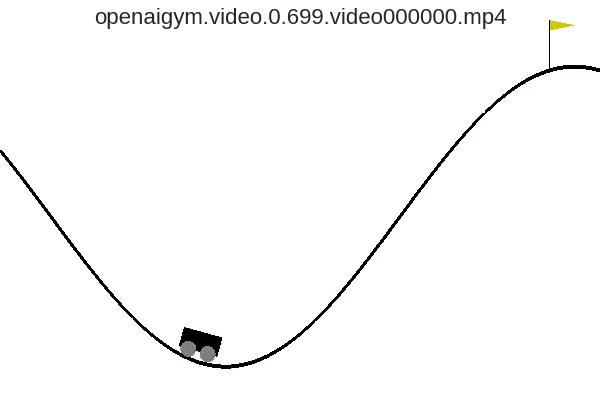
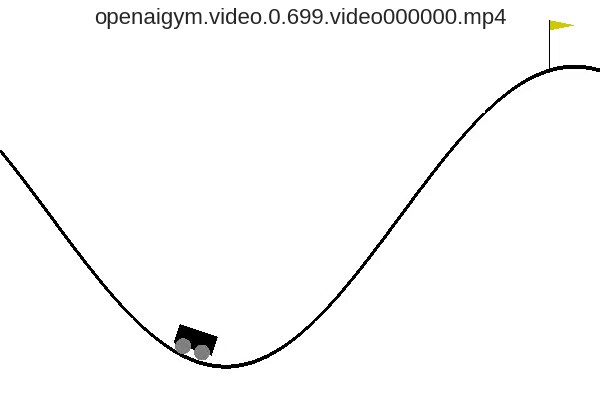
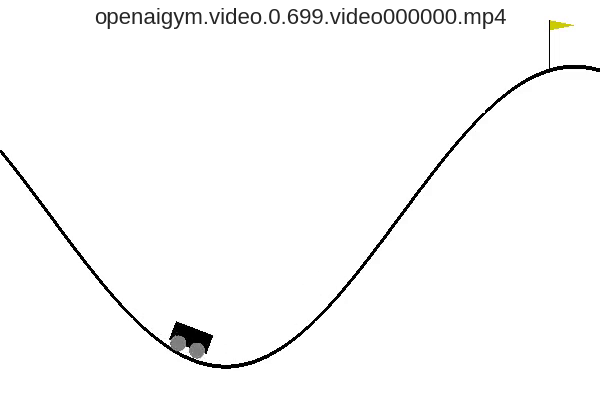
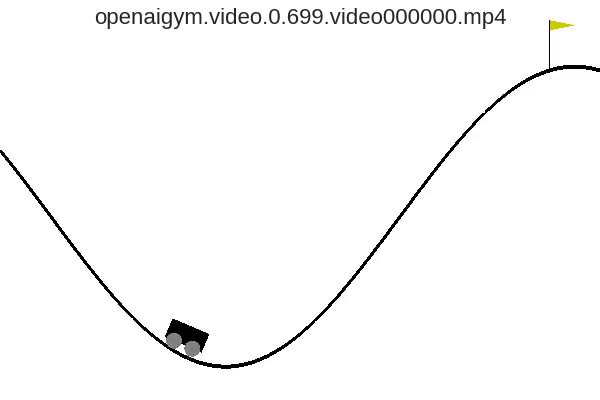
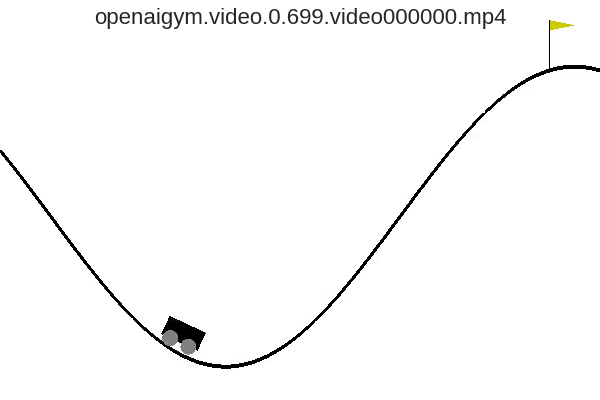
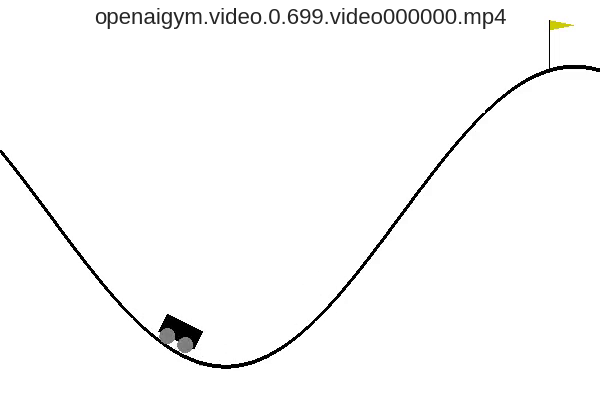
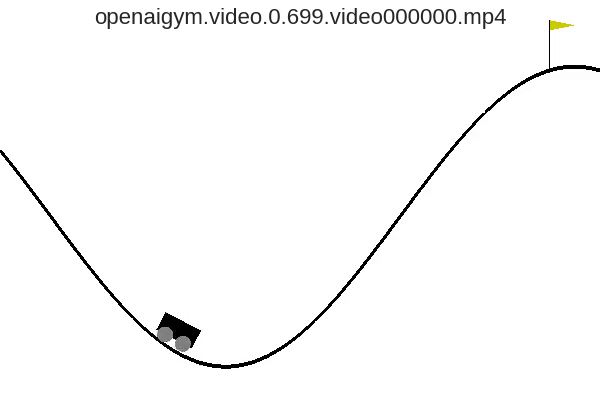
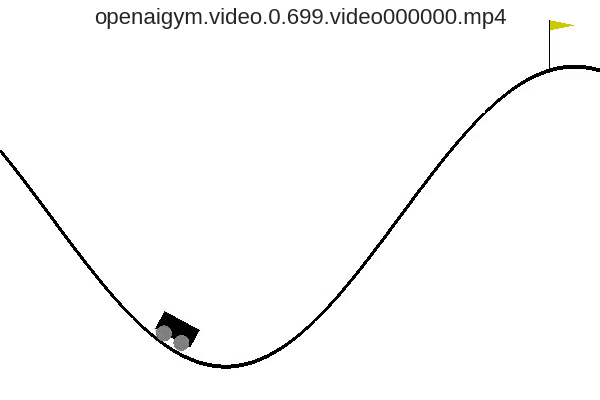
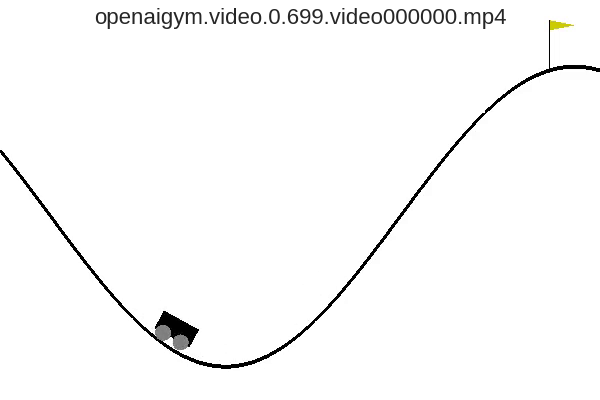
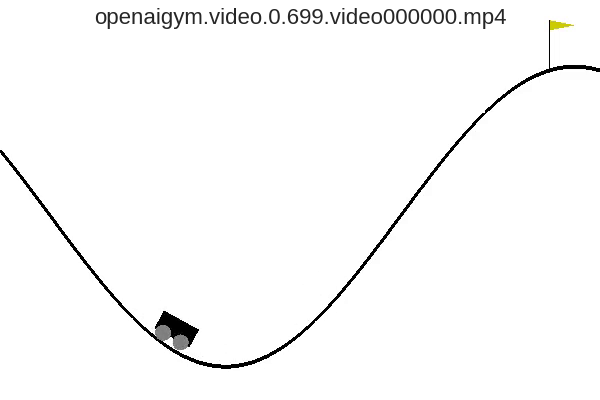
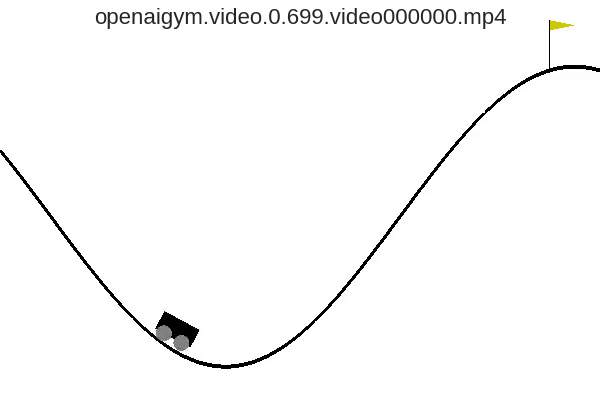
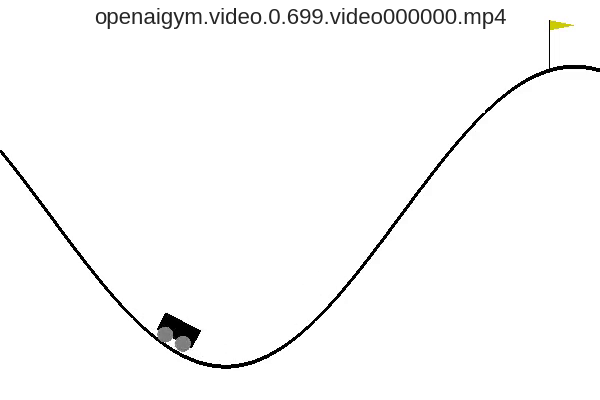
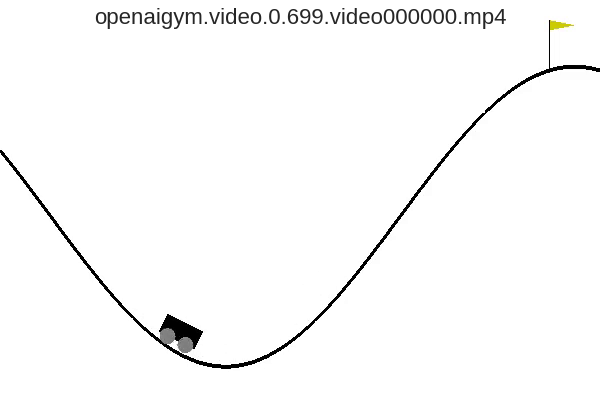
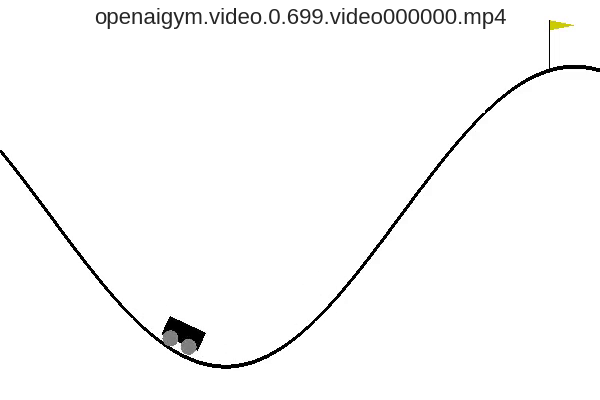
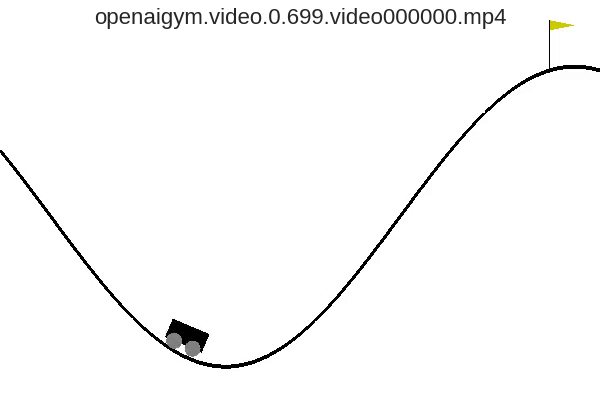
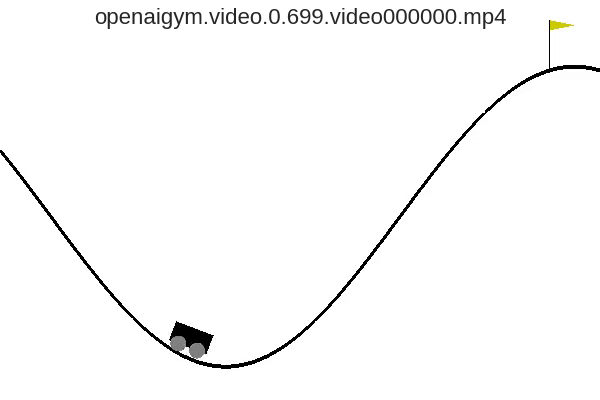
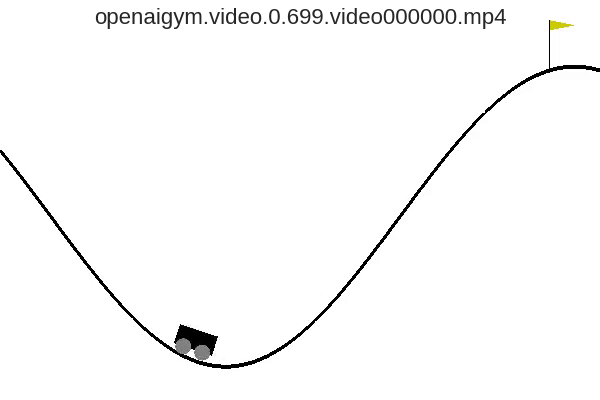
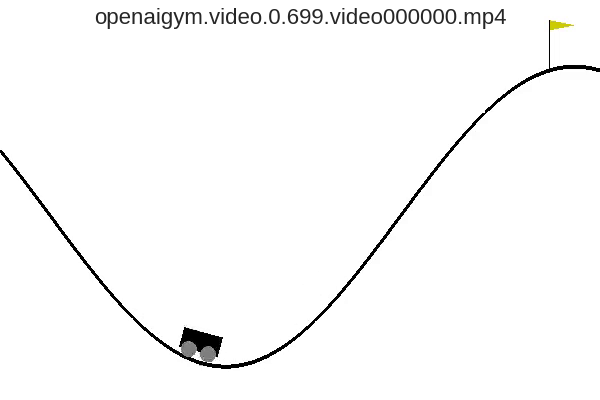
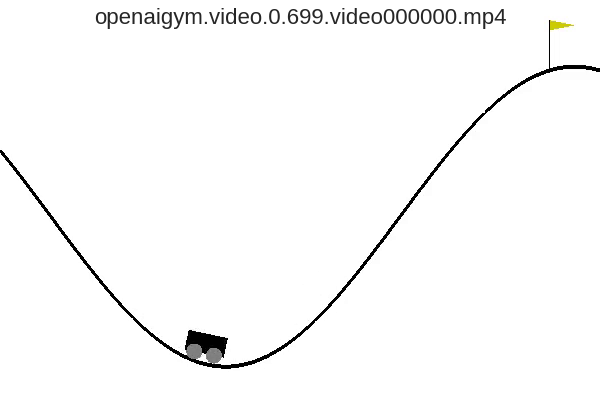
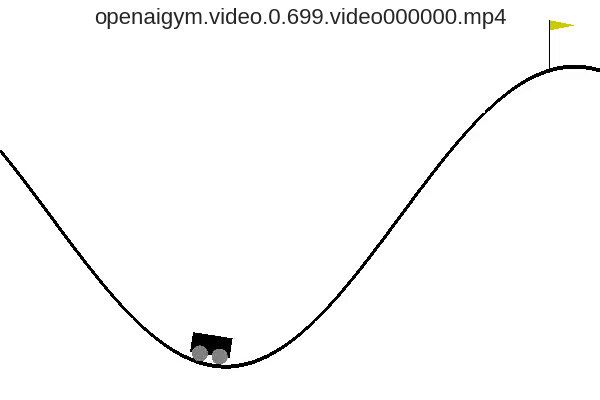
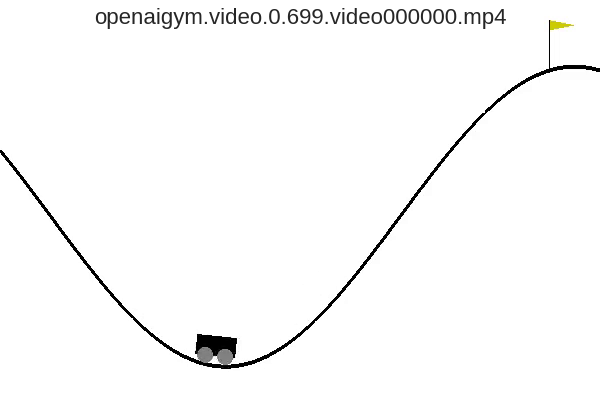
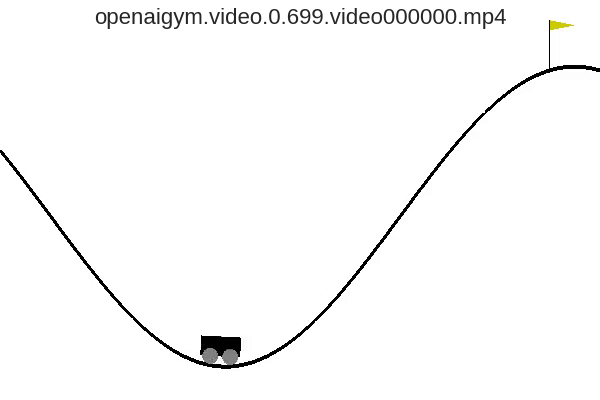
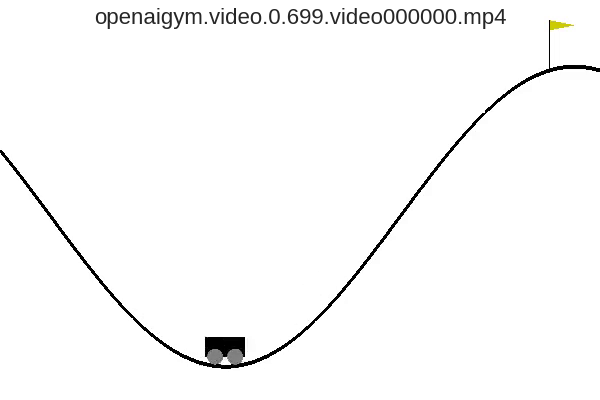
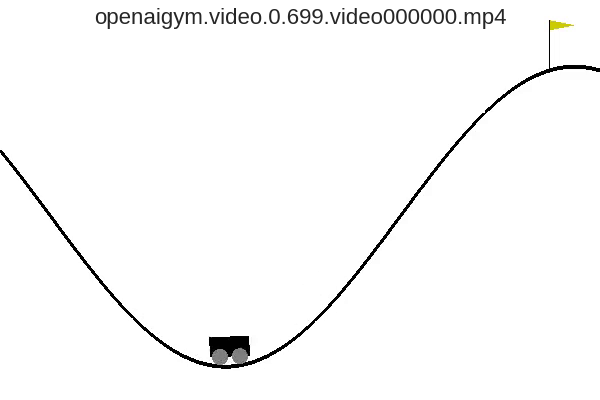
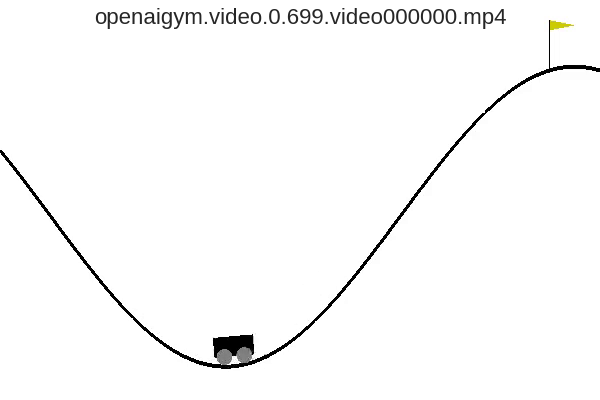
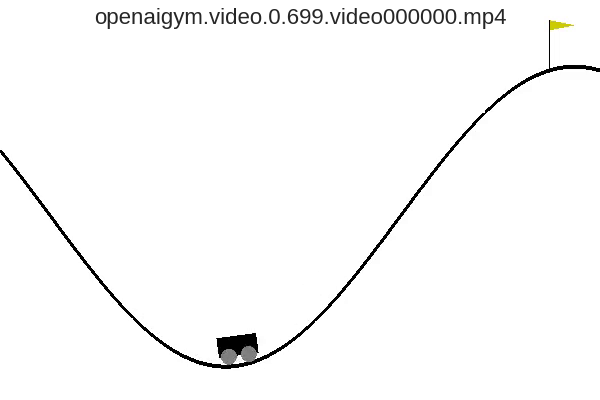
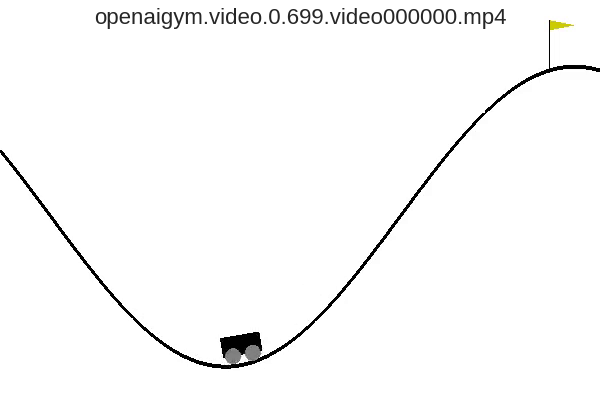
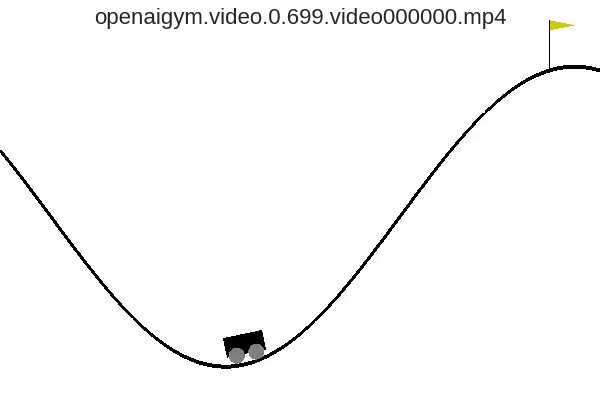
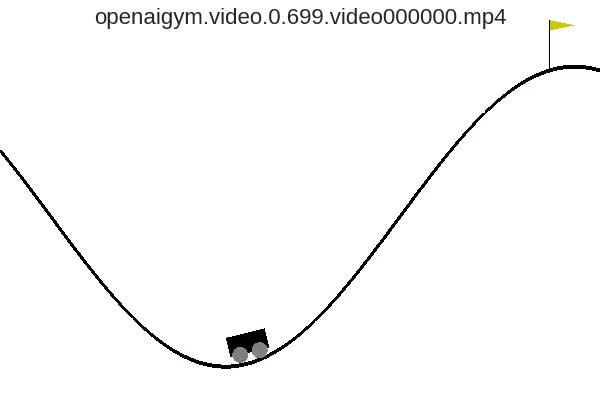
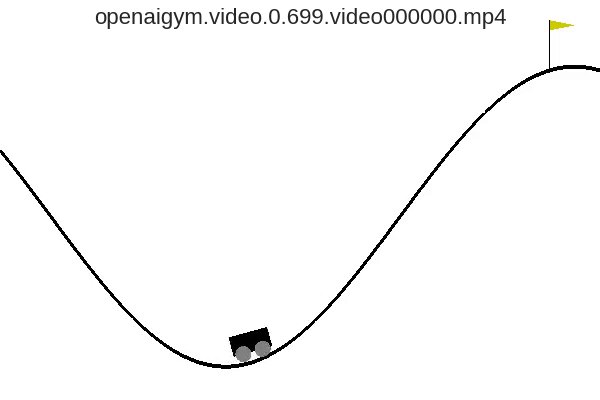
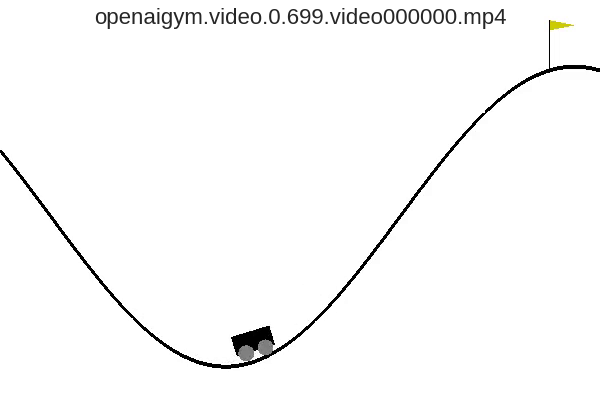
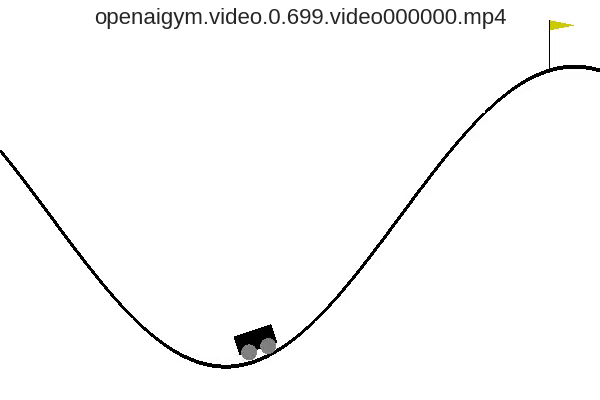
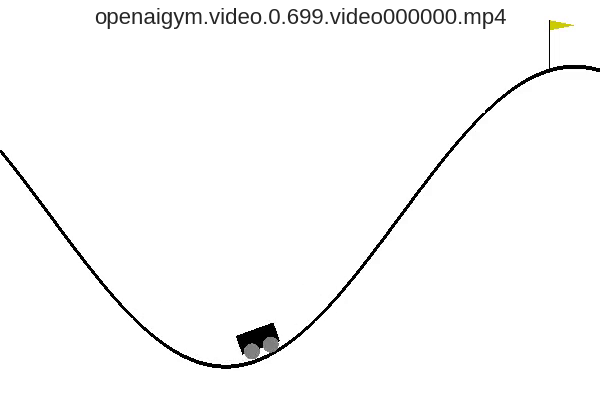
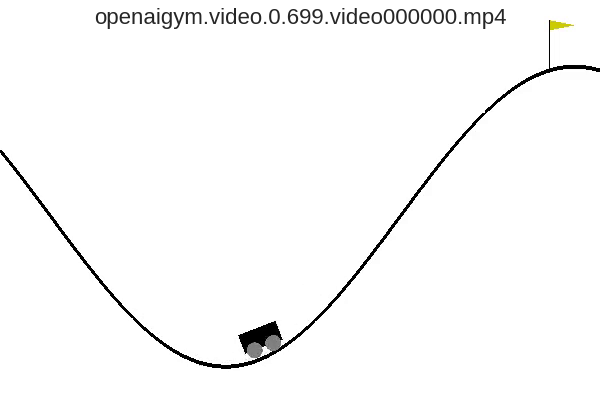
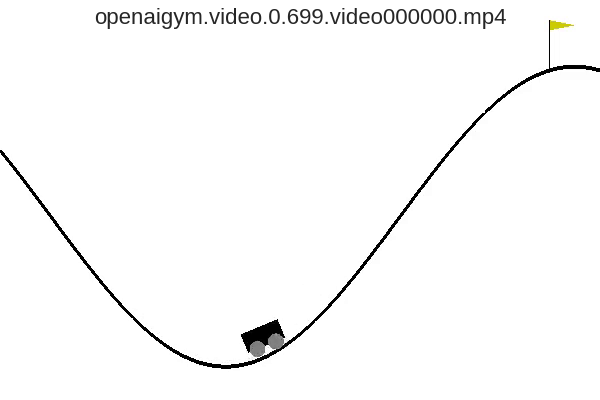
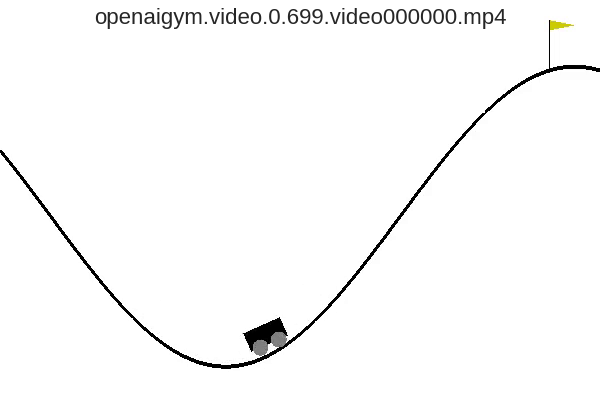
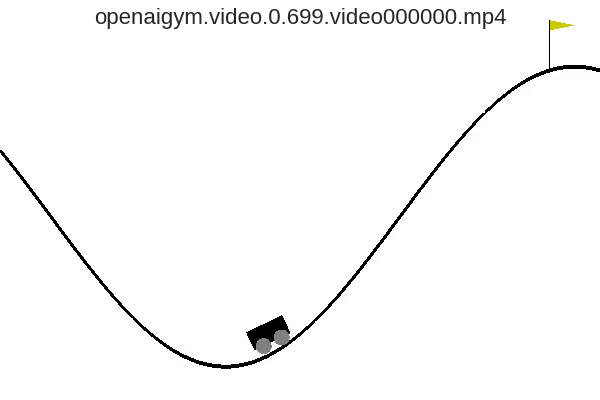
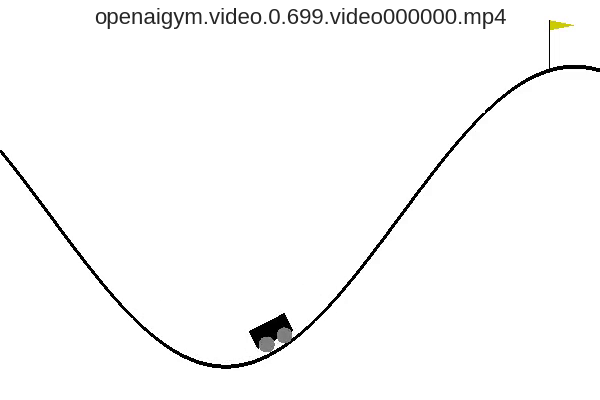
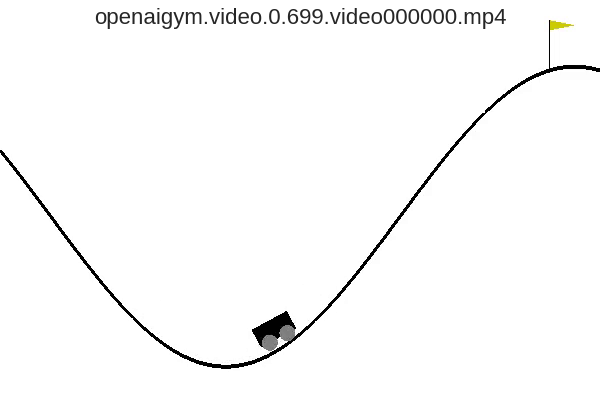
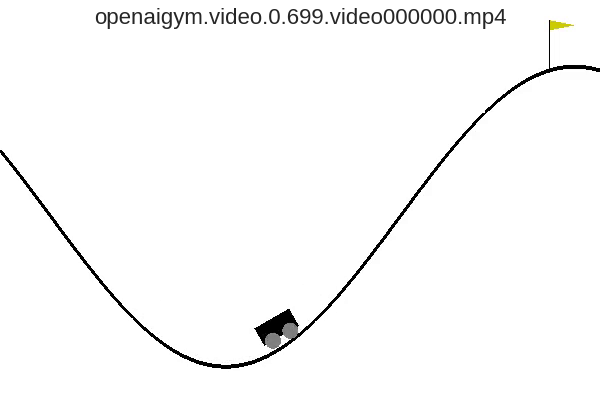
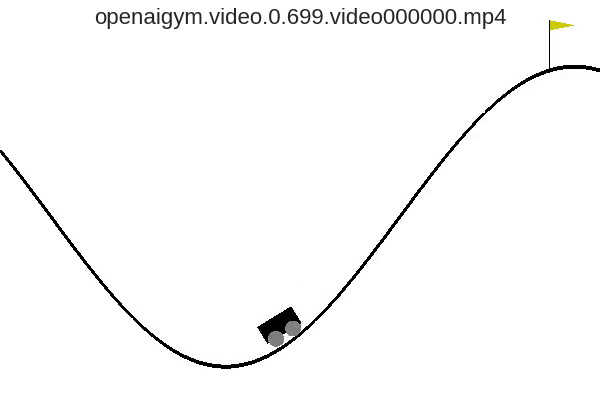
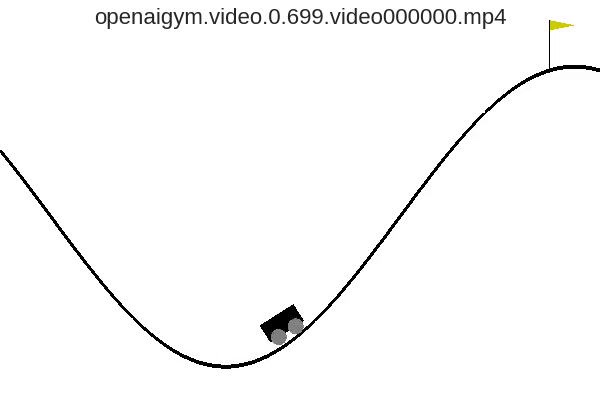
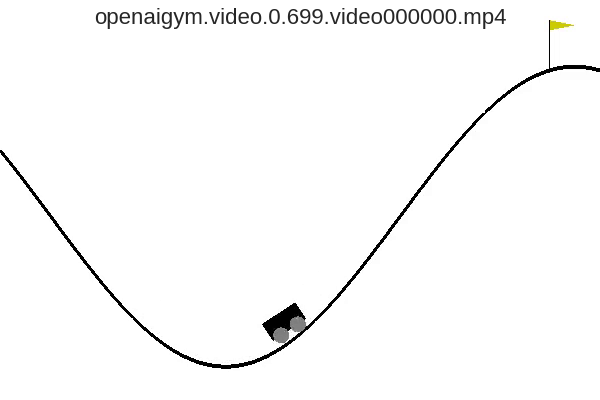
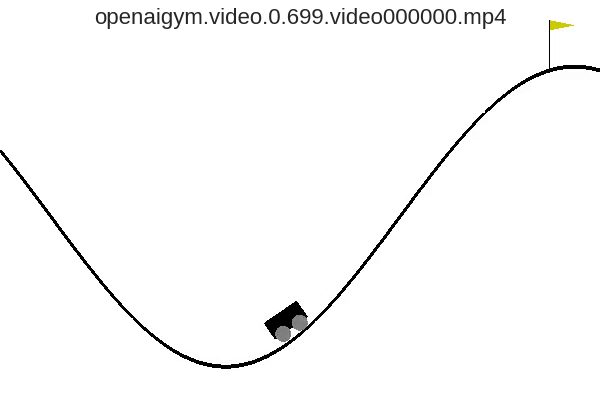
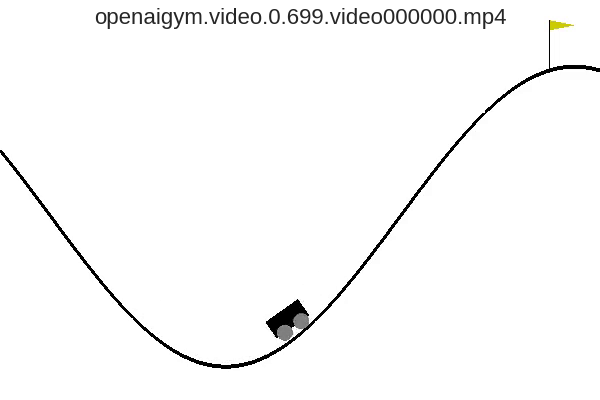
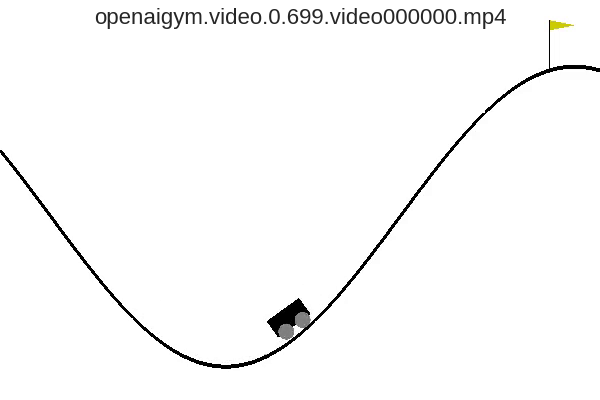
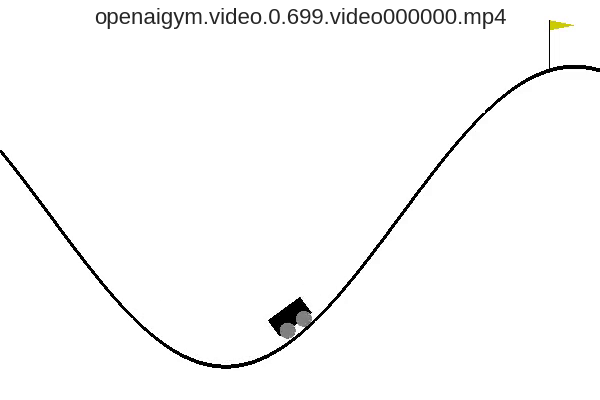
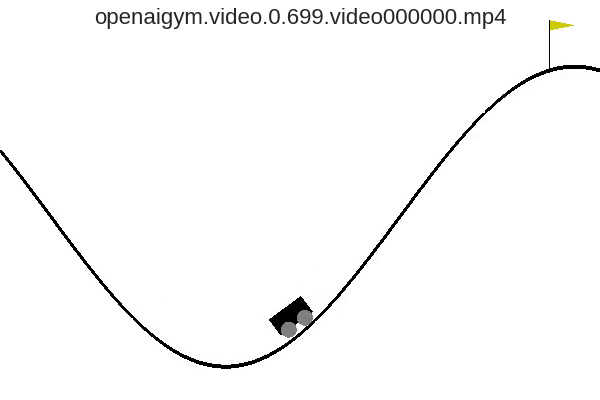
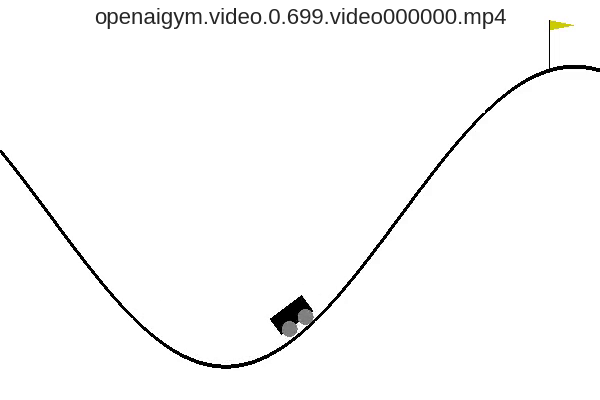
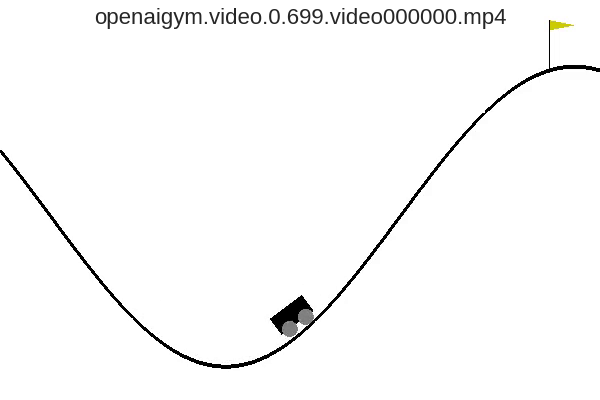
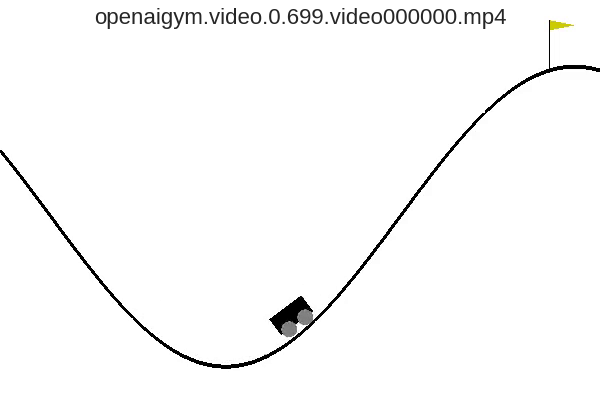
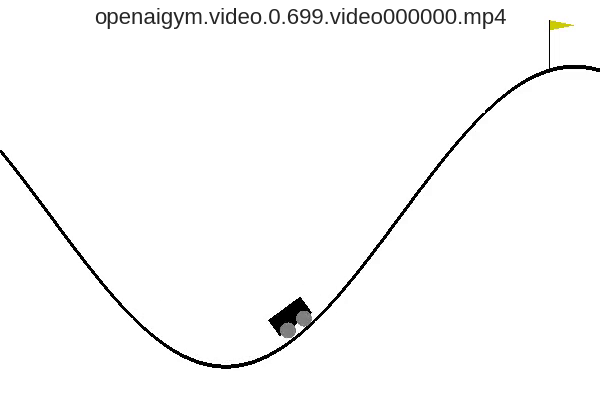
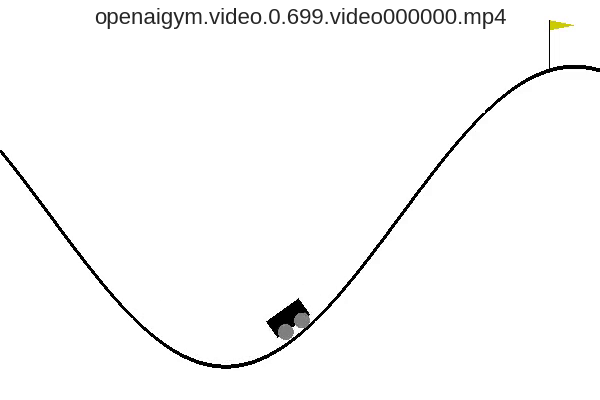
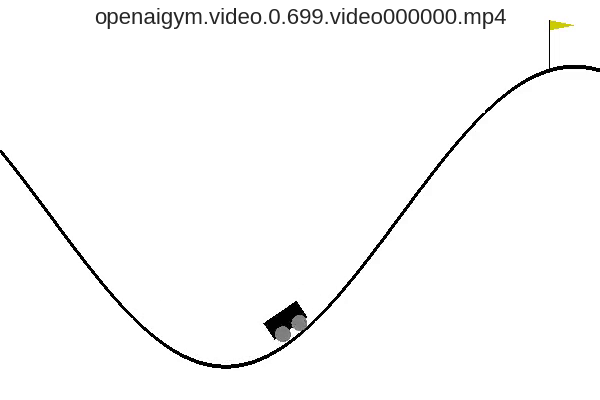
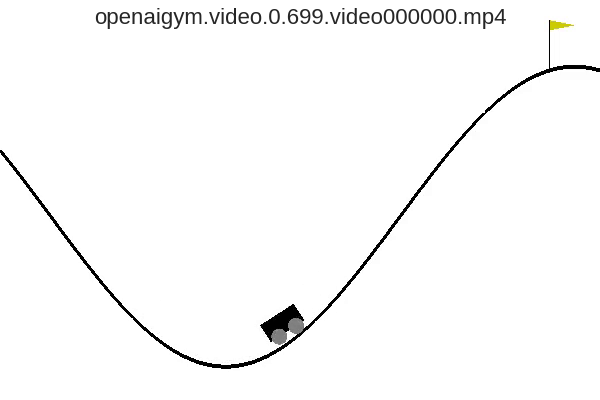
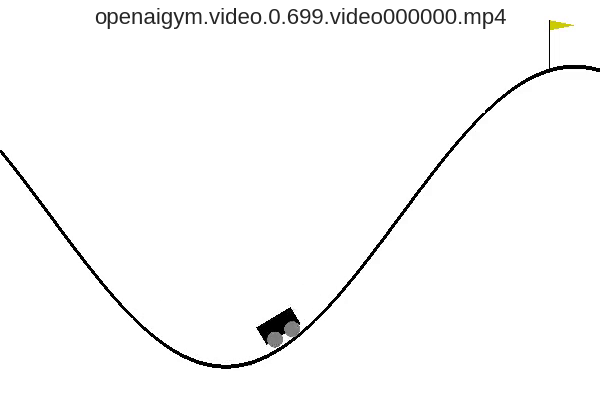
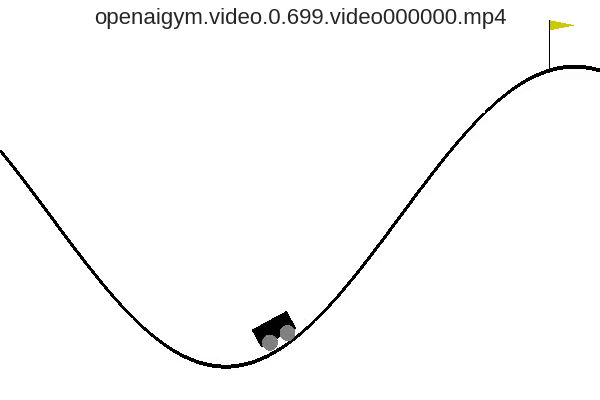
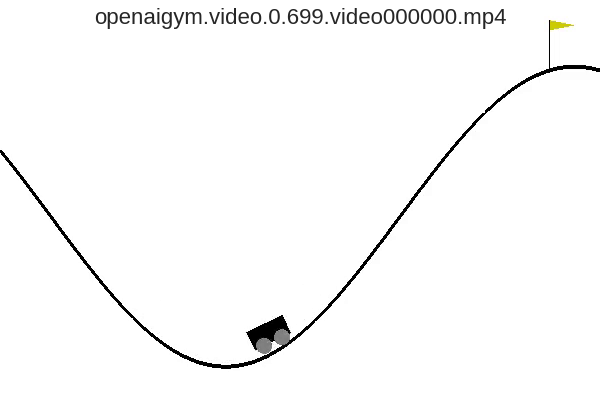
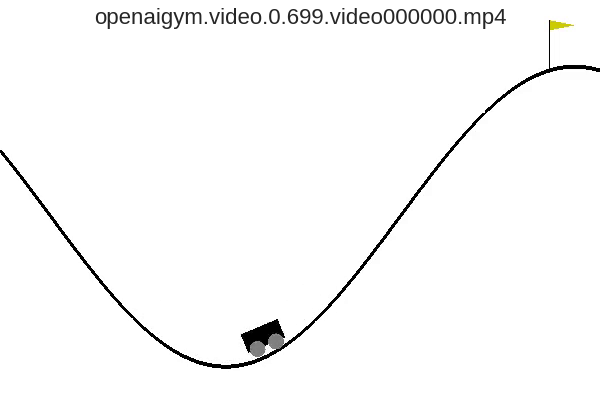
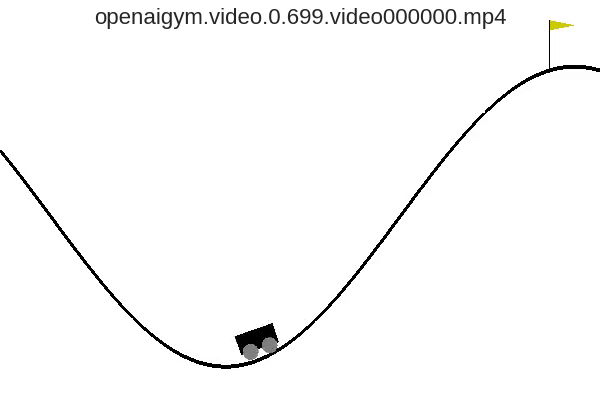
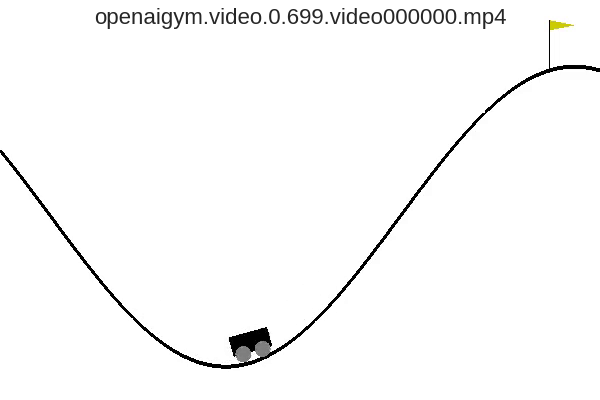
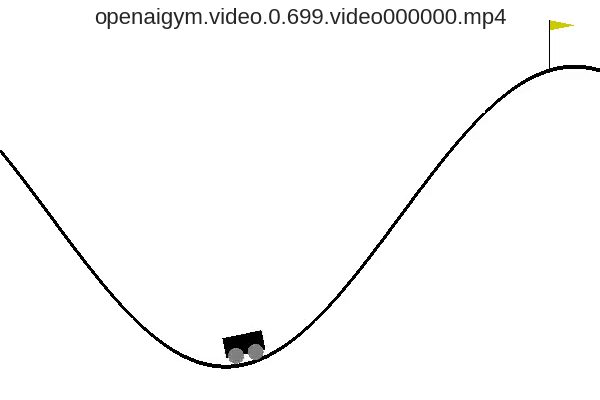
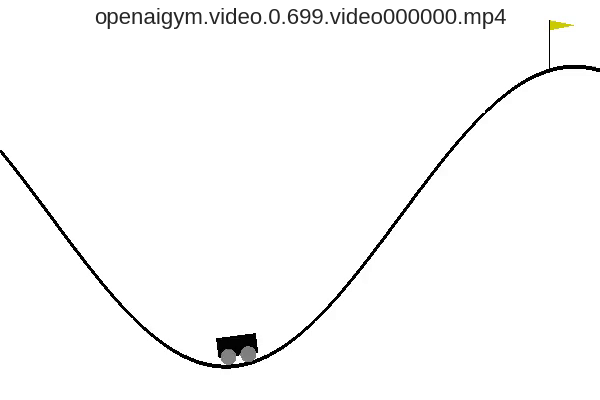
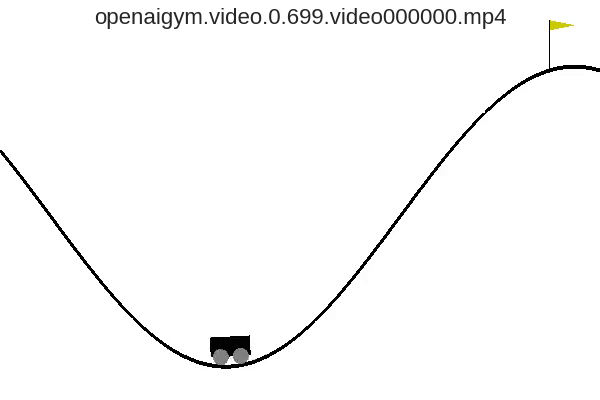
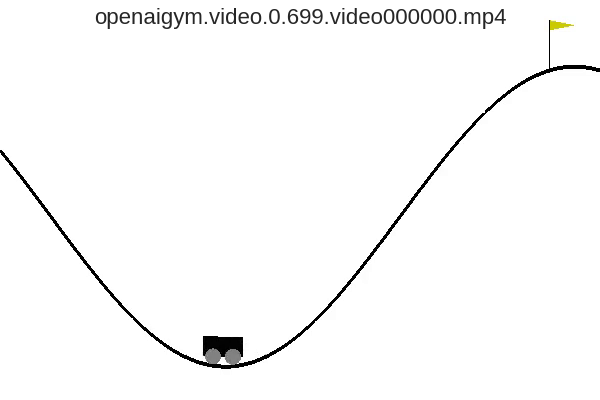
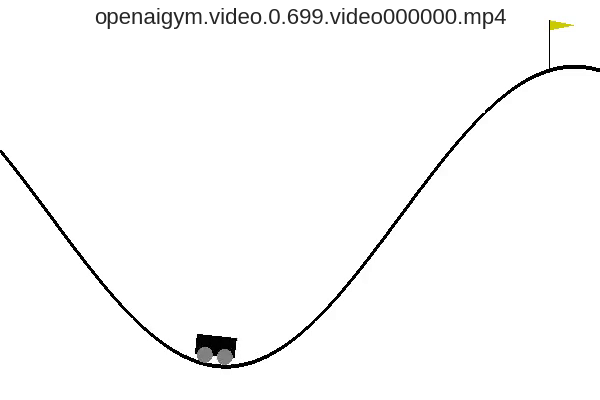
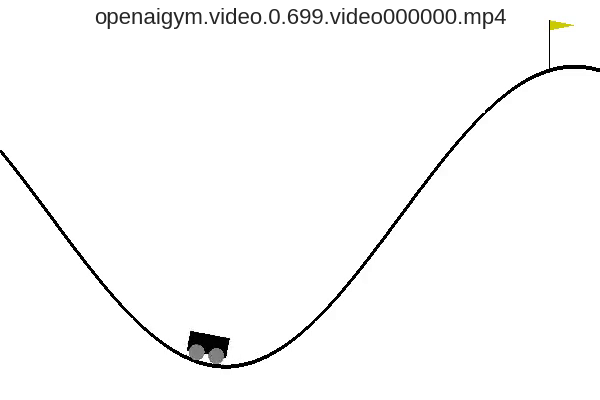
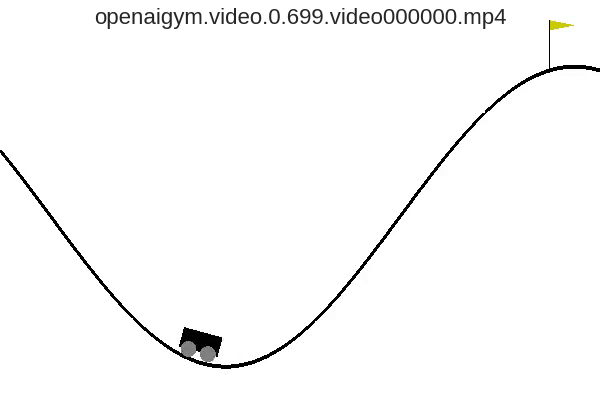
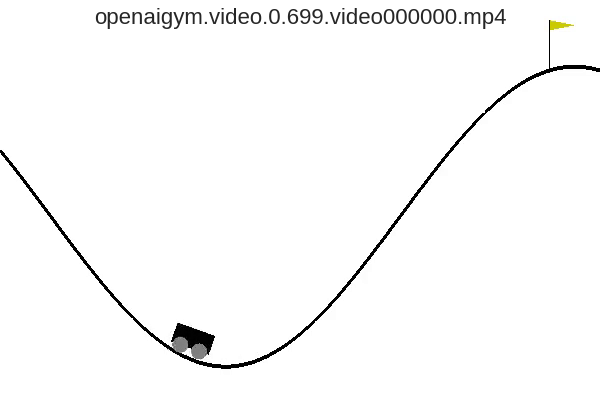
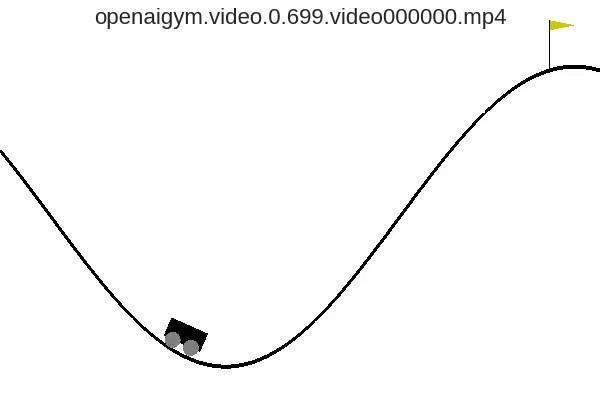
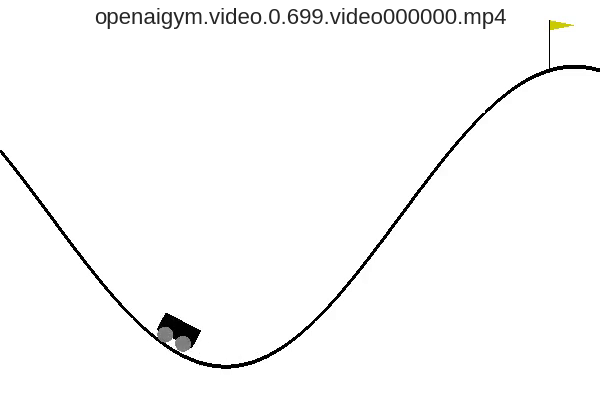
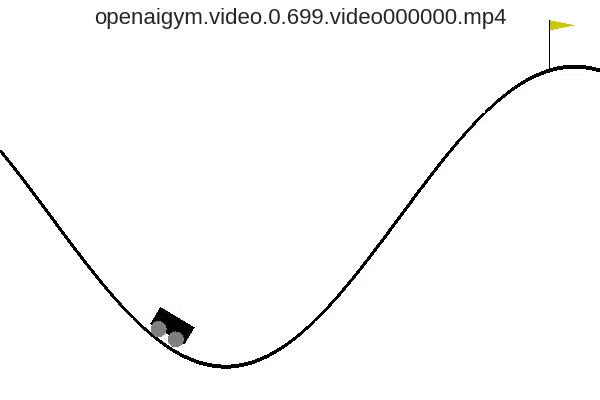
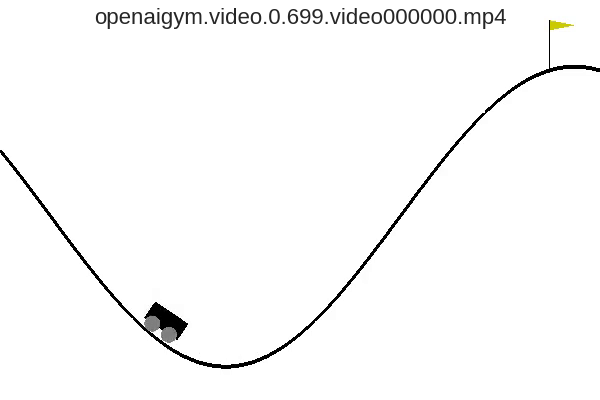
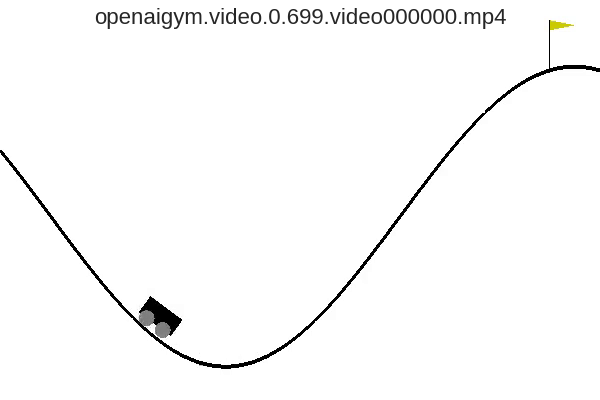
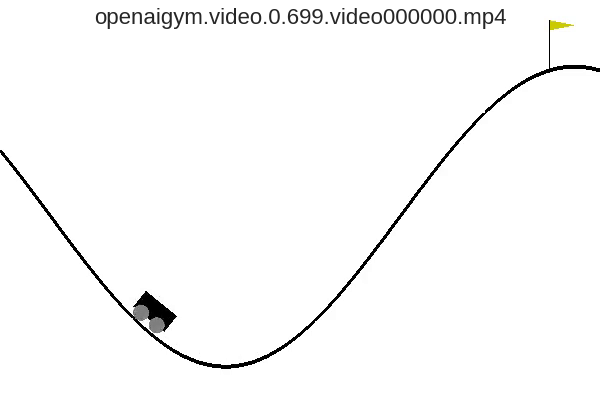
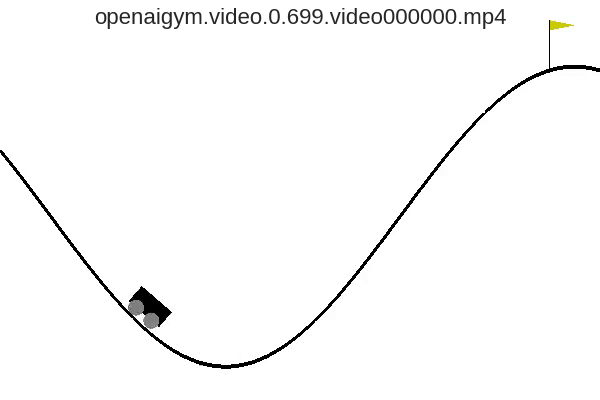
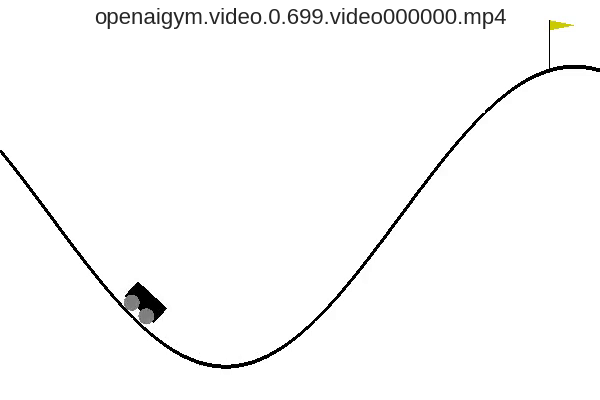
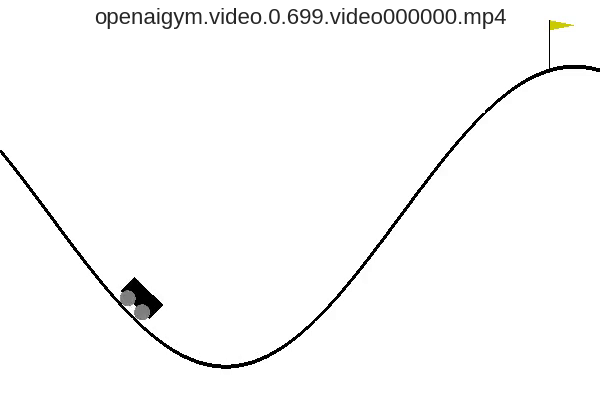
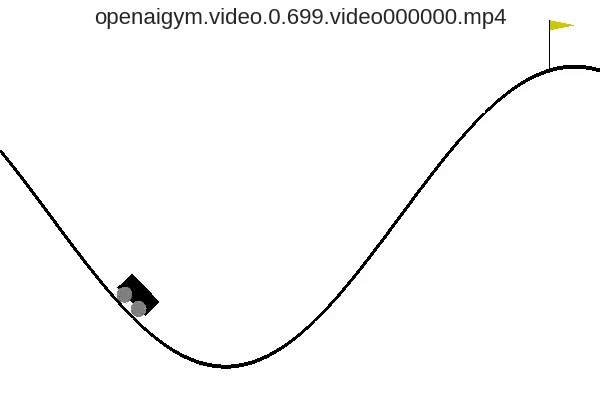
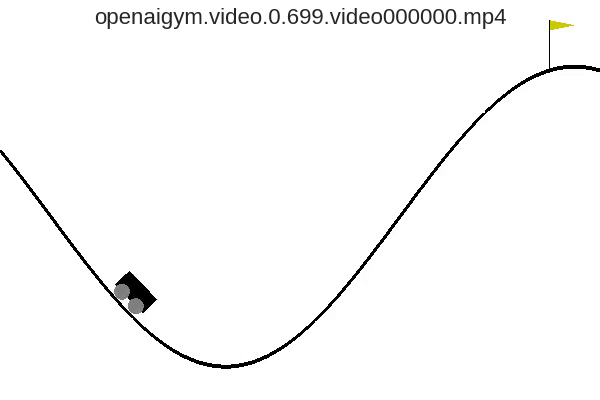
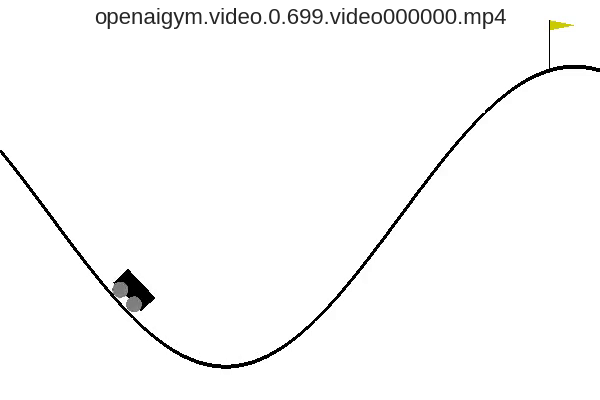
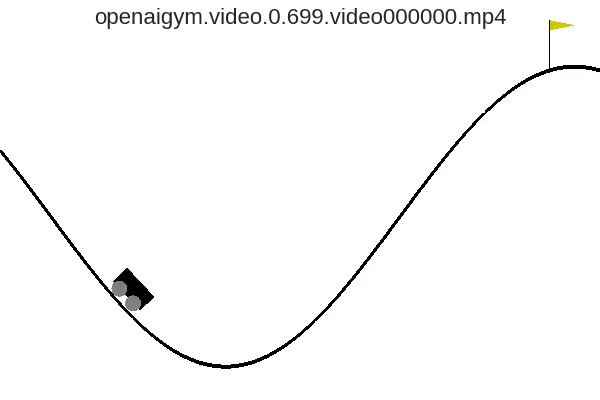
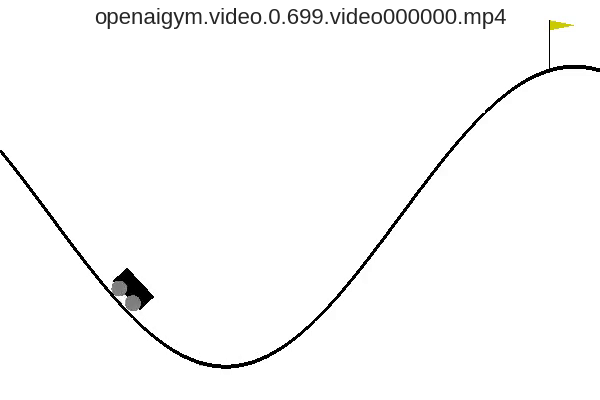
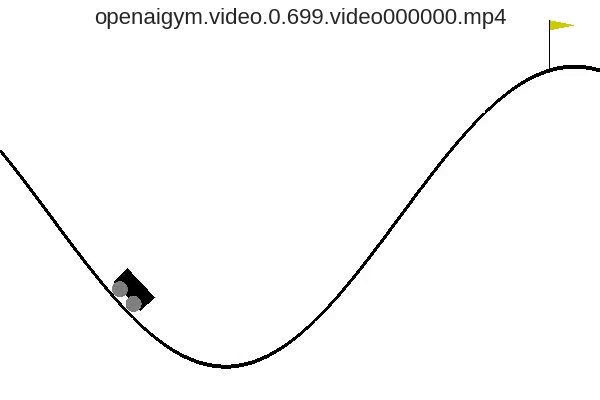
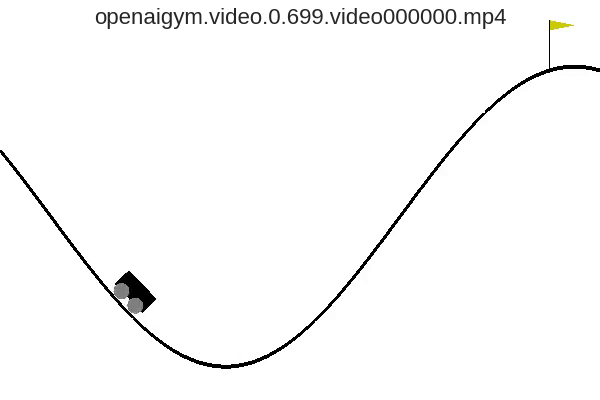
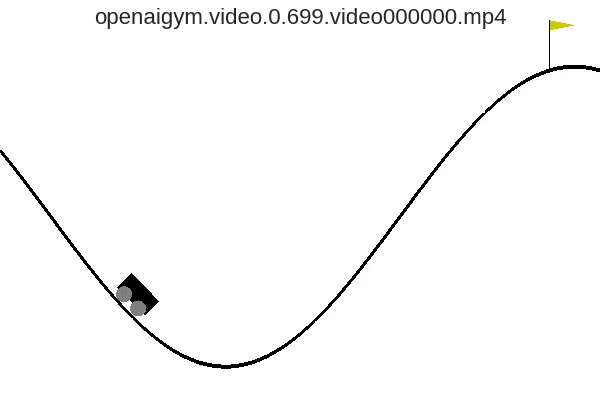
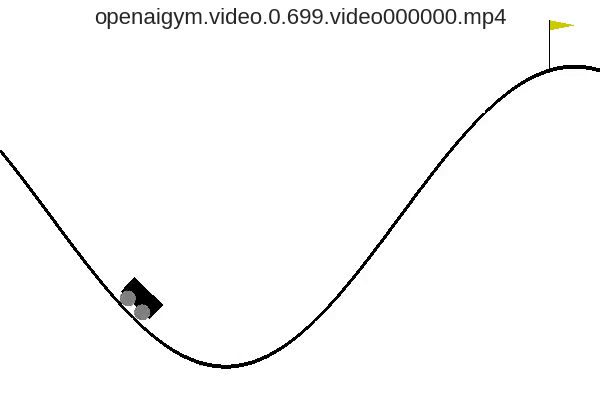
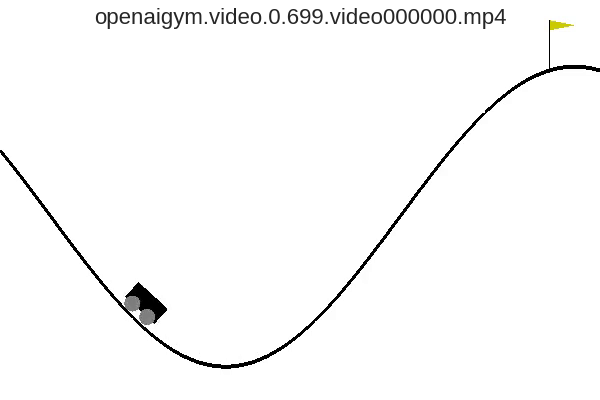
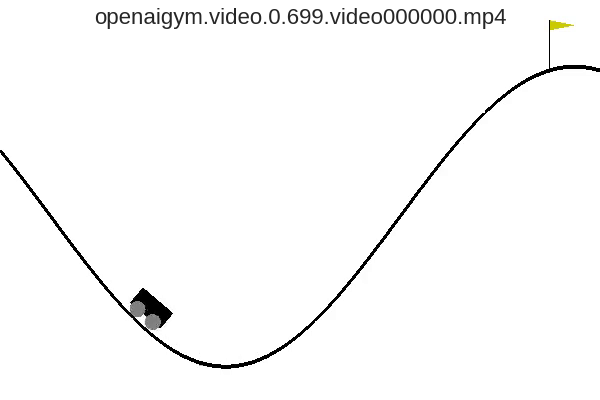
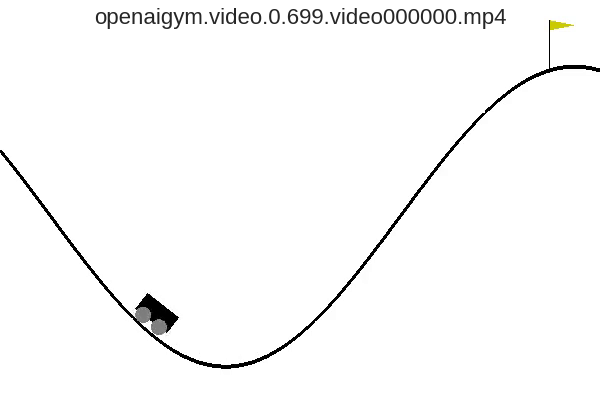
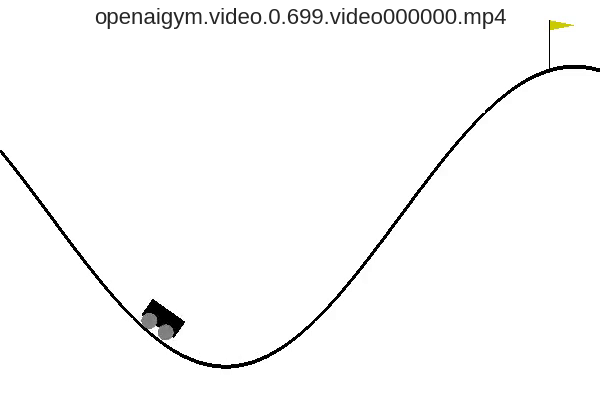
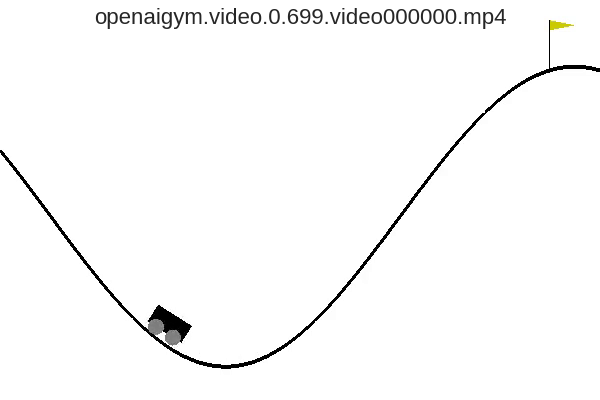
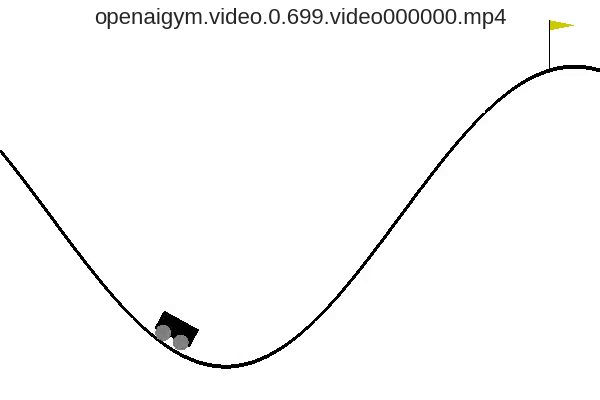
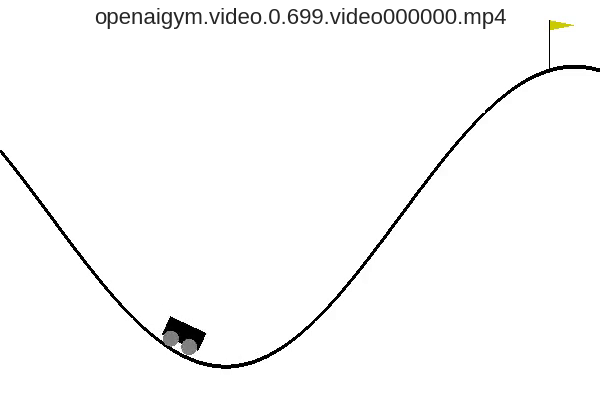
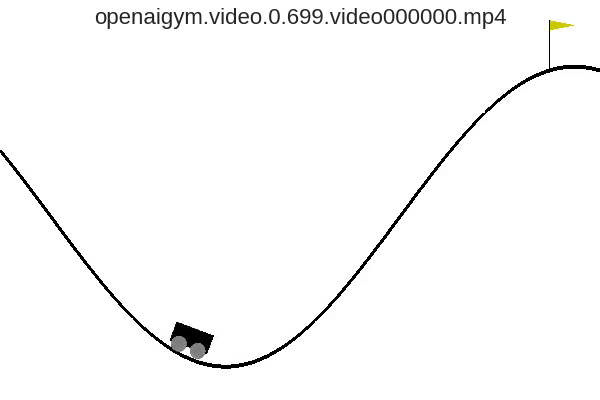
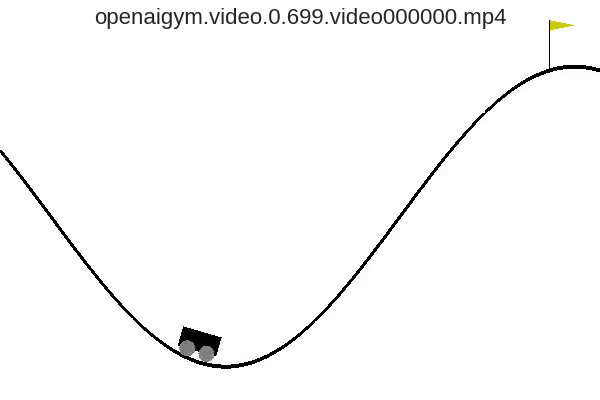
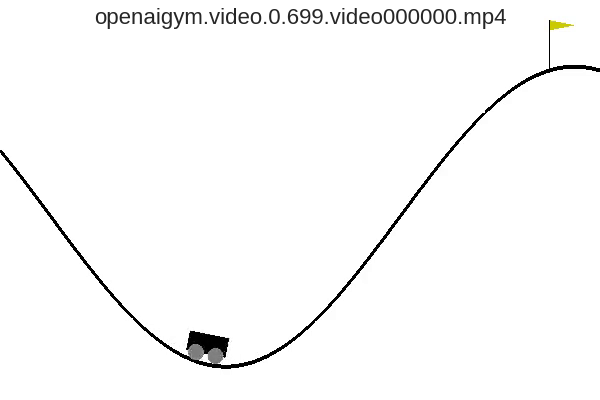
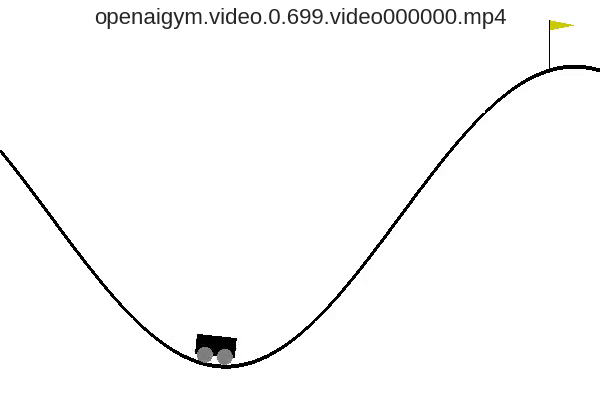
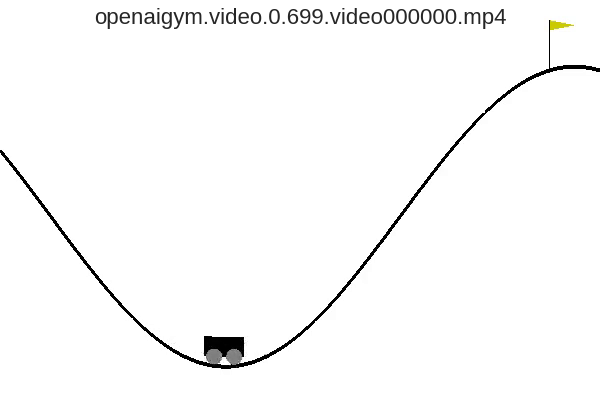
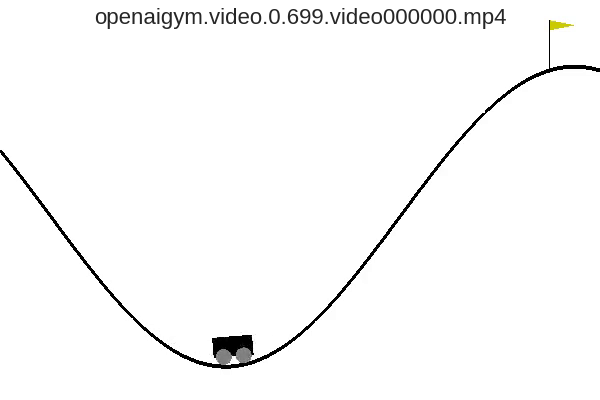
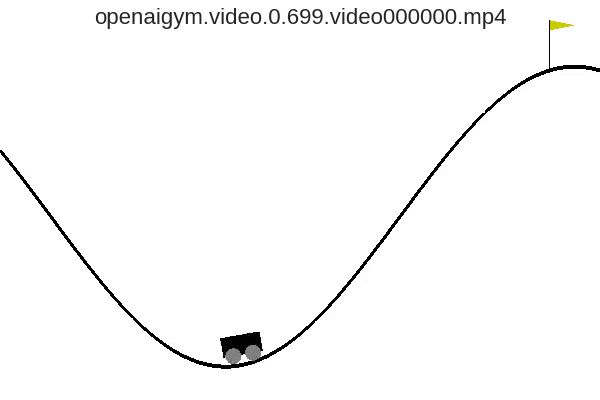
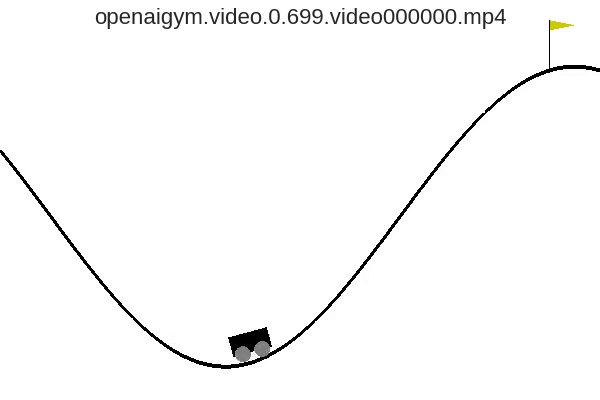
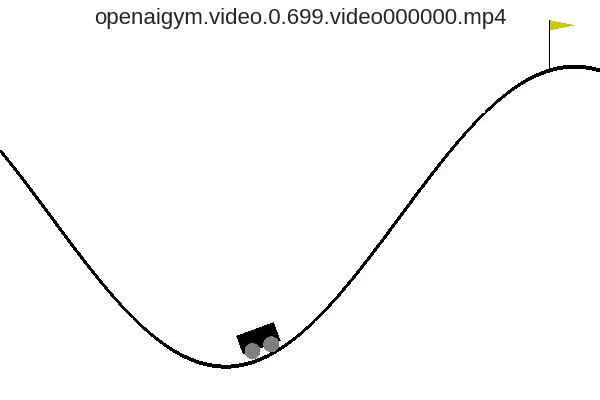
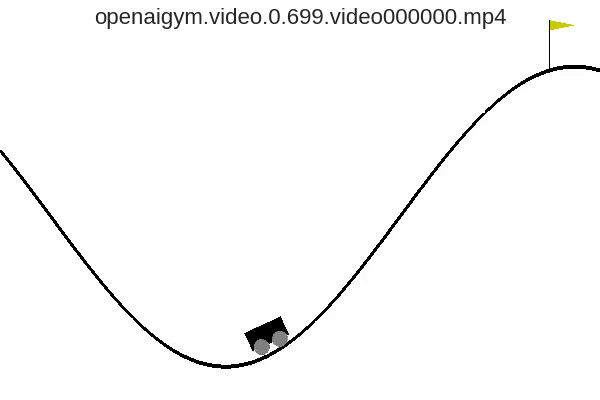
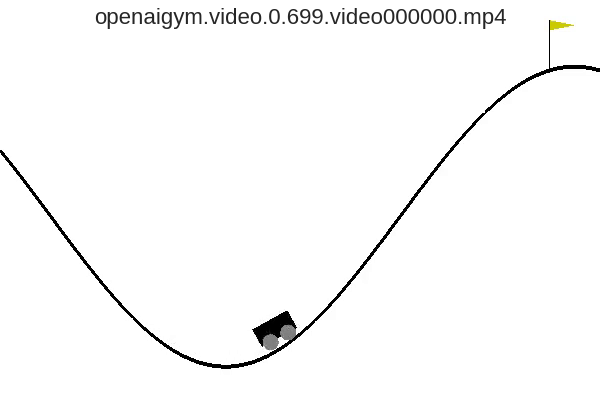
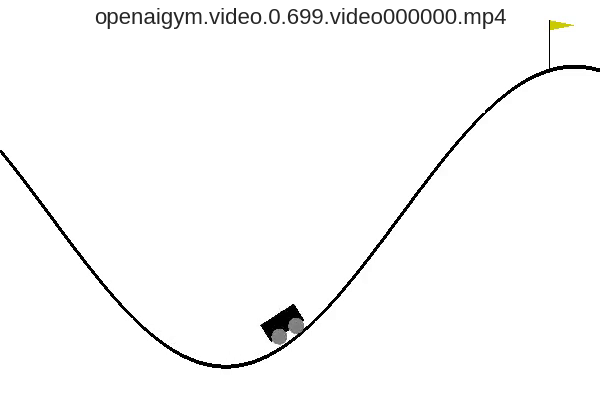
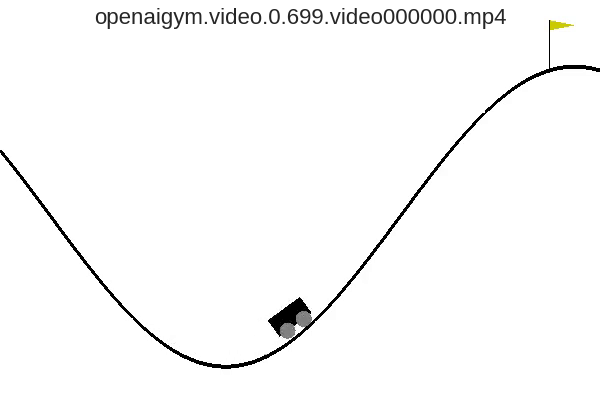
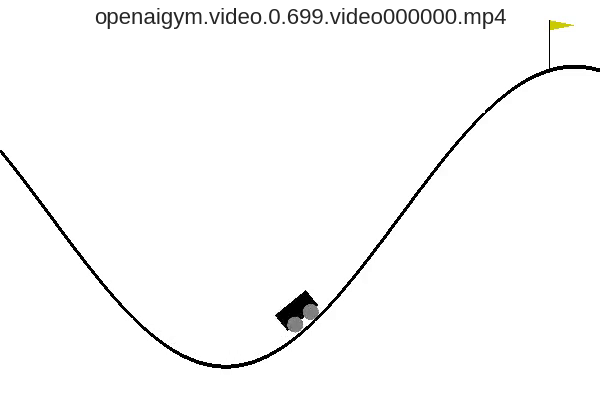
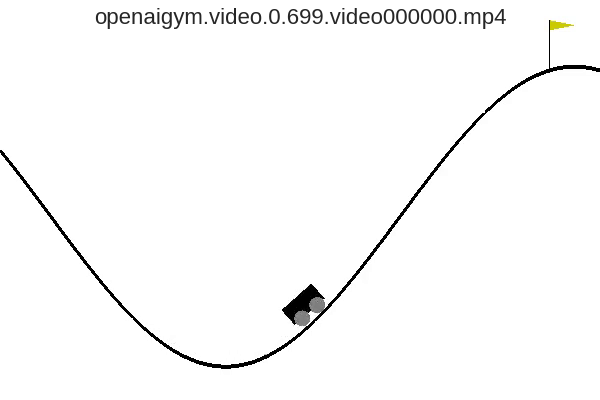
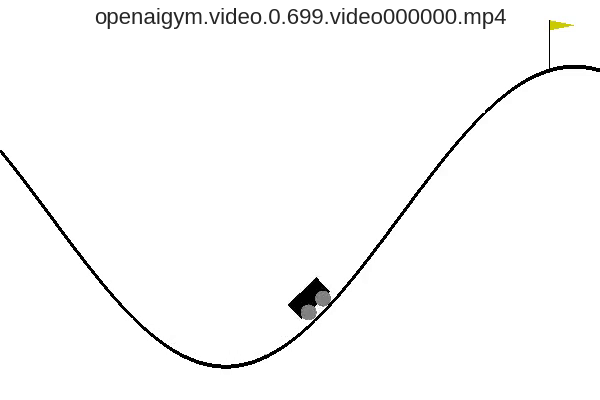
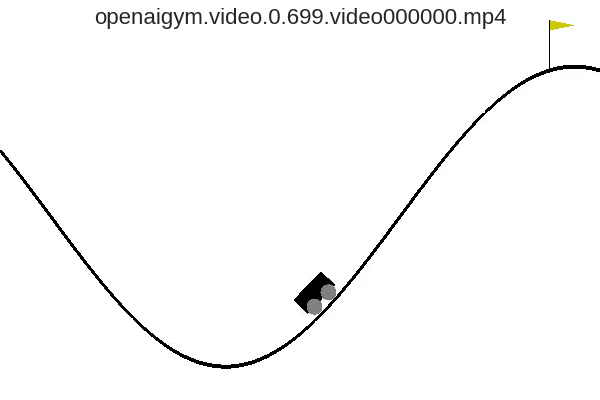
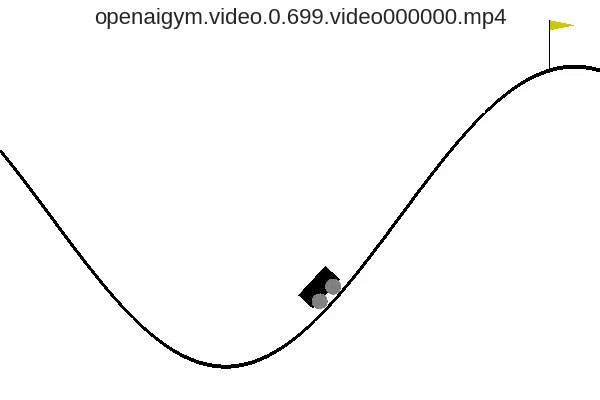
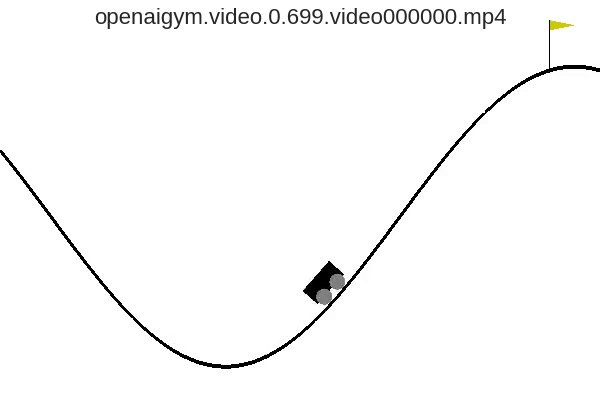

In [0]:
from IPython import display as pythondisplay
# from pyvirtualdisplay import Display

# from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from matplotlib import animation
from JSAnimation import IPython_display
from IPython.display import HTML

import imageio

from os import listdir
from os.path import isfile, join

def plot_movie_js(image_array, filename):
    dpi = 10.0
    xpixels, ypixels = image_array[0].shape[0], image_array[0].shape[1]
    fig = plt.figure(figsize=(ypixels/(dpi), xpixels/(dpi)), dpi=dpi)
    fig.suptitle(filename, fontsize=160)
    # fig.set_xlabel(filename, fontsize=160)
    # fig.xlabel(filename, fontsize=160)
    im = plt.figimage(image_array[0])

    def animate(i):
        im.set_array(image_array[i])
        return (im,)
    
    anim = animation.FuncAnimation(fig, animate, frames=len(image_array))
    pythondisplay.display(IPython_display.display_animation(anim))


mypath += 'gym_log/'
mp4files = [f for f in listdir(mypath) if f.endswith(".mp4")]
mp4files.sort()


for filename in mp4files:
    vid = imageio.get_reader(join(mypath, filename),  'ffmpeg')
    # print(len(vid))
    # print(vid.get_data(0).shape)

    screenlist = []
    for i in range(len(vid)):
        image = vid.get_data(i)
        screenlist.append(image)
        # fig = plt.figure()
        # fig.suptitle('image #{}'.format(i), fontsize=20)
        # plt.imshow(image)

    plot_movie_js(screenlist, filename)
